In [1]:
# Suppress warnings
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Importing python built in libraries
import pandas as pd
import numpy as np

In [3]:
# For Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Importing LogisticRegression and metrics from sklearn library
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
#from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [5]:
#Importing the PCA module
from sklearn.decomposition import PCA

## Generic Functions

In [6]:
# This function generated the nulls reports

def get_nulls_report(df,apply_style="Y"):
    if apply_style=="Y":
        cm = sns.light_palette("orange", as_cmap=True)
        return pd.DataFrame([df.isnull().sum(),round(100*(df.isnull().sum()/len(df.index)), 2)]).T.rename(columns={0:'Total Nulls',1:'Nulls Percentage'}).\
sort_values(by='Nulls Percentage',ascending=False).style.background_gradient(cmap=cm)
    else:
        return pd.DataFrame([df.isnull().sum(),round(100*(df.isnull().sum()/len(df.index)), 2)]).T.rename(columns={0:'Total Nulls',1:'Nulls Percentage'}).\
sort_values(by='Nulls Percentage',ascending=False)

In [7]:
# This function returns the list of categorical or Number columns in the Dataframe

def get_variables_type(df,type_of_var):
    if type_of_var=="CATERGORICAL":
        return list(leads_df.select_dtypes(exclude=[np.number]).columns)
    else:
        return list(df.select_dtypes(include=[np.number]).columns)  

In [8]:
# This function returns the frequency of column values
def get_column_frequency(ds):
    return pd.DataFrame(ds.value_counts(dropna=False))

In [9]:
# This function draw both Distribution and Box Plot for a clumn
def draw_univariate_plot(df,cols):
 sns.set(style="darkgrid")   
 sns.set_palette(sns.color_palette("hls",20))
 fig, ax=plt.subplots(nrows =1,ncols=2,figsize=(20,8))
 ax[0].set_title("Distribution Plot")
 sns.distplot(df[cols],ax=ax[0])
 ax[1].set_title("Box Plot")
 sns.boxplot(data =df, x=cols,ax=ax[1],orient='v')
 plt.xticks(rotation='vertical',fontsize=12)
 plt.show()

In [10]:
# Draw Countplot 
def draw_countplot(df,cols):
  plt.figure(figsize=(15, 5))
  sns.countplot(x=cols, data=df)
  plt.show()

In [11]:
# draw plot based on Continous and Categorical Variable
def draw_plots(column_name,df,type_of_variable,hue=None,title=None):
 sns.set(style="darkgrid")   
 sns.set_palette(sns.color_palette("hls",20))
 
 if type_of_variable == "Continous" :
   fig, ax=plt.subplots(nrows =1,ncols=2,figsize=(20,8))
   ax[0].set_title("Distribution Plot")
   sns.distplot(df[column_name],ax=ax[0])
   ax[1].set_title("Box Plot")
   sns.boxplot(data =df, x=column_name,ax=ax[1],orient='v')
   plt.xticks(rotation='vertical',fontsize=12)
   plt.show()
    
 if type_of_variable == "Categorical" :
   fig, ax=plt.subplots(figsize=(14,8))
   plt.title(title)
   ax = sns.countplot(data = df, x= column_name, order=df[column_name].value_counts().index,hue = hue) 
   ax.set(xlabel=column_name, ylabel="Count")
   
   for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., np.nan_to_num(p.get_height()), '%d' % int(np.nan_to_num(p.get_height())), 
            fontsize=12, color='black', ha='center', va='bottom')
   plt.xticks(rotation='vertical',fontsize=12)
   plt.show()

In [12]:
#draw graphs for all the numerical columns in dataframe
def draw_numeric_plot(df):
 sns.set(style="darkgrid")   
 sns.set_palette(sns.color_palette("hls",20))
 
 for cols in df.columns:
        fig, ax=plt.subplots(nrows =1,ncols=2,figsize=(20,8))
        ax[0].set_title("Distribution Plot")
        sns.distplot(df[cols],ax=ax[0])
        ax[1].set_title("Box Plot")
        sns.boxplot(data =df, x=cols,ax=ax[1],orient='v')
        plt.xticks(rotation='vertical',fontsize=12)
        plt.show()

In [13]:
# WOE IV generator
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def woe_iv_generator(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [14]:
def fit_GLM(X_train,Y_train):
    lm = sm.GLM(Y_train,X_train, family = sm.families.Binomial()).fit() 
    print(lm.summary())
    return lm

In [15]:
def getVIF(X_train):
    # Calculate the VIFs for the new model
    vif = pd.DataFrame()
    X = X_train
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return(vif)

In [16]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(9,6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [17]:
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])   

In [18]:
def get_confusion_matrix_values(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return(cm[0][0], cm[0][1], cm[1][0], cm[1][1])

In [19]:
import numpy as np

def perf_metrics_2X2(yobs, yhat):
    confusion=metrics.confusion_matrix(y_train_pred_final.Defaulted, y_train_pred_final.predicted )
    TP = confusion[1,1] # true positive 
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives

    sensitivity   = TP / float(TP+FN)
    specificity   = TN / float(TN+FP)
    pos_pred_val  = TP/ float(TP+FP)
    neg_pred_val  = TN/ float(TN+FN)
    false_positive= FP/ float(TN+FP)
    

    return sensitivity, specificity, pos_pred_val, neg_pred_val,false_positive

In [20]:
def plot_confusion_matrix(confusion_matrix):
    sns.set(style="darkgrid")
    sns.set_palette(sns.color_palette("hls",20))
    ax= plt.subplot()
    sns.heatmap(confusion_matrix, annot=True, ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['not defaulter', 'defaulter']); ax.yaxis.set_ticklabels(['not defaulter', 'defaulter']);

## Start Reading the Demographic Data and analyze the data

In [21]:
# Reading CSV file and creating a pandase dataframe

demographic_df = pd.read_csv("Demographic data.csv")

In [22]:
demographic_df.head()

Application ID  Age Gender Marital Status (at the time of application)  \
0       954457215   48      F                                     Married   
1       432830445   31      M                                     Married   
2       941387308   32      M                                      Single   
3       392161677   43      M                                     Married   
4       182011211   35      F                                     Married   

   No of dependents  Income     Education Profession  Type of residence  \
0               2.0    40.0      Bachelor         SAL            Rented   
1               4.0    55.0  Professional     SE_PROF            Rented   
2               2.0    46.0      Bachelor     SE_PROF            Rented   
3               1.0    53.0      Bachelor          SE            Rented   
4               5.0    44.0  Professional         SAL            Rented   

   No of months in current residence  No of months in current company  \
0                                113                               56   
1                                112                               46   
2                                104                               49   
3                                 94                               53   
4                                112                               43   

   Performance Tag  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0

In [23]:
demographic_df.shape

(71295, 12)

In [24]:
demographic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71295 entries, 0 to 71294
Data columns (total 12 columns):
Application ID                                 71295 non-null int64
Age                                            71295 non-null int64
Gender                                         71293 non-null object
Marital Status (at the time of application)    71289 non-null object
No of dependents                               71292 non-null float64
Income                                         71295 non-null float64
Education                                      71176 non-null object
Profession                                     71281 non-null object
Type of residence                              71287 non-null object
No of months in current residence              71295 non-null int64
No of months in current company                71295 non-null int64
Performance Tag                                69870 non-null float64
dtypes: float64(3), int64(4), object(5)
memory usage: 6.5+ MB


In [25]:
#Fetching the duplicate Application Id Count

print("INFO - Application ID is duplicate",sum(demographic_df.duplicated(subset = 'Application ID')) != 0)

INFO - Application ID is duplicate True


In [26]:
# Since the Application Id has duplicates ,fetching the Id's which are Duplicate

appl_list_dg = list(set(demographic_df['Application ID'][demographic_df['Application ID'].duplicated(keep=False)]))

In [27]:
appl_list_dg

[671989187, 765011468, 653287861]

In [28]:
# Fetching all the duplicates rows from the demographic dataframe

duplicates_on_dg=demographic_df[demographic_df['Application ID'].isin(appl_list_dg)].sort_values('Application ID')
duplicates_on_dg

Application ID  Age Gender Marital Status (at the time of application)  \
5243        653287861   26      M                                     Married   
42637       653287861   40      M                                     Married   
48602       671989187   27      M                                     Married   
59022       671989187   57      M                                     Married   
24386       765011468   57      M                                      Single   
27586       765011468   38      M                                     Married   

       No of dependents  Income     Education Profession   \
5243                3.0    25.0      Bachelor         SAL   
42637               5.0    32.0           Phd          SE   
48602               2.0    35.0  Professional         SAL   
59022               4.0     7.0  Professional          SE   
24386               4.0     4.5      Bachelor         SAL   
27586               4.0     4.5  Professional         SAL   

         Type of residence  No of months in current residence  \
5243                Rented                                112   
42637               Rented                                 45   
48602  Living with Parents                                108   
59022               Rented                                 42   
24386     Company provided                                  6   
27586               Rented                                  6   

       No of months in current company  Performance Tag  
5243                                58              0.0  
42637                               46              1.0  
48602                                7              0.0  
59022                                3              0.0  
24386                               56              0.0  
27586                               72              0.0

## Start Reading the Credit Bureau Data and analyze the data

In [29]:
credit_bureau_df = pd.read_csv("Credit Bureau data.csv")

In [30]:
#analyze the dataframe
credit_bureau_df.head()

Application ID  No of times 90 DPD or worse in last 6 months  \
0       954457215                                             0   
1       432830445                                             0   
2       941387308                                             0   
3       392161677                                             0   
4       182011211                                             0   

   No of times 60 DPD or worse in last 6 months  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   No of times 30 DPD or worse in last 6 months  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   No of times 90 DPD or worse in last 12 months  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   

   No of times 60 DPD or worse in last 12 months  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   

   No of times 30 DPD or worse in last 12 months  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   

   Avgas CC Utilization in last 12 months  \
0                                     4.0   
1                                     3.0   
2                                     7.0   
3                                    11.0   
4                                    12.0   

   No of trades opened in last 6 months  \
0                                   1.0   
1                                   1.0   
2                                   0.0   
3                                   1.0   
4                                   0.0   

   No of trades opened in last 12 months  \
0                                      2   
1                                      2   
2                                      0   
3                                      1   
4                                      1   

   No of PL trades opened in last 6 months  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   No of PL trades opened in last 12 months  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   

   No of Inquiries in last 6 months (excluding home & auto loans)  \
0                                                  0                
1                                                  0                
2                                                  0                
3                                                  0                
4                                                  0                

   No of Inquiries in last 12 months (excluding home & auto loans)  \
0                                                  0                 
1                                                  0                 
2                                                  0               

In [31]:
credit_bureau_df.shape

(71295, 19)

In [32]:
#Fetching the duplicate Application Id Count in Credit Bureau Dataframe

print("INFO - Application ID is duplicate",sum(credit_bureau_df.duplicated(subset = 'Application ID')) != 0)

INFO - Application ID is duplicate True


In [33]:
## Since the Duplicates Exists , we need to fetch the records

appl_list_cb = list(set(credit_bureau_df['Application ID'][credit_bureau_df['Application ID'].duplicated(keep=False)]))

In [34]:
appl_list_cb

[671989187, 765011468, 653287861]

In [35]:
# Fetching all the duplicates rows from the Credit Bureau dataframe

duplicates_on_cb=credit_bureau_df[credit_bureau_df['Application ID'].isin(appl_list_cb)].sort_values('Application ID')
duplicates_on_cb

Application ID  No of times 90 DPD or worse in last 6 months  \
5243        653287861                                             0   
42637       653287861                                             1   
48602       671989187                                             1   
59022       671989187                                             0   
24386       765011468                                             0   
27586       765011468                                             0   

       No of times 60 DPD or worse in last 6 months  \
5243                                              0   
42637                                             1   
48602                                             2   
59022                                             1   
24386                                             0   
27586                                             0   

       No of times 30 DPD or worse in last 6 months  \
5243                                              0   
42637                                             1   
48602                                             3   
59022                                             2   
24386                                             0   
27586                                             0   

       No of times 90 DPD or worse in last 12 months  \
5243                                               0   
42637                                              2   
48602                                              2   
59022                                              0   
24386                                              0   
27586                                              0   

       No of times 60 DPD or worse in last 12 months  \
5243                                               0   
42637                                              2   
48602                                              2   
59022                                              2   
24386                                              0   
27586                                              0   

       No of times 30 DPD or worse in last 12 months  \
5243                                               0   
42637                                              2   
48602                                              3   
59022                                              3   
24386                                              0   
27586                                              0   

       Avgas CC Utilization in last 12 months  \
5243                                     15.0   
42637                                   113.0   
48602                                    63.0   
59022                                    76.0   
24386                                    11.0   
27586                                    11.0   

       No of trades opened in last 6 months  \
5243                                    0.0   
42637                                   2.0   
48602                                   2.0   
59022                                   3.0   
24386                                   1.0   
27586                                   1.0   

       No of trades opened in last 12 months  \
5243                                       0   
42637                                      5   
48602                                      6   
59022                                      7   
24386                                      2   
27586                                      3   

       No of PL trades opened in last 6 months  \
5243                                         0   
42637                                        1   
48602                                        1   
59022                                        1   
24386                                        0   
27586                                        0   

       No of PL trades opened in last 12 months  \
5243                                          0   
42637                                         3   
48602                                      

## Exploratory Data Analysis & Cleaning activity

In [36]:
# Copying data from the demographic data for model building 

demographic_df_final=demographic_df

In [37]:
# Analysing the data for final dataframe that we have copied aboce
demographic_df_final.head()

Application ID  Age Gender Marital Status (at the time of application)  \
0       954457215   48      F                                     Married   
1       432830445   31      M                                     Married   
2       941387308   32      M                                      Single   
3       392161677   43      M                                     Married   
4       182011211   35      F                                     Married   

   No of dependents  Income     Education Profession  Type of residence  \
0               2.0    40.0      Bachelor         SAL            Rented   
1               4.0    55.0  Professional     SE_PROF            Rented   
2               2.0    46.0      Bachelor     SE_PROF            Rented   
3               1.0    53.0      Bachelor          SE            Rented   
4               5.0    44.0  Professional         SAL            Rented   

   No of months in current residence  No of months in current company  \
0                                113                               56   
1                                112                               46   
2                                104                               49   
3                                 94                               53   
4                                112                               43   

   Performance Tag  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0

In [38]:
# The list of application id will be droppped as that is confusing

demographic_df_final= demographic_df_final[~demographic_df_final['Application ID'].isin(appl_list_dg)]

In [39]:
#Analysing the shape of the dataframe again 
demographic_df_final.shape

(71289, 12)

In [40]:
# Cleaning Activity - Remove Space from the Column Profession in the same dataframe

demographic_df_final.rename(columns={'Profession ':'Profession'},inplace=True)

### Checking Missing Values(nulls) in demographic data

In [41]:
# Fetch the nulls summary of the whole dataset ordered by descending
get_nulls_report(demographic_df_final)

## Univariate Analysis

### Univariate Analysis for  Age

In [42]:
# Frequency of the Applicants based on the age
get_column_frequency(demographic_df_final.Age)

Age
 39  2543
 42  2398
 43  2395
 37  2394
 40  2391
 38  2371
 51  2367
 46  2345
 41  2339
 47  2336
 44  2321
 36  2320
 48  2311
 52  2298
 50  2297
 53  2294
 54  2289
 45  2278
 49  2260
 56  2215
 55  2210
 35  1504
 32  1500
 30  1423
 27  1422
 33  1413
 31  1372
 34  1370
 29  1370
 28  1370
 58  1068
 60  1042
 61  1017
 59  1016
 57  1015
 62  1001
 63   979
 65   958
 64   932
 24   114
 25   107
 26    99
 23    42
 22    29
 20    29
 19    24
 18    23
 17    22
 0     19
 21    13
 15    12
 16    11
-3      1

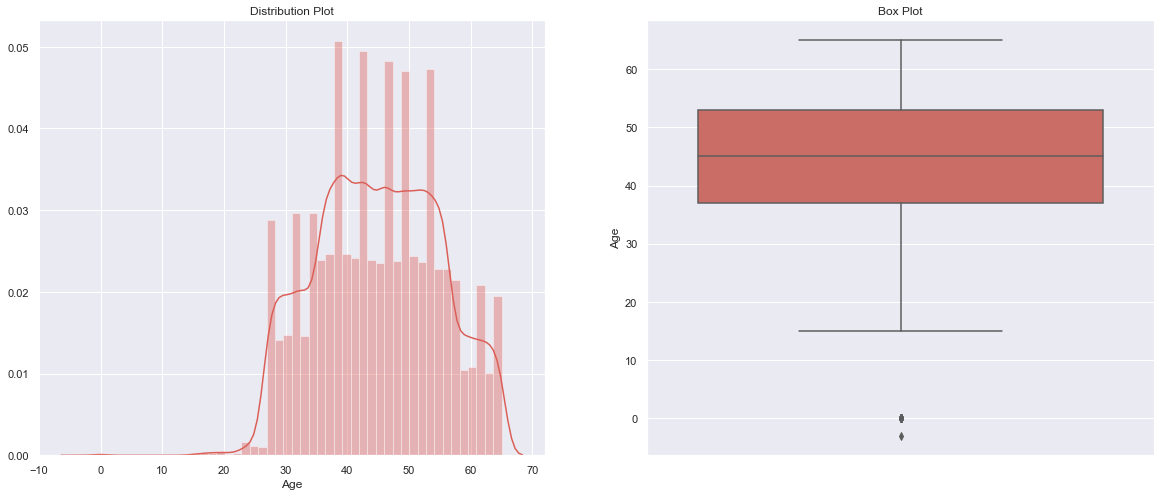

In [43]:
#Analyze the plots for the age Columns

draw_univariate_plot(demographic_df_final,"Age")

In [44]:
# Fetching the Applicants with age less than 18 

demographic_df_final[demographic_df_final.Age<18]

Application ID  Age Gender Marital Status (at the time of application)  \
74          975085624   17      M                                      Single   
250          15988053   17      M                                      Single   
274         553384326   17      M                                      Single   
283         490791674   15      F                                      Single   
313         584758872   16      M                                      Single   
385         149528904   15      M                                      Single   
484         588417745   16      M                                     Married   
504         568773679   17      M                                      Single   
548         920083644   16      M                                     Married   
623         842745102   17      M                                     Married   
626         505345414   17      F                                     Married   
678         326621134   16      M                                     Married   
722         256752828   15      M                                     Married   
725         483332934   17      F                                     Married   
745         535285757   16      M                                     Married   
746         701653071   15      F                                      Single   
774         440605214   15      M                                     Married   
818         910506404   15      M                                      Single   
860         134951209   16      M                                      Single   
911         783913343   17      F                                     Married   
924         601969470   15      F                                      Single   
941         717434244   16      M                                      Single   
975         534251279   16      F                                      Single   
1008        371030845   15      M                                     Married   
1010        410153337   15      F                                      Single   
1027        431350709   17      M                                     Married   
1056        403119279   17      F                                     Married   
1062        805308826   17      M                                     Married   
1147        322139302   15      M                                     Married   
1178        130064793   16      M                                      Single   
...               ...  ...    ...                                         ...   
4028        339076142   17      M                                      Single   
4048        812365997   17      F                                     Married   
4134        773171568   17      M                                     Married   
4185        327723491   17      F                                      Single   
4311        622880517   17      M                                     Married   
4367        745462418   17      F                                      Single   
4421        381342630   17      F                                     Married   
4589         89770640   17      M                                     Married   
4633         13167456   17      M                                     Married   
4656        705529178   17      M                                     Married   
9111        964427213    0      M                                     Married   
16315       634180637   -3      M                                     Married   
20752       590303560    0      M                                     Married   
29929       492869740    0      M                                      Single   
34548       932483616    0      M                                     Married   
35606       666398799    0      F                                     Married   
44090       790296430    0      M                                      Single   
50153       463622314    0      M     

In [45]:
# Total Applicants below Age 18 are
len(demographic_df_final[demographic_df_final.Age<18].index)

65

In [46]:
# Cleaing Activity - Removing the outlier less than 18 age

demographic_df_final=demographic_df_final[demographic_df_final.Age>17]
demographic_df_final.shape

(71224, 12)

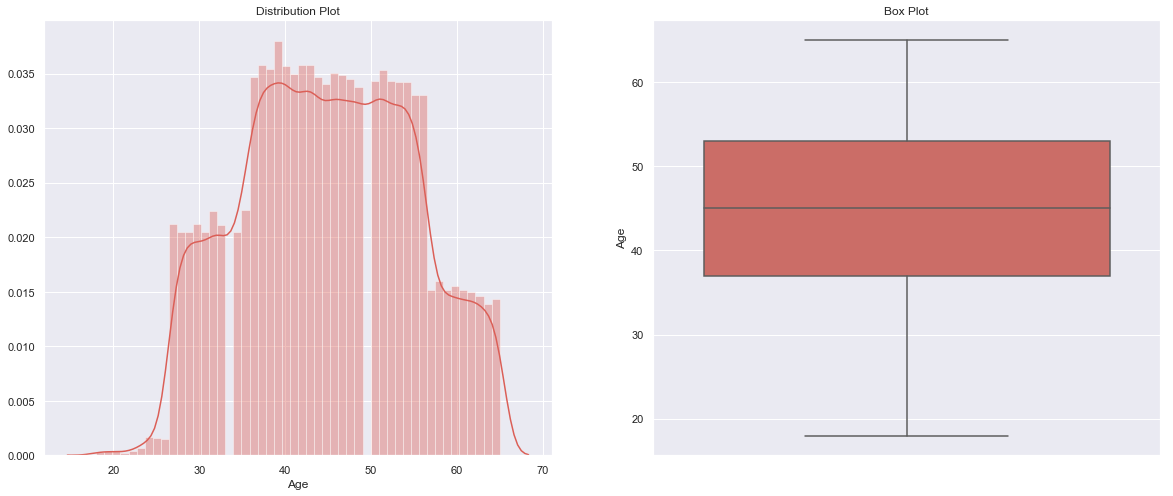

In [47]:
#Analyze the plots for the age Columns again after removing the outliers

draw_univariate_plot(demographic_df_final,"Age")

### Univariate Analysis for  Gender

In [48]:
# Frequency of the Applicants based on the Gender
get_column_frequency(demographic_df_final.Gender)

Gender
M     54402
F     16821
NaN       1

In [49]:
# Cleaning Acvitivity - Nulls is imputed with Male 
demographic_df_final['Gender'].replace(np.nan,"M",inplace= True)

In [50]:
# Frequency of the Applicants based on the age
get_column_frequency(demographic_df_final.Gender)

Gender
M   54403
F   16821

### Univariate Analysis on Marital Status (at the time of application)

In [51]:
# Frequency of the Applicants based on the Marital Status

get_column_frequency(demographic_df_final['Marital Status (at the time of application)'])

Marital Status (at the time of application)
Married                                        60685
Single                                         10534
NaN                                                5

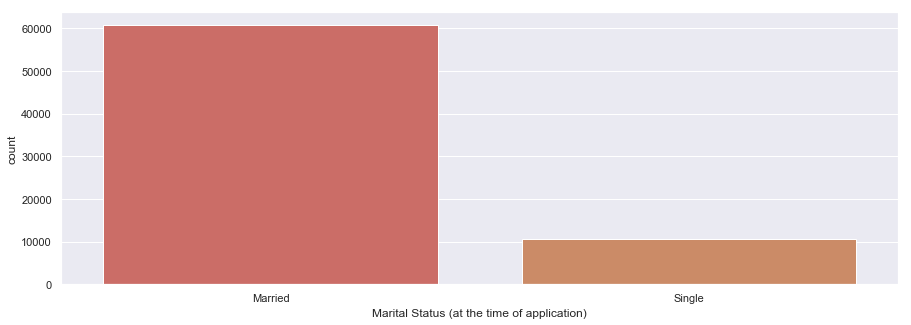

In [52]:
# Plotting count across a categorical variable 
draw_countplot(demographic_df_final,"Marital Status (at the time of application)")

In [53]:
# Cleanup Activity - Replacing 5 Missing values in Marital Status column with Single category

demographic_df_final['Marital Status (at the time of application)'].replace(np.nan,"Single",inplace= True)

In [54]:
# Frequency of the Applicants based on the Marital Status

get_column_frequency(demographic_df_final['Marital Status (at the time of application)'])

Marital Status (at the time of application)
Married                                        60685
Single                                         10539

### Univariate Analysis on No of dependents feature

In [55]:
# Frequency of the Applicants based on the 'No of dependents'

get_column_frequency(demographic_df_final['No of dependents'])

No of dependents
 3.0             16260
 1.0             15369
 2.0             15265
 4.0             12216
 5.0             12112
NaN                  2

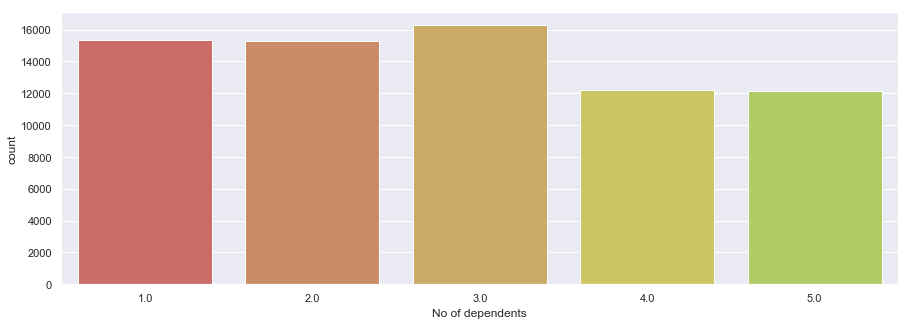

In [56]:
# Plotting count across a categorical variable 

draw_countplot(demographic_df_final,"No of dependents")

In [57]:
# Cleaning Activity - Imputing 2 missing value with No Of Dependents feature

demographic_df_final['No of dependents'].replace(np.nan,3,inplace= True)

In [58]:
# Frequency of the Applicants based on the 'No of dependents' after imputing

get_column_frequency(demographic_df_final['No of dependents'])

No of dependents
3.0             16262
1.0             15369
2.0             15265
4.0             12216
5.0             12112

### Univariate Analysis on Income

In [59]:
# Frequency of the Applicants based on the 'Income' 

get_column_frequency(demographic_df_final['Income'])

Income
 4.5     5230
 31.0    1448
 33.0    1445
 23.0    1442
 26.0    1441
 35.0    1439
 20.0    1437
 17.0    1404
 15.0    1402
 21.0    1396
 6.0     1396
 10.0    1390
 22.0    1389
 37.0    1382
 39.0    1379
 16.0    1375
 28.0    1374
 29.0    1373
 19.0    1370
 32.0    1365
 41.0    1363
 13.0    1363
 11.0    1359
 8.0     1349
 25.0    1348
 44.0    1346
 27.0    1343
 30.0    1341
 9.0     1339
 40.0    1330
...       ...
 7.0     1321
 38.0    1318
 36.0    1314
 14.0    1314
 12.0    1299
 24.0    1299
 45.0    1297
 5.0     1291
 42.0    1255
 46.0     931
 50.0     858
 49.0     857
 47.0     854
 48.0     838
 52.0     660
 55.0     655
 54.0     636
 53.0     624
 51.0     599
 56.0     534
 57.0     512
 59.0     497
 58.0     478
 60.0     449
-0.5       80
 4.0       40
 0.0       26
 3.0       23
 1.0       18
 2.0        9

[63 rows x 1 columns]

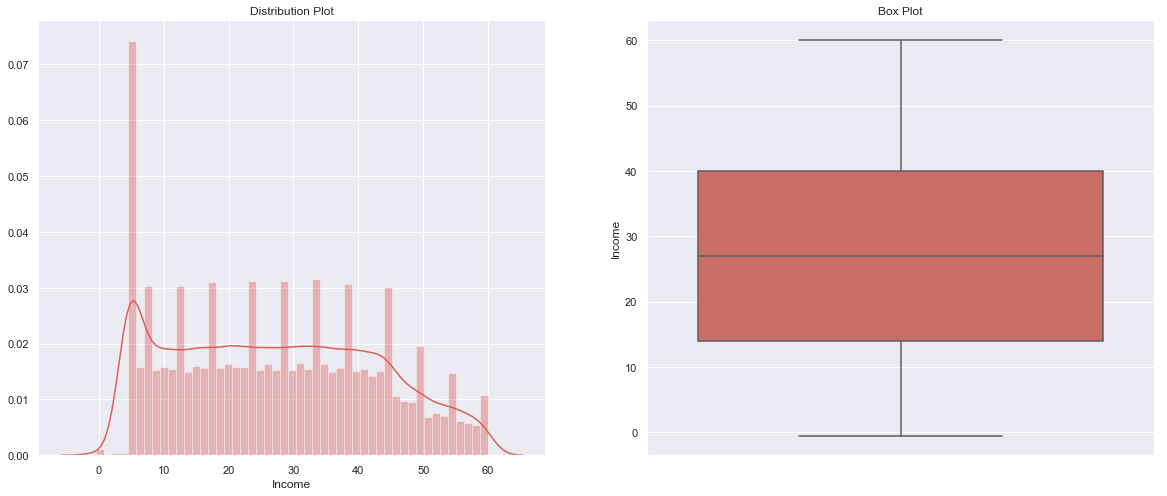

In [60]:
draw_univariate_plot(demographic_df_final,"Income")

In [61]:
# Count of the applicants having income less than or equal 0 
len(demographic_df_final[demographic_df_final.Income<=0].index)

106

In [62]:
demographic_df_final[demographic_df_final.Income<=0]

Application ID  Age Gender Marital Status (at the time of application)  \
964         450723469   34      M                                     Married   
1058         24806681   22      M                                      Single   
1222        729552057   40      M                                     Married   
1278        805216817   32      M                                     Married   
1288        547253197   64      M                                     Married   
1343        373963488   48      M                                     Married   
1463         60246058   35      M                                     Married   
1565        861750337   52      M                                     Married   
1620        342846642   51      M                                     Married   
1731        671827529   41      M                                     Married   
1742        949700642   63      M                                      Single   
1755        445625202   46      F                                     Married   
1838        492426616   42      M                                      Single   
1864        856382859   34      M                                      Single   
1906         28529247   44      M                                     Married   
2001        376543424   35      M                                     Married   
2036        894546185   64      M                                     Married   
2043        281925114   32      M                                     Married   
2092        442521933   59      F                                     Married   
2126         72233026   65      M                                     Married   
2167        960040452   41      M                                     Married   
2223        129176358   45      M                                     Married   
2228        211825480   65      M                                     Married   
2246        730568473   41      M                                     Married   
2255        113089921   48      M                                     Married   
2381        909433618   54      M                                     Married   
2423        872069864   39      M                                     Married   
2528        220535428   42      F                                     Married   
2592        677808152   45      M                                      Single   
2599        926447901   35      M                                     Married   
...               ...  ...    ...                                         ...   
4139        998321323   43      M                                     Married   
4205        472741744   38      F                                     Married   
4213        562002069   35      M                                      Single   
4232        167737137   42      M                                     Married   
4259        621161091   33      F                                     Married   
4272        456708069   20      M                                     Married   
4279        151708319   45      F                                     Married   
4313        180723350   49      M                                     Married   
4330        563817048   26      F                                     Married   
4355        113741159   31      F                                     Married   
4395        552549350   19      F                                     Married   
4418         98920562   43      M                                     Married   
4522        335154728   39      M                                     Married   
4533        395613862   53      M                                     Married   
4624        278797628   48      M                                     Married   
4642        226478216   32      M                                     Married   
4681        315581350   40      M                                     Married   
4684        182508594   37      M     

In [63]:
# Cleaning Activity - Cant impute value in this ,hence removing the records

demographic_df_final=demographic_df_final[demographic_df_final.Income>0]

In [64]:
# Analyse the shape of Dataframe fter rmoving applicant having Income <=0
demographic_df_final.shape

(71118, 12)

### Univariate Analysis on Education

In [65]:
get_column_frequency(demographic_df_final['Education'])

Education
Professional      24759
Masters           23922
Bachelor          17661
Phd                4537
Others              120
NaN                 119

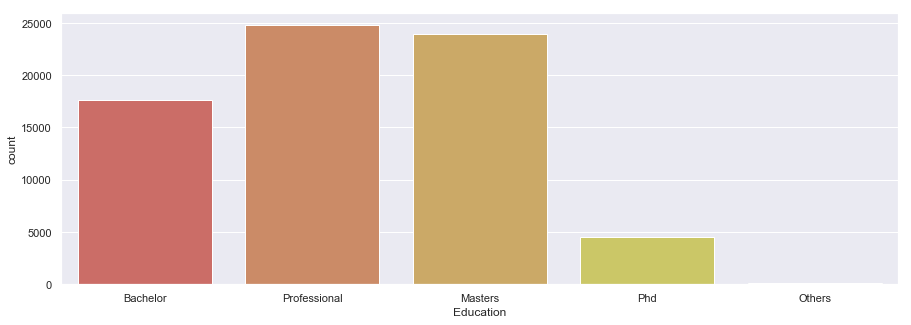

In [66]:
# Plotting count across a categorical variable 

draw_countplot(demographic_df_final,"Education")

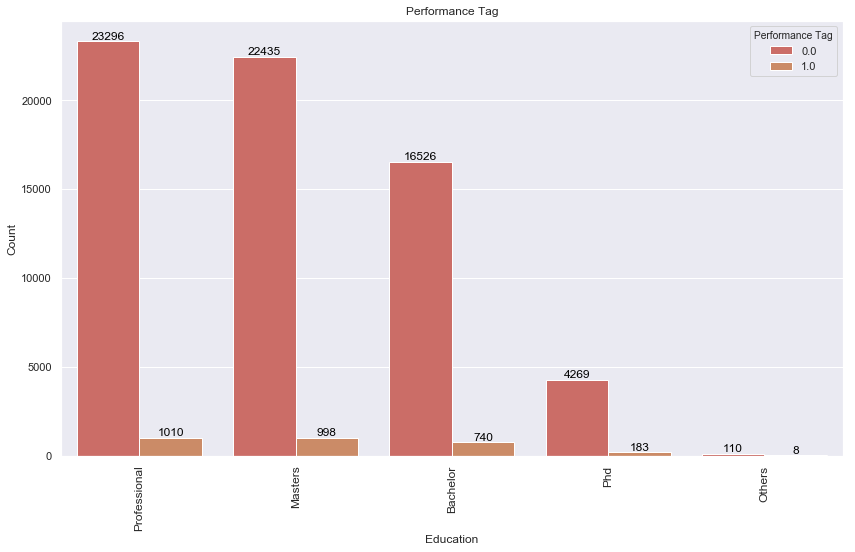

In [67]:
# Draw Graph w.r.t to the Performance Tag as this is our dependent columns

draw_plots(column_name='Education',title='Performance Tag',df=demographic_df_final,type_of_variable="Categorical",hue="Performance Tag")

In [68]:
# Cleaning Activity - Imputing NaN values with 'Other' for Education
demographic_df_final['Education'].replace(np.nan,"Others",inplace= True)

In [69]:
# Checking Missing Values count after imputation for Education Feature
get_column_frequency(demographic_df_final['Education'])

Education
Professional      24759
Masters           23922
Bachelor          17661
Phd                4537
Others              239

### Univariate Analysis on Profession

In [70]:
# Checking Missing Values count 
get_column_frequency(demographic_df_final['Profession'])

Profession
SAL           40338
SE_PROF       16492
SE            14276
NaN              12

INFO - 12 Missing values are present in the Profession Column

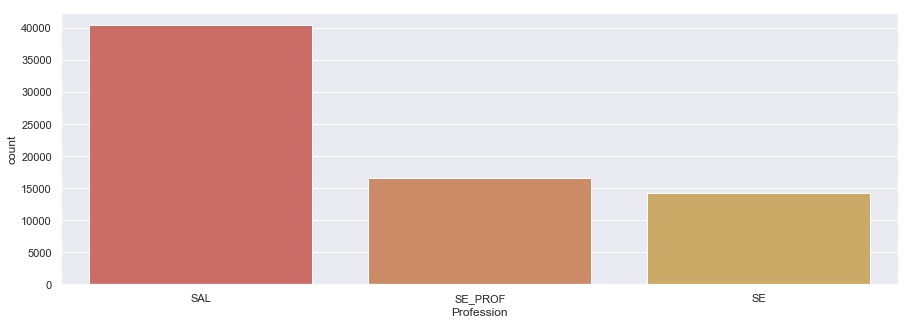

In [71]:
# Plotting count across a categorical variable 

draw_countplot(demographic_df_final,"Profession")

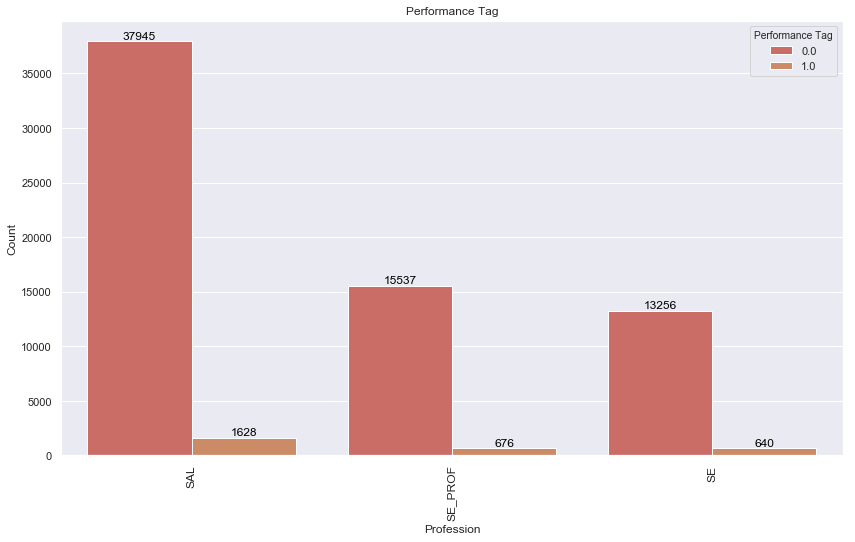

In [72]:
# Draw Graph w.r.t to the Performance Tag as this is our Profession columns

draw_plots(column_name='Profession',title='Performance Tag',df=demographic_df_final,type_of_variable="Categorical",hue="Performance Tag")

In [73]:
# Cleaning Activity - Replacing 12 missing values of Profession with SE
demographic_df_final['Profession'].replace(np.nan,"SE",inplace= True)

In [74]:
# Checking Missing Values count 
get_column_frequency(demographic_df_final['Profession'])

Profession
SAL           40338
SE_PROF       16492
SE            14288

### Univariate Analysis on Type of residence 

In [75]:
# Checking Missing Values count and frequenct 
get_column_frequency(demographic_df_final['Type of residence'])

Type of residence
Rented                           53285
Owned                            14198
Living with Parents               1802
Company provided                  1626
Others                             199
NaN                                  8

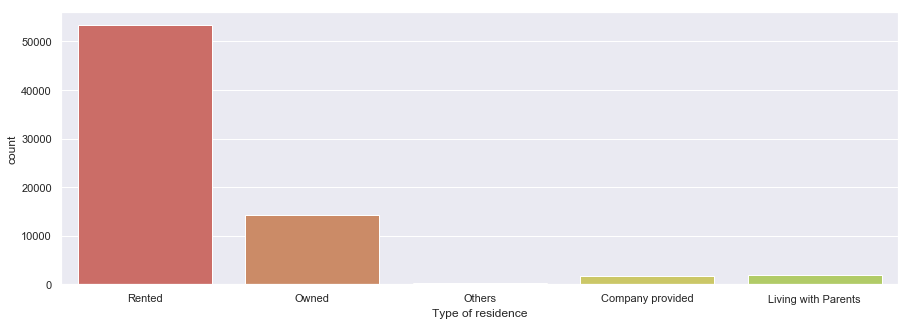

In [76]:
# Plotting count across a categorical variable 
draw_countplot(demographic_df_final,"Type of residence")

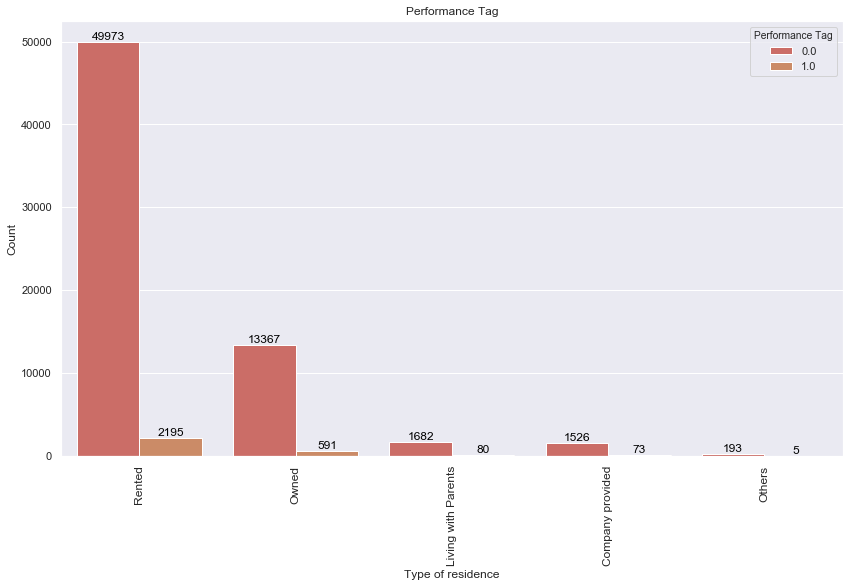

In [77]:
# Draw Graph w.r.t to the Performance Tag as this is our Type of residence columns

draw_plots(column_name='Type of residence',title='Performance Tag',df=demographic_df_final,type_of_variable="Categorical",hue="Performance Tag")

In [78]:
# Cleaning Activity - Imputing NaN values with Others category
demographic_df_final['Type of residence'].replace(np.nan,"Others",inplace= True)

In [79]:
# Checking Missing Values count and frequenct 
get_column_frequency(demographic_df_final['Type of residence'])

Type of residence
Rented                           53285
Owned                            14198
Living with Parents               1802
Company provided                  1626
Others                             207

### Univariate Analysis on No of months in current residence

In [80]:
# Checking Missing Values count and frequenct 
get_column_frequency(demographic_df_final['No of months in current residence'])

No of months in current residence
6                                33955
14                                 452
18                                 423
8                                  423
12                                 422
10                                 412
11                                 408
7                                  403
29                                 403
9                                  402
15                                 398
33                                 393
13                                 392
22                                 390
40                                 388
17                                 386
21                                 380
16                                 379
39                                 377
20                                 373
31                                 371
38                                 371
35                                 371
45                                 368
19                                 368
25                                 367
27                                 366
34                                 364
42                                 358
30                                 358
..                                 ...
98                                 279
99                                 277
105                                277
110                                277
89                                 276
115                                274
69                                 273
80                                 268
104                                268
90                                 267
96                                 264
111                                263
92                                 262
108                                260
97                                 260
113                                259
87                                 255
77                                 253
86                                 252
85                                 247
117                                199
122                                190
118                                185
119                                185
120                                182
121                                176
123                                156
126                                145
125                                140
124                                135

[121 rows x 1 columns]

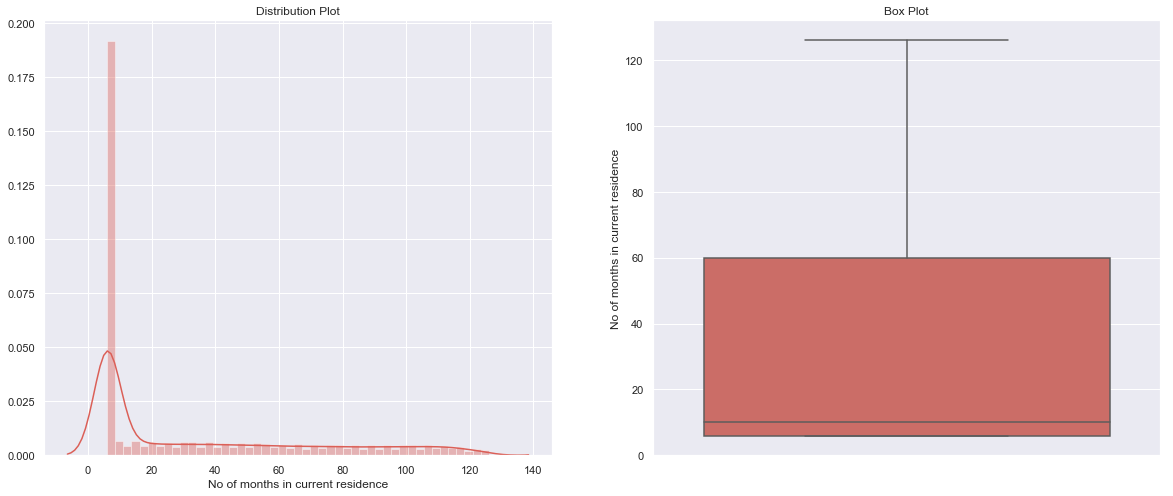

In [81]:
draw_univariate_plot(demographic_df_final,"No of months in current residence")

### Univariate analysis on Performance_Tag

In [82]:
# Checking Missing Values count 
get_column_frequency(demographic_df_final['Performance Tag'])

Performance Tag
 0.0            66749
 1.0             2944
NaN              1425

INFO - There are 1425 rows for which Performance Tag is missing

In [83]:
# Create another dataframe with rejected Applications 
rejected_demographic_df = demographic_df_final[np.isnan(demographic_df_final['Performance Tag'])]

In [84]:
# Cleaning Activity - Dropping Rows having NaN in Performance Tag, which means dropping applicants who has not used credit cards

demographic_df_final=demographic_df_final[~np.isnan(demographic_df['Performance Tag'])]


In [85]:
# Checking Missing Values count 
get_column_frequency(demographic_df_final['Performance Tag'])

Performance Tag
0.0            66749
1.0             2944

In [86]:
# Adding clone Column for Performance Tag with underscore for further usage
demographic_df_final['Performance_Tag']=demographic_df_final['Performance Tag']

### Now the EDA process is completed as we dont have any null values in Dataframe 

In [87]:
# Fetch the nulls summary of the whole dataset ordered by descending
get_nulls_report(demographic_df_final)

##  WOE imputation on Demographic Data starts here

In [88]:
## Calling the function to find the WOE value and the IV for the dataframe
final_iv, IV = woe_iv_generator(demographic_df_final,demographic_df_final.Performance_Tag)

In [89]:
#Analyse the dataframe , and we can see the WOE value been calculated for the bins which is automaticaly created

final_iv.head(10)

VAR_NAME  MIN_VALUE   MAX_VALUE  COUNT  \
0                               Application ID     100450   498064222  34847   
1                               Application ID  498066067  1000084142  34846   
2                                          Age         18          40  24518   
3                                          Age         41          50  22838   
4                                          Age         51          65  22337   
5                                       Gender          F           F  16468   
6                                       Gender          M           M  53225   
7  Marital Status (at the time of application)    Married     Married  59408   
8  Marital Status (at the time of application)     Single      Single  10285   
9                             No of dependents          1           3  45866   

    EVENT  EVENT_RATE  NONEVENT  NON_EVENT_RATE  DIST_EVENT  DIST_NON_EVENT  \
0  1478.0    0.042414   33369.0        0.957586    0.502038        0.499918   
1  1466.0    0.042071   33380.0        0.957929    0.497962        0.500082   
2  1069.0    0.043601   23449.0        0.956399    0.363111        0.351301   
3   958.0    0.041948   21880.0        0.958052    0.325408        0.327795   
4   917.0    0.041053   21420.0        0.958947    0.311481        0.320904   
5   718.0    0.043600   15750.0        0.956400    0.243886        0.235959   
6  2226.0    0.041822   50999.0        0.958178    0.756114        0.764041   
7  2500.0    0.042082   56908.0        0.957918    0.849185        0.852567   
8   444.0    0.043170    9841.0        0.956830    0.150815        0.147433   
9  1949.0    0.042493   43917.0        0.957507    0.662024        0.657942   

        WOE        IV  
0  0.004233  0.000018  
1 -0.004249  0.000018  
2  0.033066  0.000689  
3 -0.007310  0.000689  
4 -0.029803  0.000689  
5  0.033044  0.000345  
6 -0.010430  0.000345  
7 -0.003975  0.000090  
8  0.022682  0.000090  
9  0.006185  0.000074

In [90]:
# checking the Information Value for the Columns

IV.sort_values('IV')

VAR_NAME        IV
9                               Performance Tag  0.000000
1                                Application ID  0.000018
6                              No of dependents  0.000074
5   Marital Status (at the time of application)  0.000090
3                                        Gender  0.000345
2                                     Education  0.000535
0                                           Age  0.000689
11                            Type of residence  0.001072
10                                   Profession  0.002140
7               No of months in current company  0.010912
4                                        Income  0.038389
8             No of months in current residence  0.052715

## Replacing WOE values in the dataframe columns

In [91]:
demographic_df_final.columns

Index(['Application ID', 'Age', 'Gender',
       'Marital Status (at the time of application)', 'No of dependents',
       'Income', 'Education', 'Profession', 'Type of residence',
       'No of months in current residence', 'No of months in current company',
       'Performance Tag', 'Performance_Tag'],
      dtype='object')

In [92]:
original_column_list = demographic_df_final.columns.difference(['Performance_Tag'])

In [93]:
original_column_list

Index(['Age', 'Application ID', 'Education', 'Gender', 'Income',
       'Marital Status (at the time of application)', 'No of dependents',
       'No of months in current company', 'No of months in current residence',
       'Performance Tag', 'Profession', 'Type of residence'],
      dtype='object')

In [94]:
# tranforming the Dataframe with the WOE values from the bins of the columns 

transform_prefix = ''
for var in original_column_list:
    small_df = final_iv[final_iv['VAR_NAME'] == var]
    transform_dict = dict(zip(small_df.MAX_VALUE,small_df.WOE))
    replace_cmd = ''
    replace_cmd1 = ''
    for i in sorted(transform_dict.items()):
        replace_cmd = replace_cmd + str(i[1]) + str(' if x <= ') + str(i[0]) + ' else '
        replace_cmd1 = replace_cmd1 + str(i[1]) + str(' if x == "') + str(i[0]) + '" else '
    replace_cmd = replace_cmd + '0'
    replace_cmd1 = replace_cmd1 + '0'
    if replace_cmd != '0':
        try:
            demographic_df_final[transform_prefix + var] = demographic_df_final[var].apply(lambda x: eval(replace_cmd))
        except:
            demographic_df_final[transform_prefix + var] = demographic_df_final[var].apply(lambda x: eval(replace_cmd1))

In [95]:
# Checking Distinct Values in the Age Column now
get_column_frequency(demographic_df_final['Age'])

Age
 0.033066  24518
-0.007310  22838
-0.029803  22337

In [96]:
# Checking Distinct Values in the Education Column now
get_column_frequency(demographic_df_final['Education'])

Education
-0.017161      24306
 0.008546      23433
 0.015130      17266
-0.028479       4452
 0.278948        236

In [97]:
# Checking Distinct Values in the Age Column now
get_column_frequency(demographic_df_final['Profession'])

Profession
-0.027615       39573
-0.013616       16213
 0.089603       13907

In [98]:
#Analysing the dataframe in general overies

demographic_df_final.head()

Application ID       Age    Gender  \
0       -0.004249 -0.007310  0.033044   
1        0.004233  0.033066 -0.010430   
2       -0.004249  0.033066 -0.010430   
3        0.004233 -0.007310 -0.010430   
4        0.004233  0.033066  0.033044   

   Marital Status (at the time of application)  No of dependents    Income  \
0                                    -0.003975          0.006185 -0.245691   
1                                    -0.003975         -0.012005 -0.263913   
2                                     0.022682          0.006185 -0.263913   
3                                    -0.003975          0.006185 -0.263913   
4                                    -0.003975         -0.012005 -0.245691   

   Education  Profession  Type of residence  \
0   0.015130   -0.027615          -0.004131   
1  -0.017161   -0.013616          -0.004131   
2   0.015130   -0.013616          -0.004131   
3   0.015130    0.089603          -0.004131   
4  -0.017161   -0.027615          -0.004131   

   No of months in current residence  No of months in current company  \
0                           0.208381                        -0.122937   
1                           0.208381                        -0.073353   
2                           0.208381                        -0.073353   
3                           0.208381                        -0.122937   
4                           0.208381                        -0.073353   

   Performance Tag  Performance_Tag  
0              0.0              0.0  
1              0.0              0.0  
2              0.0              0.0  
3              0.0              0.0  
4              0.0              0.0

In [99]:
demographic_df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69693 entries, 0 to 71294
Data columns (total 13 columns):
Application ID                                 69693 non-null float64
Age                                            69693 non-null float64
Gender                                         69693 non-null float64
Marital Status (at the time of application)    69693 non-null float64
No of dependents                               69693 non-null float64
Income                                         69693 non-null float64
Education                                      69693 non-null float64
Profession                                     69693 non-null float64
Type of residence                              69693 non-null float64
No of months in current residence              69693 non-null float64
No of months in current company                69693 non-null float64
Performance Tag                                69693 non-null float64
Performance_Tag                                6969

##### We have removed few records during the cleaning Activity 

In [100]:
# Total records removed post cleaning activity in terms of percentages are
(len(demographic_df_final.index)/71301)*100

97.74477216308327

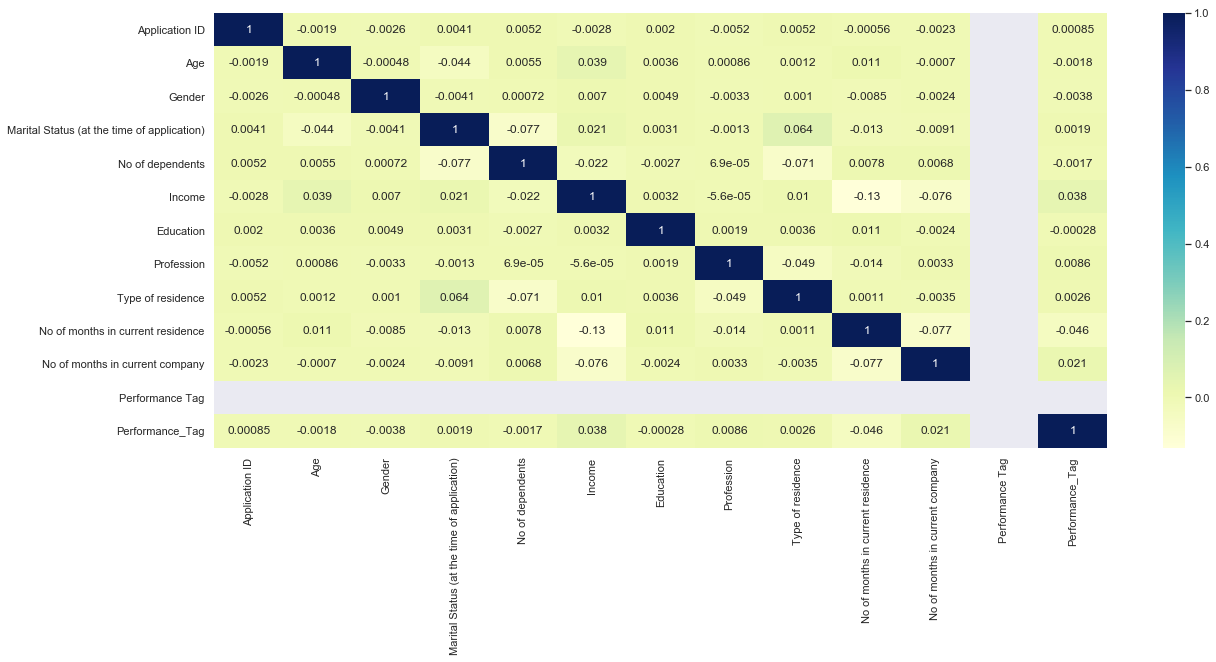

In [101]:
#Check of Correlation with the help of Heat Map

plt.figure(figsize = (20,8)) 
sns.heatmap(demographic_df_final.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1), annot=True,cmap="YlGnBu")
plt.show()


### Outlier Detection and treatment

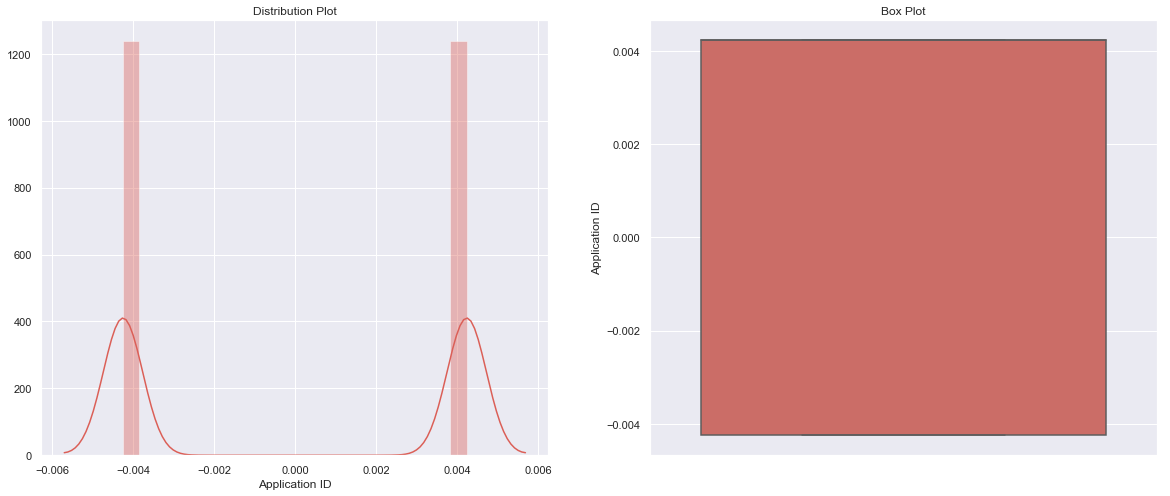

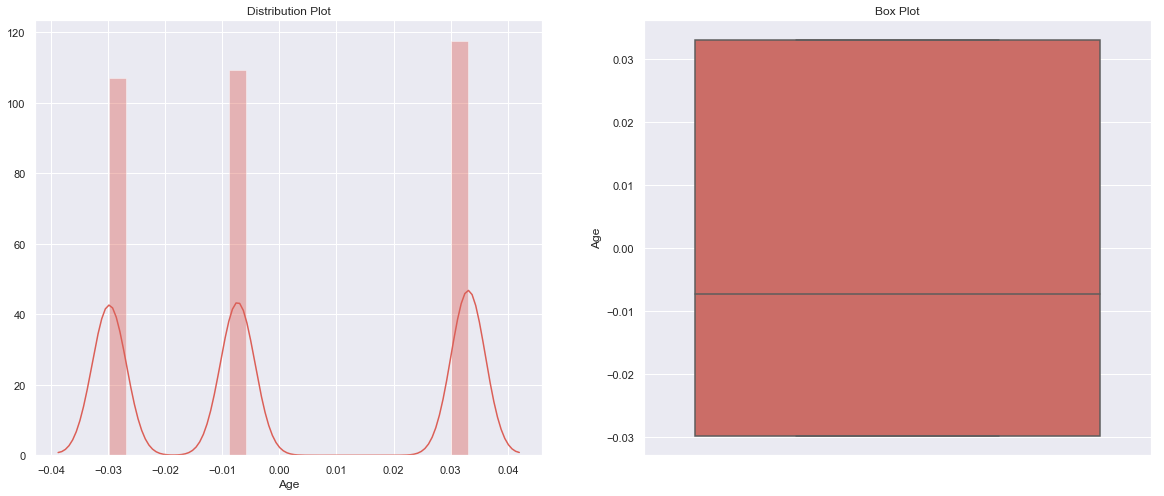

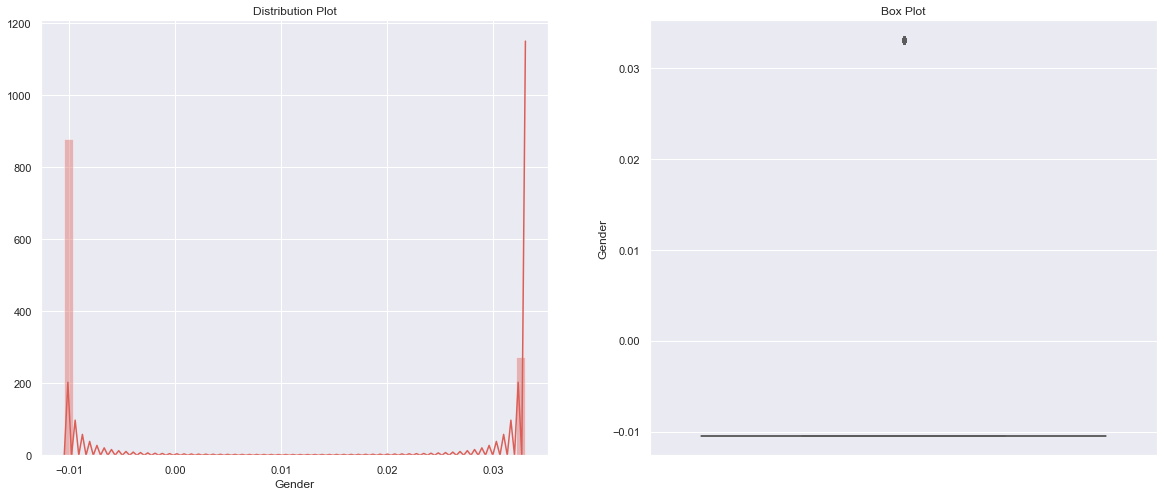

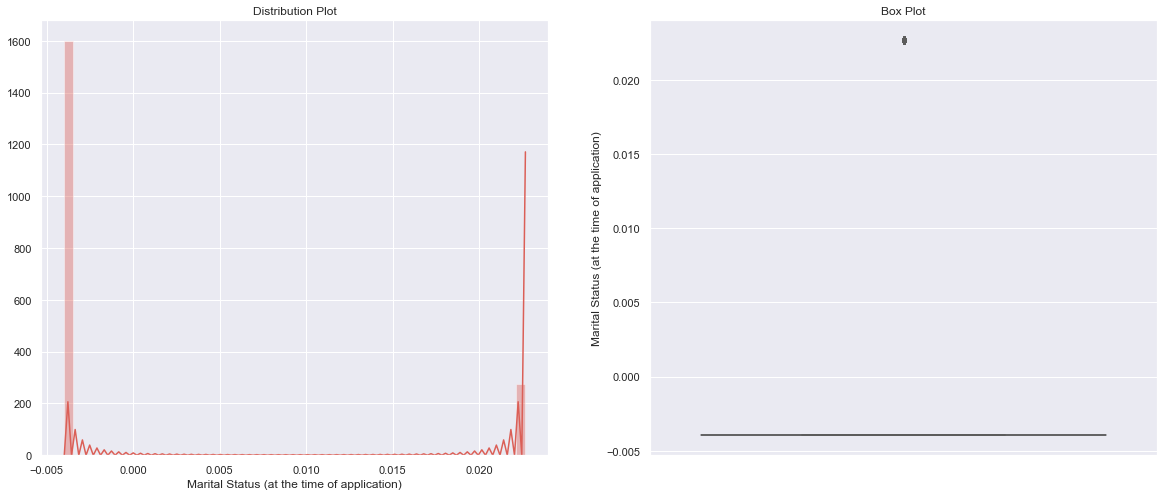

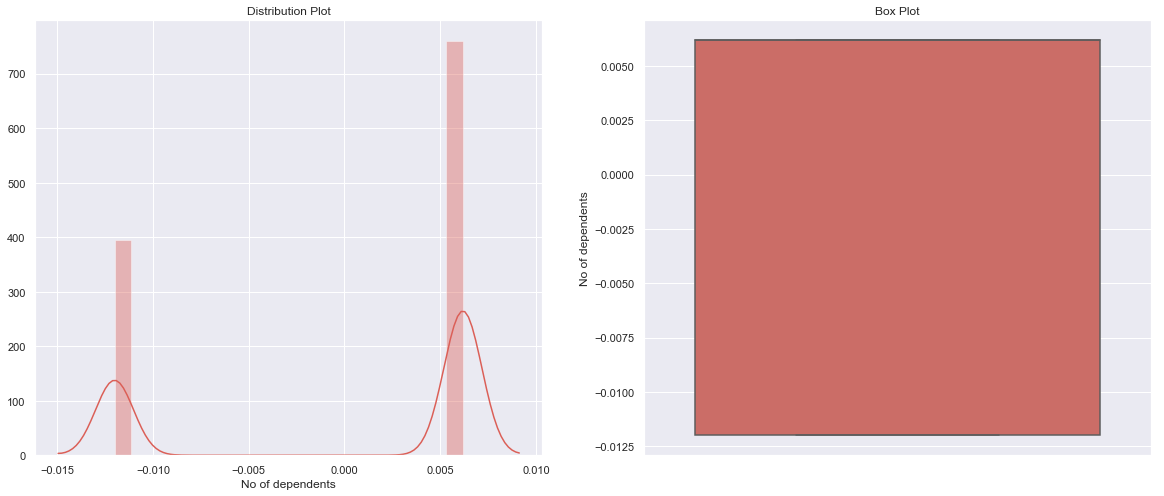

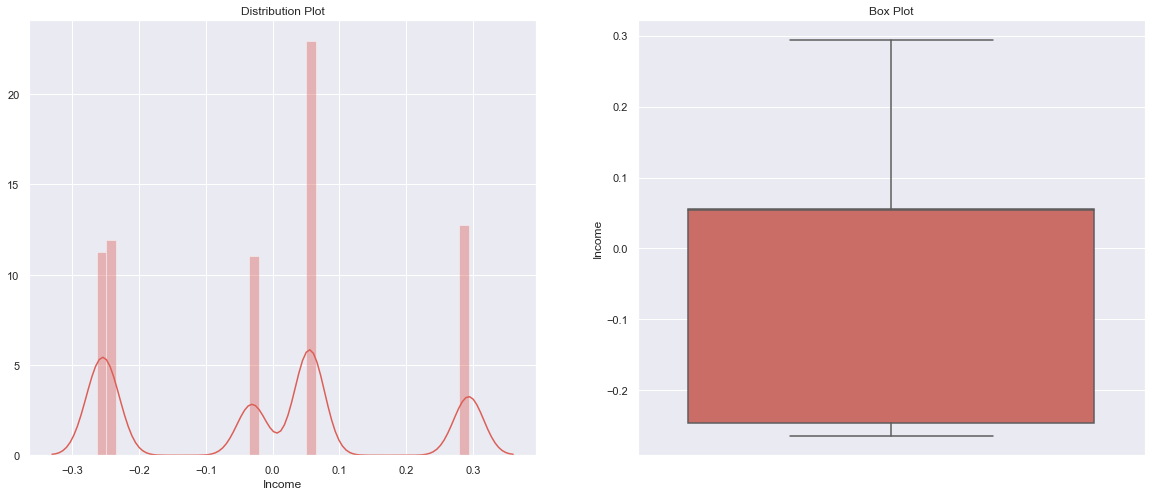

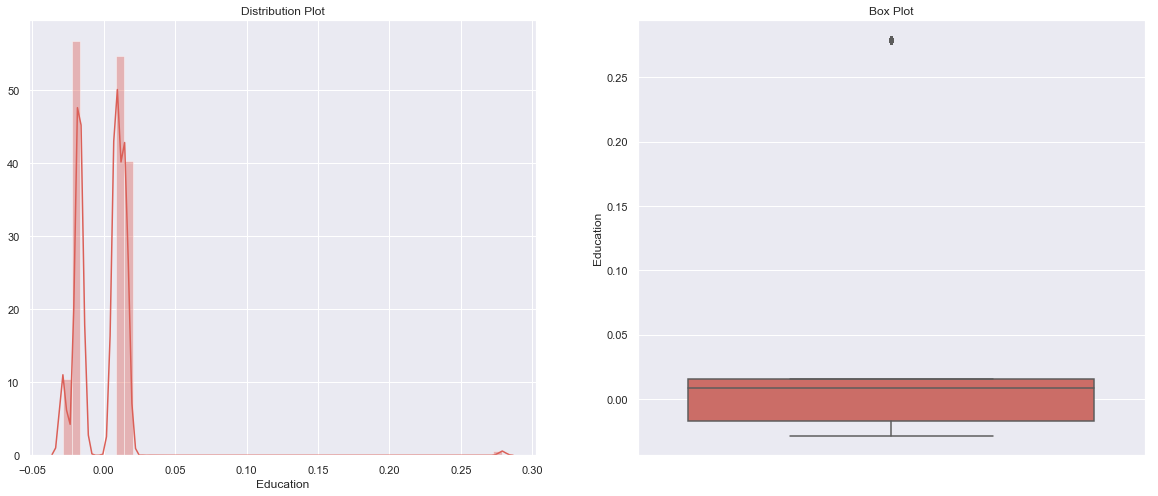

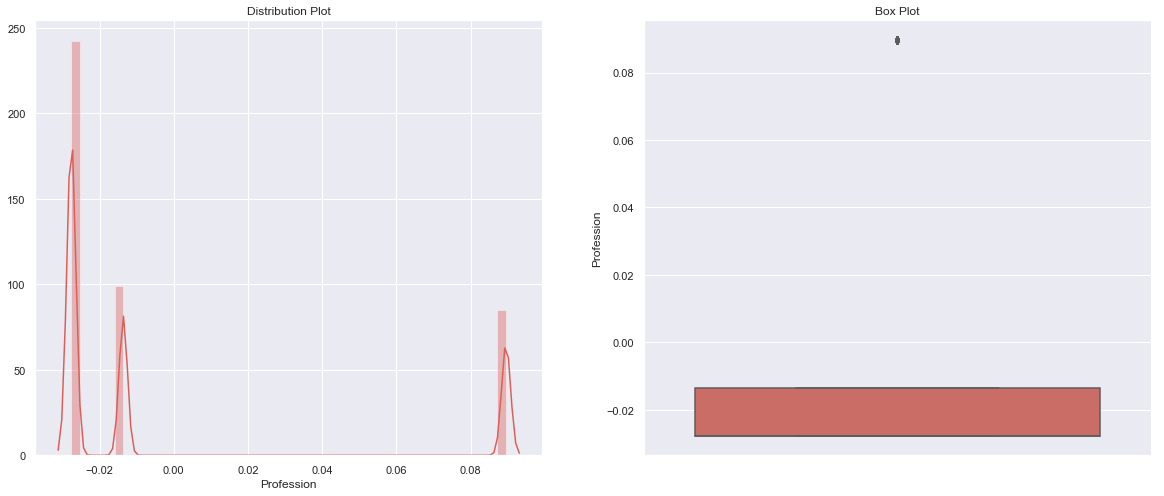

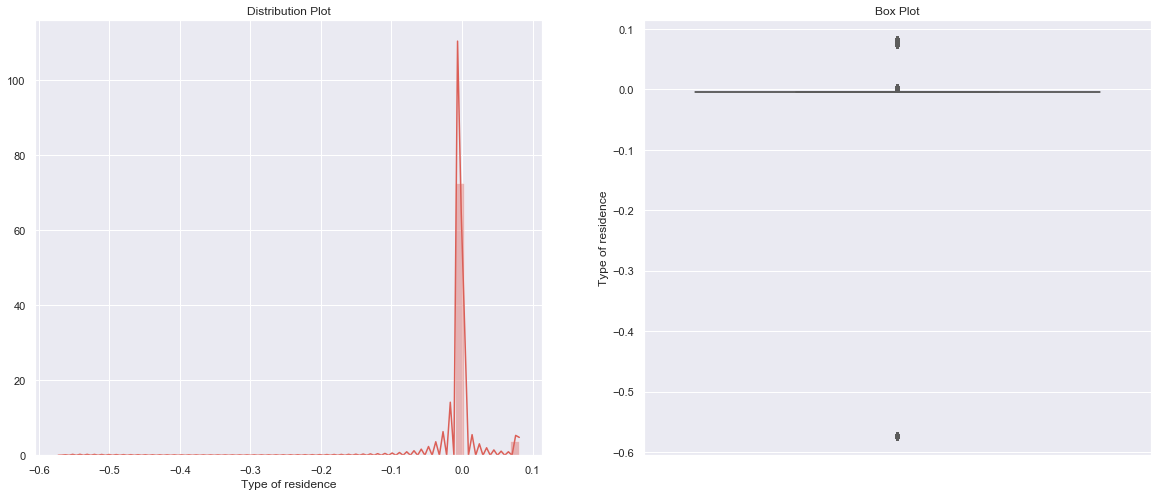

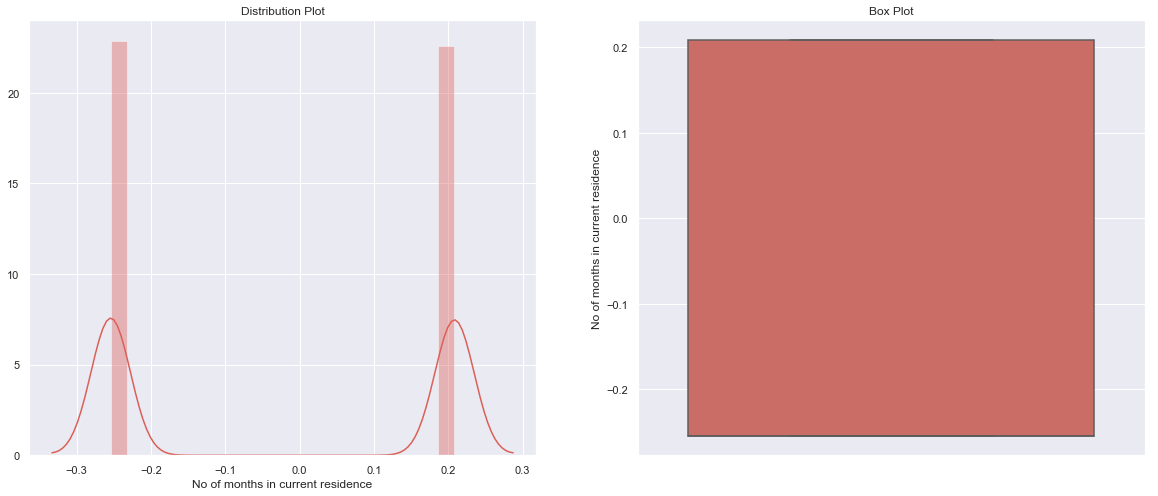

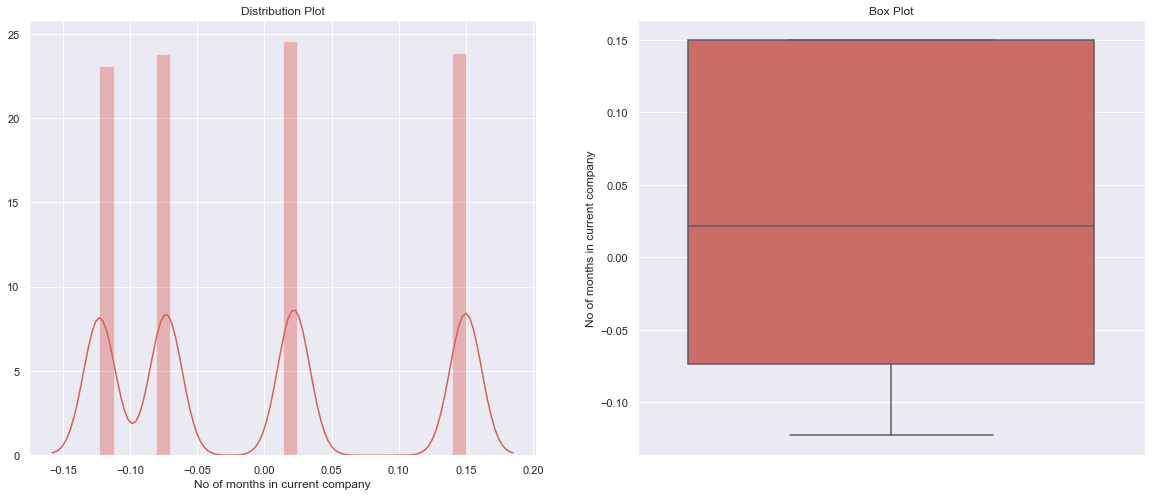

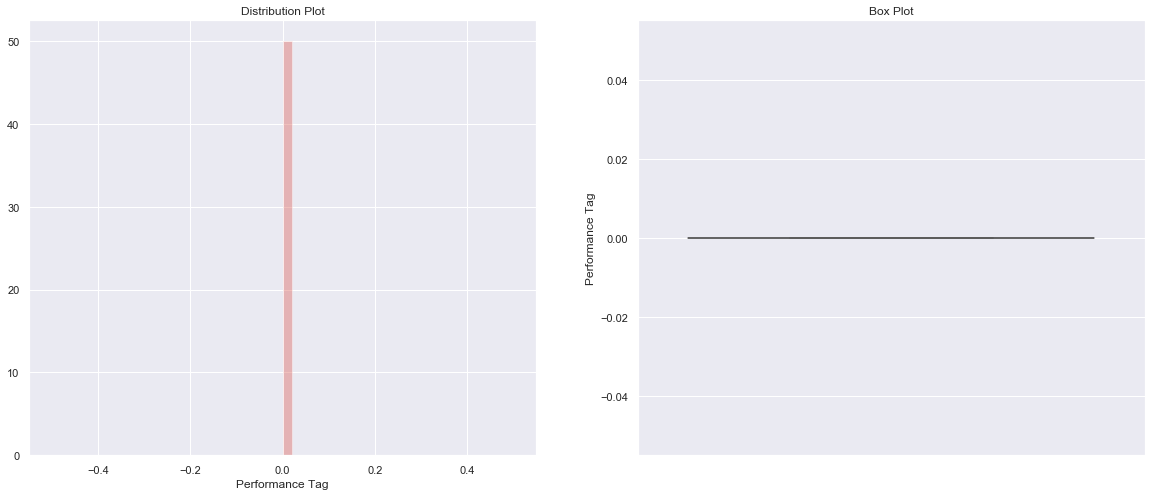

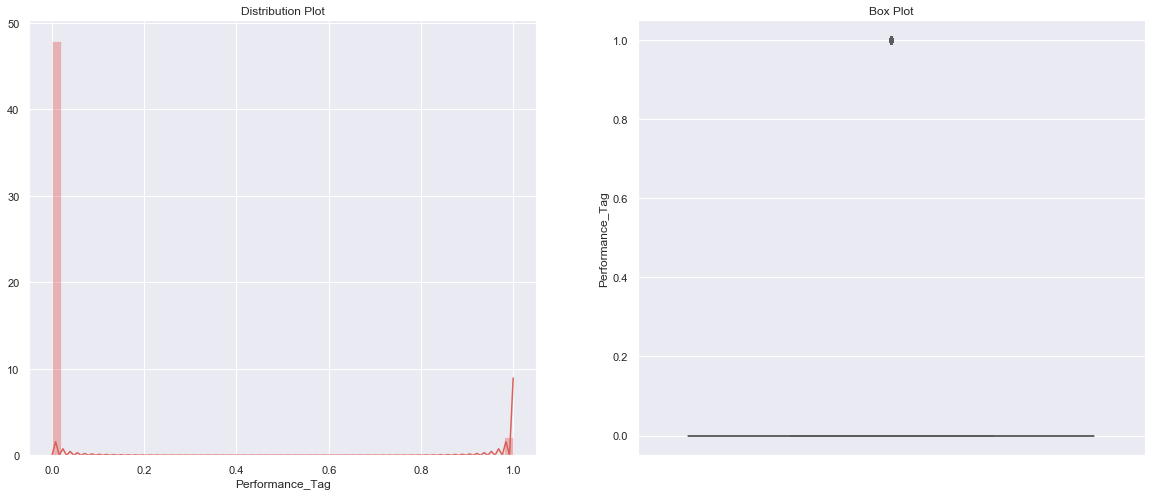

In [102]:
draw_numeric_plot(demographic_df_final)

In [103]:
# Checking outliers at 25%, 50%, 75%, 90%, 95% and 99%
demographic_df_final.describe(percentiles=[.25, .5, .75, .90, .95, .99])

Application ID           Age        Gender  \
count    69693.000000  69693.000000  69693.000000   
mean        -0.000008     -0.000315     -0.000157   
std          0.004241      0.026206      0.018468   
min         -0.004249     -0.029803     -0.010430   
25%         -0.004249     -0.029803     -0.010430   
50%          0.004233     -0.007310     -0.010430   
75%          0.004233      0.033066     -0.010430   
90%          0.004233      0.033066      0.033044   
95%          0.004233      0.033066      0.033044   
99%          0.004233      0.033066      0.033044   
max          0.004233      0.033066      0.033044   

       Marital Status (at the time of application)  No of dependents  \
count                                 69693.000000      69693.000000   
mean                                     -0.000041         -0.000034   
std                                       0.009455          0.008629   
min                                      -0.003975         -0.012005   
25%                                      -0.003975         -0.012005   
50%                                      -0.003975          0.006185   
75%                                      -0.003975          0.006185   
90%                                       0.022682          0.006185   
95%                                       0.022682          0.006185   
99%                                       0.022682          0.006185   
max                                       0.022682          0.006185   

             Income     Education    Profession  Type of residence  \
count  69693.000000  69693.000000  69693.000000       69693.000000   
mean      -0.017535     -0.000238     -0.000968          -0.000524   
std        0.195203      0.022344      0.045578           0.035756   
min       -0.263913     -0.028479     -0.027615          -0.572697   
25%       -0.245691     -0.017161     -0.027615          -0.004131   
50%        0.054396      0.008546     -0.027615          -0.004131   
75%        0.056177      0.015130     -0.013616          -0.004131   
90%        0.293682      0.015130      0.089603           0.002442   
95%        0.293682      0.015130      0.089603           0.002442   
99%        0.293682      0.015130      0.089603           0.081224   
max        0.293682      0.278948      0.089603           0.081224   

       No of months in current residence  No of months in current company  \
count                       69693.000000                     69693.000000   
mean                           -0.024331                        -0.004963   
std                             0.231233                         0.103574   
min                            -0.254090                        -0.122937   
25%                            -0.254090                        -0.073353   
50%                            -0.254090                         0.021834   
75%                             0.208381                         0.149911   
90%                             0.208381                         0.149911   
95%                             0.208381                         0.149911   
99%                             0.208381                         0.149911   
max                             0.208381                         0.149911   

       Performance Tag  Performance_Tag  
count          69693.0     69693.000000  
mean               0.0         0.042242  
std                0.0         0.201143  
min                0.0         0.000000  
25%                0.0         0.000000  
50%                0.0         0.000000  
75%                0.0         0.000000  
90%                0.0         0.000000  
95%                0.0         0.000000  
99%                0.0         1.000000  
max                0.0         1.000000

In [104]:
### Find the total non defaults in the dataframe
Non_Defaulted = ((len(demographic_df_final['Performance_Tag'].index)-sum(demographic_df_final['Performance_Tag']))/len(demographic_df_final['Performance_Tag'].index))*100
print("Total Percentage of the Non_Defaulted are ",Non_Defaulted)

Total Percentage of the Non_Defaulted are  95.7757594019


## Starting with the model Creation using the current dataframe after 

In [105]:
# Import library to split the dataset into test and train
from sklearn.model_selection import train_test_split

In [106]:
# Seperating the Feature Variable

X = demographic_df_final.drop(['Performance Tag', 'Performance_Tag', 'Application ID'], axis=1)


In [107]:
# Putting response variable to y

y = demographic_df_final['Performance_Tag']

In [108]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

In [109]:
# Fetch the null report on the Train Df
get_nulls_report(X_train)

# Logistic regression using RFE

In [110]:
# Model 1 - Logistic Regression
logm1 = fit_GLM(sm.add_constant(X_train),y_train)

                 Generalized Linear Model Regression Results                  
Dep. Variable:        Performance_Tag   No. Observations:                48785
Model:                            GLM   Df Residuals:                    48774
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -8474.1
Date:                Sun, 22 Dec 2019   Deviance:                       16948.
Time:                        11:40:12   Pearson chi2:                 4.89e+04
No. Iterations:                     6                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                          -3.1165      0.023

In [111]:
# Import libraries for Logistic regression
from sklearn.linear_model import LogisticRegression

In [112]:
logreg = LogisticRegression()

#### RFE - Recursive Feature Elimination

In [113]:
from sklearn.feature_selection import RFE
rfe = RFE(logreg, 10)             # running RFE with 10 variables as output
rfe = rfe.fit(X_train, y_train)

In [114]:
rfe.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [115]:
#View the list of columns and their ranking based on RFE output
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('Age', True, 1),
 ('Gender', True, 1),
 ('Marital Status (at the time of application)', True, 1),
 ('No of dependents', True, 1),
 ('Income', True, 1),
 ('Education', True, 1),
 ('Profession', True, 1),
 ('Type of residence', True, 1),
 ('No of months in current residence', True, 1),
 ('No of months in current company', True, 1)]

In [116]:
#columns that are supported
col = X_train.columns[rfe.support_]

In [117]:
# 10 features are selected from RFE based on the ranking
print(col)

Index(['Age', 'Gender', 'Marital Status (at the time of application)',
       'No of dependents', 'Income', 'Education', 'Profession',
       'Type of residence', 'No of months in current residence',
       'No of months in current company'],
      dtype='object')


In [118]:
X_train.columns[~rfe.support_]

Index([], dtype='object')

In [119]:
#Another Model with RFE features
X_train_sm = sm.add_constant(X_train[col])
logm2 = fit_GLM(X_train_sm[col],y_train)

                 Generalized Linear Model Regression Results                  
Dep. Variable:        Performance_Tag   No. Observations:                48785
Model:                            GLM   Df Residuals:                    48775
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -33249.
Date:                Sun, 22 Dec 2019   Deviance:                       66499.
Time:                        11:40:13   Pearson chi2:                 4.88e+04
No. Iterations:                     4                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Age                                            -0.1866      0.364

#### Starting Eliminating the features one by one by looking to the P values and VIF

In [120]:
# Dropping the No of Dependents column with high p value.
X_train_sm = X_train_sm.drop(['No of dependents'],axis=1)
col = X_train_sm.columns
print(col)

Index(['const', 'Age', 'Gender', 'Marital Status (at the time of application)',
       'Income', 'Education', 'Profession', 'Type of residence',
       'No of months in current residence', 'No of months in current company'],
      dtype='object')


In [121]:
# Model 3
logm2 = fit_GLM(X_train_sm,y_train)

                 Generalized Linear Model Regression Results                  
Dep. Variable:        Performance_Tag   No. Observations:                48785
Model:                            GLM   Df Residuals:                    48775
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -8474.2
Date:                Sun, 22 Dec 2019   Deviance:                       16948.
Time:                        11:40:13   Pearson chi2:                 4.90e+04
No. Iterations:                     6                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                          -3.1164      0.023

In [122]:
# Check the VIF values less than 5
getVIF(X_train_sm)

Features   VIF
1                                          Age  1.06
3  Marital Status (at the time of application)  1.05
4                                       Income  1.03
8            No of months in current residence  1.03
0                                        const  1.02
7                            Type of residence  1.01
9              No of months in current company  1.01
2                                       Gender  1.00
5                                    Education  1.00
6                                   Profession  1.00

In [123]:
# Drop Age with highest P value among all 
X_train_sm = X_train_sm.drop(['Age'], axis = 1)
col = X_train_sm.columns
print(col)

Index(['const', 'Gender', 'Marital Status (at the time of application)',
       'Income', 'Education', 'Profession', 'Type of residence',
       'No of months in current residence', 'No of months in current company'],
      dtype='object')


In [124]:
# Model 3
logm3 = fit_GLM(X_train_sm,y_train)

                 Generalized Linear Model Regression Results                  
Dep. Variable:        Performance_Tag   No. Observations:                48785
Model:                            GLM   Df Residuals:                    48776
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -8474.4
Date:                Sun, 22 Dec 2019   Deviance:                       16949.
Time:                        11:40:14   Pearson chi2:                 4.90e+04
No. Iterations:                     6                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                          -3.1163      0.023

In [125]:
# Again dropping Martial Status with high P value
X_train_sm = X_train_sm.drop(['Marital Status (at the time of application)'], axis = 1)
col = X_train_sm.columns
print(col)

Index(['const', 'Gender', 'Income', 'Education', 'Profession',
       'Type of residence', 'No of months in current residence',
       'No of months in current company'],
      dtype='object')


In [126]:
# Model 4
logm4 = fit_GLM(X_train_sm,y_train)

                 Generalized Linear Model Regression Results                  
Dep. Variable:        Performance_Tag   No. Observations:                48785
Model:                            GLM   Df Residuals:                    48777
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -8474.6
Date:                Sun, 22 Dec 2019   Deviance:                       16949.
Time:                        11:40:14   Pearson chi2:                 4.90e+04
No. Iterations:                     6                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -3.1162      0.023   -137.201      0.000      -3

In [127]:
# Again dropping the Gender column
X_train_sm = X_train_sm.drop(['Gender'], axis = 1)
col = X_train_sm.columns
print(col)

Index(['const', 'Income', 'Education', 'Profession', 'Type of residence',
       'No of months in current residence', 'No of months in current company'],
      dtype='object')


In [128]:
# Model 5
logm5 = fit_GLM(X_train_sm,y_train)

                 Generalized Linear Model Regression Results                  
Dep. Variable:        Performance_Tag   No. Observations:                48785
Model:                            GLM   Df Residuals:                    48778
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -8474.8
Date:                Sun, 22 Dec 2019   Deviance:                       16950.
Time:                        11:40:14   Pearson chi2:                 4.90e+04
No. Iterations:                     6                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -3.1163      0.023   -137.206      0.000      -3

In [129]:
# Again dropping the Education feature
X_train_sm = X_train_sm.drop(['Education'], axis = 1)
col = X_train_sm.columns
print(col)

Index(['const', 'Income', 'Profession', 'Type of residence',
       'No of months in current residence', 'No of months in current company'],
      dtype='object')


In [130]:
# Model 6
logm6 = fit_GLM(X_train_sm,y_train)

                 Generalized Linear Model Regression Results                  
Dep. Variable:        Performance_Tag   No. Observations:                48785
Model:                            GLM   Df Residuals:                    48779
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -8475.4
Date:                Sun, 22 Dec 2019   Deviance:                       16951.
Time:                        11:40:15   Pearson chi2:                 4.89e+04
No. Iterations:                     6                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -3.1163      0.023   -137.215      0.000      -3

In [131]:
# Again dropping the feature Profession
X_train_sm = X_train_sm.drop(['Profession'], axis = 1)
col = X_train_sm.columns
print(col)

Index(['const', 'Income', 'Type of residence',
       'No of months in current residence', 'No of months in current company'],
      dtype='object')


In [132]:
# Model 7
logm7 = fit_GLM(X_train_sm,y_train)

                 Generalized Linear Model Regression Results                  
Dep. Variable:        Performance_Tag   No. Observations:                48785
Model:                            GLM   Df Residuals:                    48780
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -8476.1
Date:                Sun, 22 Dec 2019   Deviance:                       16952.
Time:                        11:40:15   Pearson chi2:                 4.89e+04
No. Iterations:                     6                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -3.1164      0.023   -137.227      0.000      -3

In [133]:
# Dropping another feature Type of residence with high p value
X_train_sm = X_train_sm.drop(['Type of residence'], axis = 1)
col = X_train_sm.columns
print(col)

Index(['const', 'Income', 'No of months in current residence',
       'No of months in current company'],
      dtype='object')


In [134]:
# Model 8
logm8 = fit_GLM(X_train_sm,y_train)

                 Generalized Linear Model Regression Results                  
Dep. Variable:        Performance_Tag   No. Observations:                48785
Model:                            GLM   Df Residuals:                    48781
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -8477.2
Date:                Sun, 22 Dec 2019   Deviance:                       16954.
Time:                        11:40:15   Pearson chi2:                 4.89e+04
No. Iterations:                     6                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -3.1161      0.023   -137.260      0.000      -3

In [135]:
# Check the VIF values less than 5
getVIF(X_train_sm)

Features   VIF
1                             Income  1.03
0                              const  1.02
2  No of months in current residence  1.02
3    No of months in current company  1.01

In [136]:
# Getting the predicted values on the train set
y_train_pred = logm8.predict(sm.add_constant(X_train_sm))
y_train_pred[:10]

22156    0.039114
7198     0.048797
67041    0.053553
20693    0.031970
40852    0.049719
45434    0.031447
38330    0.053472
18846    0.025666
48680    0.046825
8877     0.037170
dtype: float64

In [137]:
#To start index from 1
y_train_pred = y_train_pred.values.reshape(-1)

##### Creating a dataframe with the actual converted flag and the predicted probabilities

In [138]:
y_train_pred_final = pd.DataFrame({'Defaulted':y_train.values, 'Defaulted_Prob':y_train_pred})
y_train_pred_final['ApplicationID'] = y_train.index
y_train_pred_final.head()

Defaulted  Defaulted_Prob  ApplicationID
0        0.0        0.039114          22156
1        0.0        0.048797           7198
2        0.0        0.053553          67041
3        0.0        0.031970          20693
4        0.0        0.049719          40852

In [139]:
y_train_pred_final = y_train_pred_final.reindex_axis(['ApplicationID'] + list(y_train_pred_final.columns[:-1]), axis=1)
y_train_pred_final.head()

ApplicationID  Defaulted  Defaulted_Prob
0          22156        0.0        0.039114
1           7198        0.0        0.048797
2          67041        0.0        0.053553
3          20693        0.0        0.031970
4          40852        0.0        0.049719

##### Creating new column 'predicted' with 1 if Conversion_Prob > 0.5 else 0

In [140]:
y_train_pred_final['predicted'] = y_train_pred_final.Defaulted_Prob.map(lambda x: 1 if x > 0.50 else 0)

# Let's see the head
y_train_pred_final.head()

ApplicationID  Defaulted  Defaulted_Prob  predicted
0          22156        0.0        0.039114          0
1           7198        0.0        0.048797          0
2          67041        0.0        0.053553          0
3          20693        0.0        0.031970          0
4          40852        0.0        0.049719          0

In [141]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Defaulted, y_train_pred_final.predicted )
print(confusion)

[[46716     0]
 [ 2069     0]]


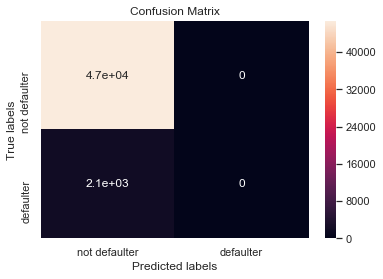

In [142]:
plot_confusion_matrix(confusion)

In [143]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Defaulted, y_train_pred_final.predicted))

0.957589422978


In [144]:
print_confusion_matrix

<function __main__.print_confusion_matrix(y_true, y_pred)>

In [145]:
# Fetch different parameters
sensitivity, specificity, pos_pred_val, neg_pred_val,false_positive=perf_metrics_2X2(y_train_pred_final.predicted,y_train_pred_final.Defaulted)

In [146]:
print("sensitivity is ",sensitivity)

sensitivity is  0.0


In [147]:
print("specificity is ",specificity)

specificity is  1.0


In [148]:
print("True Predicitive is ",pos_pred_val)

True Predicitive is  nan


In [149]:
print("Negative Predicitive is ",neg_pred_val)

Negative Predicitive is  0.957589422978


In [150]:
print("False Positive is ",false_positive)

False Positive is  0.0


In [151]:
#fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Defaulted, y_train_pred_final.Defaulted_Prob, drop_intermediate = False )

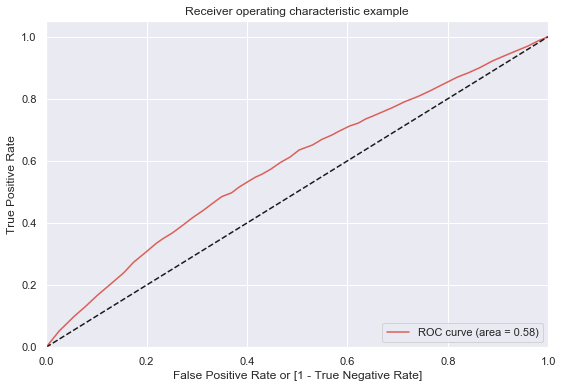

In [152]:
draw_roc(y_train_pred_final.Defaulted, y_train_pred_final.Defaulted_Prob)

In [153]:
# We need to create columns for different probabilities

numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Defaulted_Prob.map(lambda x: 1 if x > i else 0)

In [154]:
#check the dataframe
y_train_pred_final.head()

ApplicationID  Defaulted  Defaulted_Prob  predicted  0.0  0.1  0.2  0.3  \
0          22156        0.0        0.039114          0    1    0    0    0   
1           7198        0.0        0.048797          0    1    0    0    0   
2          67041        0.0        0.053553          0    1    0    0    0   
3          20693        0.0        0.031970          0    1    0    0    0   
4          40852        0.0        0.049719          0    1    0    0    0   

   0.4  0.5  0.6  0.7  0.8  0.9  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0

In [155]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Defaulted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]

In [156]:
print(cutoff_df)

     prob  accuracy  sensi  speci
0.0   0.0  0.042411    1.0    0.0
0.1   0.1  0.957589    0.0    1.0
0.2   0.2  0.957589    0.0    1.0
0.3   0.3  0.957589    0.0    1.0
0.4   0.4  0.957589    0.0    1.0
0.5   0.5  0.957589    0.0    1.0
0.6   0.6  0.957589    0.0    1.0
0.7   0.7  0.957589    0.0    1.0
0.8   0.8  0.957589    0.0    1.0
0.9   0.9  0.957589    0.0    1.0


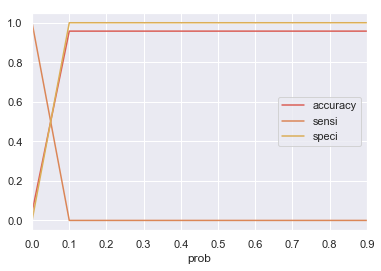

In [157]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [158]:
#Since we see that all cuts at approx probability of 0.1 
#So we will apply cut off on 0.1 to the predicted defaults

y_train_pred_final['predicted_default'] = y_train_pred_final.Defaulted_Prob.map( lambda x: 1 if x > 0.1 else 0)

y_train_pred_final.head()

ApplicationID  Defaulted  Defaulted_Prob  predicted  0.0  0.1  0.2  0.3  \
0          22156        0.0        0.039114          0    1    0    0    0   
1           7198        0.0        0.048797          0    1    0    0    0   
2          67041        0.0        0.053553          0    1    0    0    0   
3          20693        0.0        0.031970          0    1    0    0    0   
4          40852        0.0        0.049719          0    1    0    0    0   

   0.4  0.5  0.6  0.7  0.8  0.9  predicted_default  
0    0    0    0    0    0    0                  0  
1    0    0    0    0    0    0                  0  
2    0    0    0    0    0    0                  0  
3    0    0    0    0    0    0                  0  
4    0    0    0    0    0    0                  0

In [159]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.Defaulted, y_train_pred_final.predicted_default )
confusion2

array([[46716,     0],
       [ 2069,     0]])

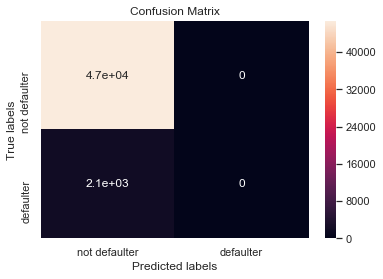

In [160]:
plot_confusion_matrix(confusion)

In [161]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Defaulted, y_train_pred_final.predicted_default))

0.957589422978


In [162]:
# Fetch different parameters
sensitivity2, specificity2, pos_pred_val2, neg_pred_val2,false_positive2=perf_metrics_2X2(y_train_pred_final.predicted,y_train_pred_final.Defaulted)

In [163]:
print("sensitivity is ",sensitivity2)

sensitivity is  0.0


In [164]:
print("specificity is ",specificity2)

specificity is  1.0


In [165]:
print("Negative Predicitive is ",neg_pred_val2)

Negative Predicitive is  0.957589422978


In [166]:
print("False Positive is ",false_positive2)

False Positive is  0.0


#### Lets check the Test Data now

In [167]:
X_test_sm = sm.add_constant(X_test)

In [168]:
X_test_sm = X_test_sm[col]

In [169]:
y_test_pred = logm8.predict(X_test_sm)

In [170]:
get_nulls_report(X_test_sm)#will do tomorrow

In [171]:
# Converting y_pred to a dataframe which is as y_test_pred array
y_pred_temp = pd.DataFrame(y_test_pred)

In [172]:
y_pred_temp.head()

0
13110  0.033922
43608  0.059794
10268  0.024832
54520  0.060431
8268   0.033922

In [173]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

In [174]:
y_test_df.head()

Performance_Tag
13110              0.0
43608              0.0
10268              0.0
54520              0.0
8268               0.0

In [175]:
# Adding back ApplicationID to index
y_test_df['ApplicationID'] = y_test_df.index

In [176]:
 #Removing index for both dataframes to append them side by side 
y_pred_temp.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)
# Appending y_test_df and y_pred_temp
y_pred_final = pd.concat([y_test_df, y_pred_temp],axis=1)
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Defaulted_Prob'})
y_pred_final.head()

Performance_Tag  ApplicationID  Defaulted_Prob
0              0.0          13110        0.033922
1              0.0          43608        0.059794
2              0.0          10268        0.024832
3              0.0          54520        0.060431
4              0.0           8268        0.033922

In [177]:
y_pred_final['predicted_default'] = y_pred_final.Defaulted_Prob.map(lambda x: 1 if x > 0.1 else 0)
y_pred_final.head()

Performance_Tag  ApplicationID  Defaulted_Prob  predicted_default
0              0.0          13110        0.033922                  0
1              0.0          43608        0.059794                  0
2              0.0          10268        0.024832                  0
3              0.0          54520        0.060431                  0
4              0.0           8268        0.033922                  0

In [178]:
y_pred_final['Defaulted'] = y_pred_final['Performance_Tag'] 

In [179]:
get_nulls_report(y_pred_final)

In [180]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.Defaulted, y_pred_final.predicted_default)

0.95814999043428351

In [181]:
confusion3 = metrics.confusion_matrix(y_pred_final.Defaulted, y_pred_final.predicted_default )
confusion3            

array([[20033,     0],
       [  875,     0]])

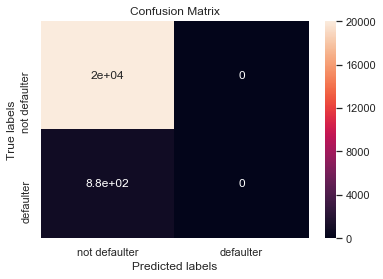

In [182]:
plot_confusion_matrix(confusion3)

In [183]:
# Fetch different parameters
sensitivity3, specificity3, pos_pred_val3, neg_pred_val3,false_positive3=perf_metrics_2X2(y_pred_final.predicted_default,y_pred_final.Defaulted)

In [184]:
print("sensitivity is ",sensitivity3)

sensitivity is  0.0


In [185]:
print("specificity is ",specificity3)

specificity is  1.0


In [186]:
print("Negative Predicitive is ",neg_pred_val3)

Negative Predicitive is  0.957589422978


In [187]:
print("False Positive is ",false_positive3)

False Positive is  0.0


# Logistic regression using PCA

In [188]:
X_train.shape

(48785, 10)

In [189]:
pca = PCA(svd_solver='randomized', random_state=42)

In [190]:
#We will do the PCA on  the Train Dataset 
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='randomized', tol=0.0, whiten=False)

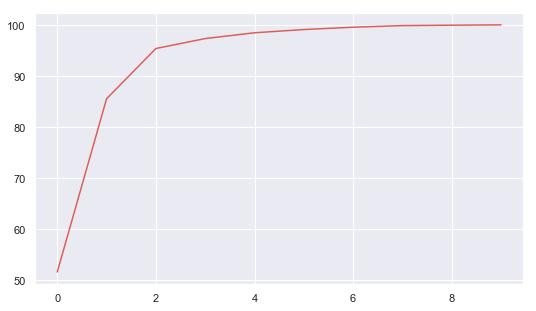

In [191]:
# plot feature variance
features = range(pca.n_components_)
cumulative_variance = np.round(np.cumsum(pca.explained_variance_ratio_)*100, decimals=4)
plt.figure(figsize=(175/20,100/20)) # 100 elements on y-axis; 175 elements on x-axis; 20 is normalising factor
plt.plot(cumulative_variance)

In [192]:
# fits PCA, transforms data and fits LogisticRegression
# on the transformed data

In [193]:
# create pipeline
pca_vars = 3
steps = [("pca", PCA(n_components=pca_vars)),
         ("logistic", LogisticRegression(class_weight='balanced'))
        ]
pipeline = Pipeline(steps)

In [194]:
# fit model
pipeline.fit(X_train, y_train)

# check score on train data
pipeline.score(X_train, y_train)

0.58155170646715182

In [195]:
# predict churn on test data
y_pred = pipeline.predict(X_test)

In [196]:
# create onfusion matrix
confusion4 = metrics.confusion_matrix(y_test, y_pred )
confusion4

array([[11655,  8378],
       [  393,   482]])

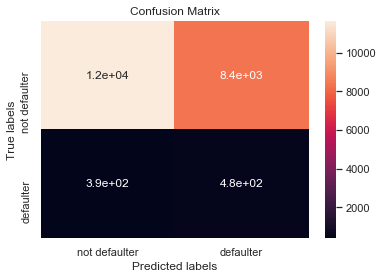

In [197]:
plot_confusion_matrix(confusion4)

In [198]:
# Fetch different parameters
sensitivity4, specificity4, pos_pred_val4, neg_pred_val4,false_positive4=perf_metrics_2X2(y_test,y_pred)

In [199]:
print("sensitivity is ",sensitivity4)

sensitivity is  0.0


In [200]:
print("specificity is ",specificity4)

specificity is  1.0


In [201]:
print("Negative Predicitive is ",neg_pred_val4)

Negative Predicitive is  0.957589422978


In [202]:
print("False Positive is ",false_positive4)

False Positive is  0.0


In [203]:
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]

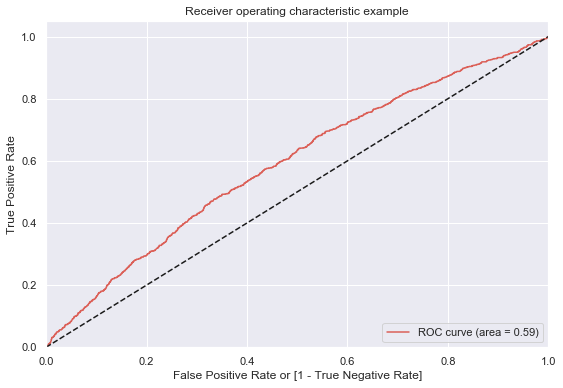

In [204]:
# Draw ROC and area under cursve
draw_roc(y_test, y_pred_prob)

In [205]:
# PCA
pca = PCA()

# logistic regression - the class weight is used to handle class imbalance - it adjusts the cost function
logistic = LogisticRegression(class_weight='balanced')

# create pipeline
steps = [("pca", pca),
         ("logistic", logistic)
        ]

# compile pipeline
pca_logistic = Pipeline(steps)

# hyperparameter space
params = {'pca__n_components': [3], 'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10], 'logistic__penalty': ['l1', 'l2']}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model = GridSearchCV(estimator=pca_logistic, cv=folds, param_grid=params, scoring='roc_auc')

In [206]:
# fit model
model.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logistic', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'pca__n_components': [3], 'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10], 'logistic__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

#### Hyperparameters are 

In [207]:
print("Best AUC: ", model.best_score_)

Best AUC:  0.583263602462


In [208]:
print("Best hyperparameters: ", model.best_params_)

Best hyperparameters:  {'logistic__C': 0.1, 'logistic__penalty': 'l2', 'pca__n_components': 3}


In [209]:
# Again do the Prediction on train data
y_train_pred = model.predict(X_train)

In [210]:
# create onfusion matrix
confusion5 = metrics.confusion_matrix(y_train, y_train_pred )
confusion5

array([[27238, 19478],
       [  936,  1133]])

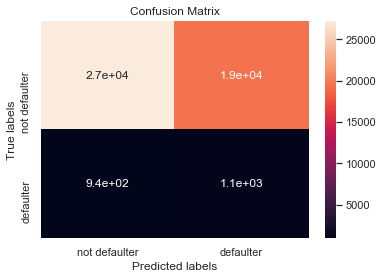

In [211]:
plot_confusion_matrix(confusion5)

In [212]:
# Fetch different parameters
sensitivity5, specificity5, pos_pred_val5, neg_pred_val5,false_positive5=perf_metrics_2X2(y_train,y_train_pred)

In [213]:
print("sensitivity is ",sensitivity5)

sensitivity is  0.0


In [214]:
print("specificity is ",specificity5)

specificity is  1.0


In [215]:
print("Negative Predicitive is ",neg_pred_val5)

Negative Predicitive is  0.957589422978


In [216]:
print("False Positive is ",false_positive5)

False Positive is  0.0


In [217]:
# check area under curve
y_train_pred_prob = model.predict_proba(X_train)[:, 1]

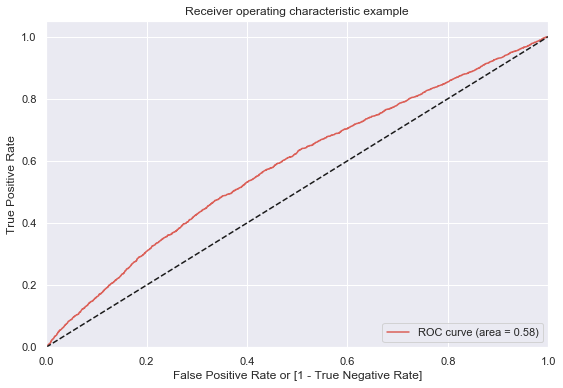

In [218]:
# Draw ROC and area under cursve
draw_roc(y_train, y_train_pred_prob)

In [219]:
# Converting y_pred to a dataframe which is an array
y_train_pred = pd.DataFrame(y_train_pred_prob)

In [220]:
# Converting y_test to dataframe
y_train_df = pd.DataFrame(y_train)

In [221]:
# Putting ApplicationID to index
y_train_df['ApplicationID'] = y_train_df.index

In [222]:
#Removing index for both dataframes to append them side by side 
y_train_pred.reset_index(drop=True, inplace=True)
y_train_df.reset_index(drop=True, inplace=True)
# Appending y_test_df and y_pred_1
y_train_pred_final = pd.concat([y_train_df, y_train_pred],axis=1)
# Renaming the column 
y_train_pred_final= y_train_pred_final.rename(columns={ 0 : 'Defaulted_Prob'})
y_train_pred_final.head()

Performance_Tag  ApplicationID  Defaulted_Prob
0              0.0          22156        0.476657
1              0.0           7198        0.536687
2              0.0          67041        0.558291
3              0.0          20693        0.427837
4              0.0          40852        0.540027

In [223]:
y_train_pred_final['predicted_default'] = y_train_pred_final.Defaulted_Prob.map(lambda x: 1 if x > 0.7 else 0)

In [224]:
y_train_pred_final['Defaulted'] = y_train_pred_final['Performance_Tag'] 

In [225]:
y_train_pred_final.head()

Performance_Tag  ApplicationID  Defaulted_Prob  predicted_default  \
0              0.0          22156        0.476657                  0   
1              0.0           7198        0.536687                  0   
2              0.0          67041        0.558291                  0   
3              0.0          20693        0.427837                  0   
4              0.0          40852        0.540027                  0   

   Defaulted  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0

In [226]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.Defaulted, y_train_pred_final.predicted_default)

0.95758942297837446

In [227]:
# predict churn on test data
# Converting y_pred to a dataframe which is an array
y_test_pred = model.predict(X_test)

In [228]:
# create confusion matrix
confusion6 = metrics.confusion_matrix(y_test, y_test_pred )
confusion6

array([[11655,  8378],
       [  393,   482]])

In [229]:
y_test_pred

array([ 0.,  1.,  0., ...,  0.,  1.,  1.])

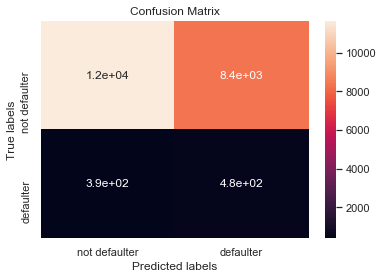

In [230]:
plot_confusion_matrix(confusion6)

In [231]:
# check area under curve
y_test_pred_prob = model.predict_proba(X_test)[:, 1]

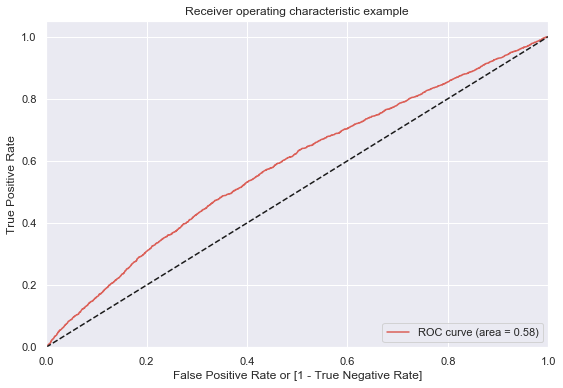

In [232]:
# Draw ROC and area under cursve
draw_roc(y_train, y_train_pred_prob)

In [233]:
# Converting y_test to dataframe
y_test_pred = pd.DataFrame(y_test_pred_prob)

In [234]:
# Converting y_pred to a dataframe which is an array
y_test_df = pd.DataFrame(y_test)

In [235]:
# Putting ApplicationID to index
y_test_df['ApplicationID'] = y_test_df.index

#Removing index for both dataframes to append them side by side 
y_test_pred.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)
# Appending y_test_df and y_pred_1
y_test_pred_final = pd.concat([y_test_df, y_test_pred],axis=1)
# Renaming the column 
y_test_pred_final= y_test_pred_final.rename(columns={ 0 : 'Defaulted_Prob'})
y_test_pred_final.head()

y_test_pred_final['predicted_default'] = y_test_pred_final.Defaulted_Prob.map(lambda x: 1 if x > 0.7 else 0)
y_test_pred_final.head()

y_test_pred_final['Defaulted'] = y_test_pred_final['Performance_Tag'] 

# Let's check the overall accuracy.
metrics.accuracy_score(y_test_pred_final.Defaulted, y_test_pred_final.predicted_default)

0.95814999043428351

In [236]:
y_test_pred_final.head()

Performance_Tag  ApplicationID  Defaulted_Prob  predicted_default  \
0              0.0          13110        0.445205                  0   
1              0.0          43608        0.586600                  0   
2              0.0          10268        0.372818                  0   
3              0.0          54520        0.585997                  0   
4              0.0           8268        0.445310                  0   

   Defaulted  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0

In [237]:
# Adding non defaulted probability which is 1- Default Probability
y_test_pred_final['Non_Defaulted_Prob']=1-y_test_pred_final['Defaulted_Prob']
y_test_pred_final.head()

Performance_Tag  ApplicationID  Defaulted_Prob  predicted_default  \
0              0.0          13110        0.445205                  0   
1              0.0          43608        0.586600                  0   
2              0.0          10268        0.372818                  0   
3              0.0          54520        0.585997                  0   
4              0.0           8268        0.445310                  0   

   Defaulted  Non_Defaulted_Prob  
0        0.0            0.554795  
1        0.0            0.413400  
2        0.0            0.627182  
3        0.0            0.414003  
4        0.0            0.554690

In [238]:
#Calculating odd goods as P(non-defaulted)/P(defaulted)
y_test_pred_final['odds']=y_test_pred_final['Non_Defaulted_Prob']/y_test_pred_final['Defaulted_Prob']
y_test_pred_final.head()

Performance_Tag  ApplicationID  Defaulted_Prob  predicted_default  \
0              0.0          13110        0.445205                  0   
1              0.0          43608        0.586600                  0   
2              0.0          10268        0.372818                  0   
3              0.0          54520        0.585997                  0   
4              0.0           8268        0.445310                  0   

   Defaulted  Non_Defaulted_Prob      odds  
0        0.0            0.554795  1.246157  
1        0.0            0.413400  0.704739  
2        0.0            0.627182  1.682274  
3        0.0            0.414003  0.706494  
4        0.0            0.554690  1.245629

In [239]:
#As per problem statement
#Target Score ts=400
#Inverted target score to=10
#points to double odds pdo=20
y_test_pred_final['logit']=np.log(y_test_pred_final['odds'])
y_test_pred_final.head()

Performance_Tag  ApplicationID  Defaulted_Prob  predicted_default  \
0              0.0          13110        0.445205                  0   
1              0.0          43608        0.586600                  0   
2              0.0          10268        0.372818                  0   
3              0.0          54520        0.585997                  0   
4              0.0           8268        0.445310                  0   

   Defaulted  Non_Defaulted_Prob      odds     logit  
0        0.0            0.554795  1.246157  0.220064  
1        0.0            0.413400  0.704739 -0.349927  
2        0.0            0.627182  1.682274  0.520147  
3        0.0            0.414003  0.706494 -0.347441  
4        0.0            0.554690  1.245629  0.219641

In [240]:
pdo=20
to=10
factor=pdo/np.log(2)
points0=400
odds0=1/to
offset=points0-factor * np.log(odds0)

In [241]:
offset

466.43856189774726

In [242]:
y_test_pred_final['score']=offset-(factor*y_test_pred_final['logit'])

In [243]:
y_test_pred_final.head()

Performance_Tag  ApplicationID  Defaulted_Prob  predicted_default  \
0              0.0          13110        0.445205                  0   
1              0.0          43608        0.586600                  0   
2              0.0          10268        0.372818                  0   
3              0.0          54520        0.585997                  0   
4              0.0           8268        0.445310                  0   

   Defaulted  Non_Defaulted_Prob      odds     logit       score  
0        0.0            0.554795  1.246157  0.220064  460.088843  
1        0.0            0.413400  0.704739 -0.349927  476.535326  
2        0.0            0.627182  1.682274  0.520147  451.430306  
3        0.0            0.414003  0.706494 -0.347441  476.463594  
4        0.0            0.554690  1.245629  0.219641  460.101075

In [244]:
TP = confusion6[1,1] # true positive 
TN = confusion6[0,0] # true negatives
FP = confusion6[0,1] # false positives
FN = confusion6[1,0] # false negatives

In [245]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.55085714285714282

In [246]:
# Let us calculate specificity
TN / float(TN+FP)

0.58179004642340137

# Decision Tree

In [247]:
# Importing decision tree classifier from sklearn library
from sklearn.tree import DecisionTreeClassifier

# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report, confusion_matrix

In [248]:
default_dt = DecisionTreeClassifier(max_depth=5)
default_dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [249]:
# Create Predictions
y_train_pred_default = default_dt.predict(X_train)

In [250]:
# Classification report
print(classification_report(y_train, y_train_pred_default))

             precision    recall  f1-score   support

        0.0       0.96      1.00      0.98     46716
        1.0       1.00      0.00      0.00      2069

avg / total       0.96      0.96      0.94     48785



In [251]:
# create confusion matrix
confusion7 = metrics.confusion_matrix(y_train, y_train_pred_default )
confusion7

array([[46716,     0],
       [ 2068,     1]])

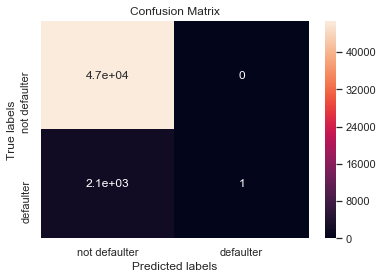

In [252]:
plot_confusion_matrix(confusion7)

In [253]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
    'criterion': ["entropy", "gini"]
}

n_folds = 5

# Instantiate the grid search model
dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid, 
                          cv = n_folds, verbose = 1)

In [254]:
# Fit the grid search to the data
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    6.8s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(5, 15, 5), 'min_samples_leaf': range(50, 150, 50), 'min_samples_split': range(50, 150, 50), 'criterion': ['entropy', 'gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [255]:
# Best accuracy score
print("Best Accuracy", grid_search.best_score_)

Best Accuracy 0.957589422978


In [256]:
# Hyperparameters are
print(grid_search.best_estimator_)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=50,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [257]:
# Create a model with Optional Hyperparameter
clf_entropy = DecisionTreeClassifier(criterion = "entropy", 
                                  random_state = 100,
                                  max_depth=5, 
                                  min_samples_leaf=50,
                                  min_samples_split=50)

In [258]:
clf_entropy.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=50,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [259]:
# Fetch the Accuracy Score
clf_entropy.score(X_train,y_train)

0.95758942297837446

In [260]:
# classification metrics
from sklearn.metrics import classification_report,confusion_matrix
y_train_pred = clf_entropy.predict(X_train)
print(classification_report(y_train, y_train_pred))

             precision    recall  f1-score   support

        0.0       0.96      1.00      0.98     46716
        1.0       0.00      0.00      0.00      2069

avg / total       0.92      0.96      0.94     48785



In [261]:
# create confusion matrix
confusion8 = metrics.confusion_matrix(y_train, y_train_pred )
confusion8

array([[46716,     0],
       [ 2069,     0]])

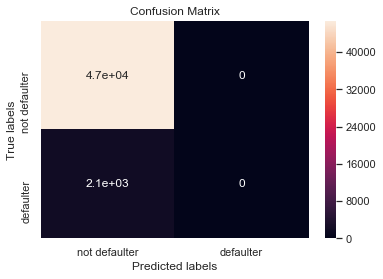

In [262]:
plot_confusion_matrix(confusion8)

In [263]:
TP = confusion8[1,1] # true positive 
TN = confusion8[0,0] # true negatives
FP = confusion8[0,1] # false positives
FN = confusion8[1,0] # false negatives

In [264]:
# sensitivity of our logistic regression model
print("Sensitivity is ",TP / float(TP+FN))

Sensitivity is  0.0


In [265]:
# specificity of our logistic regression model
print("specificity is ",TN / float(TN+FP))

specificity is  1.0


# Random Forest

In [266]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

In [267]:
# Creating Random Forest Initially with Default Parameter
default_rdf = RandomForestClassifier()

In [268]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

In [269]:
# fit model
default_rdf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [270]:
# predict on train data
y_train_pred = default_rdf.predict(X_train)

In [271]:
# predict  on test data
y_test_pred = default_rdf.predict(X_test)

In [272]:
# Print the Classification Report on Train Data
print(classification_report(y_train,y_train_pred))

             precision    recall  f1-score   support

        0.0       0.96      1.00      0.98     46716
        1.0       0.75      0.16      0.27      2069

avg / total       0.96      0.96      0.95     48785



In [273]:
# Let's check the report on Test data of our default model
print(classification_report(y_test,y_test_pred))

             precision    recall  f1-score   support

        0.0       0.96      0.99      0.97     20033
        1.0       0.05      0.01      0.02       875

avg / total       0.92      0.95      0.93     20908



In [274]:
# create confusion matrix on train Data
confusion9 = metrics.confusion_matrix(y_train, y_train_pred )
confusion9

array([[46605,   111],
       [ 1733,   336]])

In [275]:
print("Accuracy of the Model is ",accuracy_score(y_train,y_train_pred))

Accuracy of the Model is  0.962201496362


In [276]:
# create confusion matrix on test Data
confusion10 = metrics.confusion_matrix(y_test, y_test_pred )
confusion10

array([[19864,   169],
       [  866,     9]])

In [277]:
print("Accuracy of the Model is ",accuracy_score(y_test,y_test_pred))

Accuracy of the Model is  0.950497417257


In [278]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [4,8,10],
    'min_samples_leaf': range(100, 400, 200),
    'min_samples_split': range(200, 500, 200),
    'n_estimators': [100,200, 300], 
    'max_features': [5, 10]
}
# Create a based model
rdf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rdf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1)

In [279]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed: 10.1min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [4, 8, 10], 'min_samples_leaf': range(100, 400, 200), 'min_samples_split': range(200, 500, 200), 'n_estimators': [100, 200, 300], 'max_features': [5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [280]:
# printing the best accuracy score and hyperparameters
print('We can achieve  accuracy of',grid_search.best_score_,'using hyperparameters ',grid_search.best_params_)

We can achieve  accuracy of 0.957589422978 using hyperparameters  {'max_depth': 4, 'max_features': 5, 'min_samples_leaf': 100, 'min_samples_split': 200, 'n_estimators': 100}


In [281]:
# Using the hyperparameters derived above
from sklearn.ensemble import RandomForestClassifier
rdf_with_hyp = RandomForestClassifier(bootstrap=True,
                             max_depth=4,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=5,
                             n_estimators=100)

In [282]:
# fit the model
rdf_with_hyp.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=200,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [283]:
# prediction for Train data
train_predictions = rdf_with_hyp.predict(X_train)

In [284]:
# predict for Test data
test_predictions = rdf_with_hyp.predict(X_test)

In [285]:
# create confusion matrix on test Data
confusion11 = metrics.confusion_matrix(y_train,train_predictions)
confusion11

array([[46716,     0],
       [ 2069,     0]])

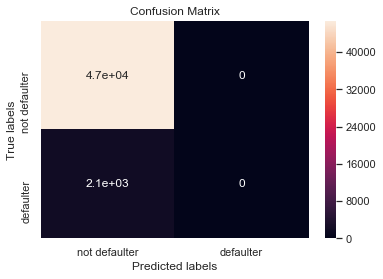

In [286]:
plot_confusion_matrix(confusion11)

In [287]:
print("The Accuracy of the Model is ",accuracy_score(y_train,train_predictions))

The Accuracy of the Model is  0.957589422978


In [288]:
# create confusion matrix on test Data
confusion12 = metrics.confusion_matrix(y_test,test_predictions)
confusion12

array([[20033,     0],
       [  875,     0]])

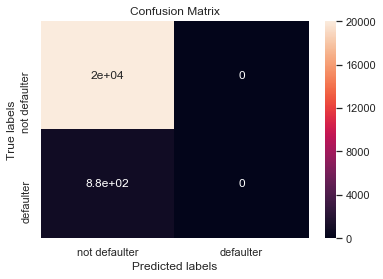

In [289]:
plot_confusion_matrix(confusion12)

In [290]:
print("The Accuracy of the decision tree is ",accuracy_score(y_test,test_predictions))

The Accuracy of the decision tree is  0.958149990434


## Building Models on Demographic Data - Finished

## EDA on the Merged Dataset

In [291]:
# Merging the demographic data with the credit Bureau Dataset
Cred_demo_df = demographic_df.merge(credit_bureau_df
                             , on='Application ID')

In [292]:
Cred_demo_df.head()

Application ID  Age Gender Marital Status (at the time of application)  \
0       954457215   48      F                                     Married   
1       432830445   31      M                                     Married   
2       941387308   32      M                                      Single   
3       392161677   43      M                                     Married   
4       182011211   35      F                                     Married   

   No of dependents  Income     Education Profession  Type of residence  \
0               2.0    40.0      Bachelor         SAL            Rented   
1               4.0    55.0  Professional     SE_PROF            Rented   
2               2.0    46.0      Bachelor     SE_PROF            Rented   
3               1.0    53.0      Bachelor          SE            Rented   
4               5.0    44.0  Professional         SAL            Rented   

   No of months in current residence        ...          \
0                                113        ...           
1                                112        ...           
2                                104        ...           
3                                 94        ...           
4                                112        ...           

   No of trades opened in last 12 months  \
0                                      2   
1                                      2   
2                                      0   
3                                      1   
4                                      1   

   No of PL trades opened in last 6 months  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   No of PL trades opened in last 12 months  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   

   No of Inquiries in last 6 months (excluding home & auto loans)  \
0                                                  0                
1                                                  0                
2                                                  0                
3                                                  0                
4                                                  0                

   No of Inquiries in last 12 months (excluding home & auto loans)  \
0                                                  0                 
1                                                  0                 
2                                                  0                 
3                                                  0                 
4                                                  0                 

   Presence of open home loan  Outstanding Balance  Total No of Trades  \
0                         1.0            2999395.0                   4   
1                         0.0               3078.0                   5   
2                         1.0            3004972.0                   2   
3                         1.0            3355373.0                   4   
4                         1.0            3014283.0                   4   

   Presence of open auto loan  Performance Tag_y  
0                           0                0.0  
1                           0                0.0  
2                           0                0.0  
3                           1                0.0  
4                           0                0.0  

[5 rows x 30 columns]

In [293]:
Cred_demo_df.shape

(71301, 30)

In [294]:
# fetch the duplicates from the merged datasets
CredX_dupli=Cred_demo_df[Cred_demo_df['Application ID'].isin(appl_list_cb)].sort_values('Application ID')
CredX_dupli

Application ID  Age Gender Marital Status (at the time of application)  \
5243        653287861   26      M                                     Married   
5244        653287861   26      M                                     Married   
5245        653287861   40      M                                     Married   
5246        653287861   40      M                                     Married   
48606       671989187   27      M                                     Married   
48607       671989187   27      M                                     Married   
48608       671989187   57      M                                     Married   
48609       671989187   57      M                                     Married   
24389       765011468   57      M                                      Single   
24390       765011468   57      M                                      Single   
24391       765011468   38      M                                     Married   
24392       765011468   38      M                                     Married   

       No of dependents  Income     Education Profession   \
5243                3.0    25.0      Bachelor         SAL   
5244                3.0    25.0      Bachelor         SAL   
5245                5.0    32.0           Phd          SE   
5246                5.0    32.0           Phd          SE   
48606               2.0    35.0  Professional         SAL   
48607               2.0    35.0  Professional         SAL   
48608               4.0     7.0  Professional          SE   
48609               4.0     7.0  Professional          SE   
24389               4.0     4.5      Bachelor         SAL   
24390               4.0     4.5      Bachelor         SAL   
24391               4.0     4.5  Professional         SAL   
24392               4.0     4.5  Professional         SAL   

         Type of residence  No of months in current residence  \
5243                Rented                                112   
5244                Rented                                112   
5245                Rented                                 45   
5246                Rented                                 45   
48606  Living with Parents                                108   
48607  Living with Parents                                108   
48608               Rented                                 42   
48609               Rented                                 42   
24389     Company provided                                  6   
24390     Company provided                                  6   
24391               Rented                                  6   
24392               Rented                                  6   

             ...          No of trades opened in last 12 months  \
5243         ...                                              0   
5244         ...                                              5   
5245         ...                                              0   
5246         ...                                              5   
48606        ...                                              6   
48607        ...                                              7   
48608        ...                                              6   
48609        ...                                              7   
24389        ...                                              2   
24390        ...                                              3   
24391        ...                                              2   
24392        ...                                              3   

       No of PL trades opened in last 6 months  \
5243                                         0   
5244                                         1   
5245                                         0   
5246                                         1   
48606                                        1   
48607                                        1   
48608                                        1   
48609                                    

In [295]:
# Doubtfull Applicants Lists
appl_list_cb

[671989187, 765011468, 653287861]

In [296]:
# Drop 12 rows for doubtfull applicants 
Cred_demo_df= Cred_demo_df[~Cred_demo_df['Application ID'].isin(appl_list_cb)]
Cred_demo_df.shape

(71289, 30)

In [297]:
# Information of the merged Dataset 
Cred_demo_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71289 entries, 0 to 71300
Data columns (total 30 columns):
Application ID                                                     71289 non-null int64
Age                                                                71289 non-null int64
Gender                                                             71287 non-null object
Marital Status (at the time of application)                        71283 non-null object
No of dependents                                                   71286 non-null float64
Income                                                             71289 non-null float64
Education                                                          71170 non-null object
Profession                                                         71275 non-null object
Type of residence                                                  71281 non-null object
No of months in current residence                                  71289 non-null int64
No

### Data Cleaning On Merged dataset

In [298]:
# Checking on Performance Tag feature taken from Demographic and Credit Bureau Dataset if both are same for given applicants we can drop one column
Cred_demo_df[['Application ID','Performance Tag_x','Performance Tag_y']].head(20)

Application ID  Performance Tag_x  Performance Tag_y
0        954457215                0.0                0.0
1        432830445                0.0                0.0
2        941387308                0.0                0.0
3        392161677                0.0                0.0
4        182011211                0.0                0.0
5        312196805                0.0                0.0
6        532217204                0.0                0.0
7         74788849                0.0                0.0
8        782743811                0.0                0.0
9         96964957                0.0                0.0
10       547975524                0.0                0.0
11       521995234                0.0                0.0
12       896612622                0.0                0.0
13       179296033                0.0                0.0
14       951198562                0.0                0.0
15       268129376                0.0                0.0
16       229994022                0.0                0.0
17       833334789                0.0                0.0
18       900107201                0.0                0.0
19       537943379                0.0                0.0

In [299]:
# Dropping both the Performance tag column X and Y  and creating a new with the name "Performance_Tag"
Cred_demo_df['Performance_Tag']= Cred_demo_df['Performance Tag_x']
Cred_demo_df=Cred_demo_df.drop(['Performance Tag_x','Performance Tag_y'],axis=1)
Cred_demo_df.head()

Application ID  Age Gender Marital Status (at the time of application)  \
0       954457215   48      F                                     Married   
1       432830445   31      M                                     Married   
2       941387308   32      M                                      Single   
3       392161677   43      M                                     Married   
4       182011211   35      F                                     Married   

   No of dependents  Income     Education Profession  Type of residence  \
0               2.0    40.0      Bachelor         SAL            Rented   
1               4.0    55.0  Professional     SE_PROF            Rented   
2               2.0    46.0      Bachelor     SE_PROF            Rented   
3               1.0    53.0      Bachelor          SE            Rented   
4               5.0    44.0  Professional         SAL            Rented   

   No of months in current residence       ...         \
0                                113       ...          
1                                112       ...          
2                                104       ...          
3                                 94       ...          
4                                112       ...          

   No of trades opened in last 12 months  \
0                                      2   
1                                      2   
2                                      0   
3                                      1   
4                                      1   

   No of PL trades opened in last 6 months  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   No of PL trades opened in last 12 months  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   

   No of Inquiries in last 6 months (excluding home & auto loans)  \
0                                                  0                
1                                                  0                
2                                                  0                
3                                                  0                
4                                                  0                

   No of Inquiries in last 12 months (excluding home & auto loans)  \
0                                                  0                 
1                                                  0                 
2                                                  0                 
3                                                  0                 
4                                                  0                 

   Presence of open home loan  Outstanding Balance  Total No of Trades  \
0                         1.0            2999395.0                   4   
1                         0.0               3078.0                   5   
2                         1.0            3004972.0                   2   
3                         1.0            3355373.0                   4   
4                         1.0            3014283.0                   4   

   Presence of open auto loan  Performance_Tag  
0                           0              0.0  
1                           0              0.0  
2                           0              0.0  
3                           1              0.0  
4                           0              0.0  

[5 rows x 29 columns]

In [300]:
Cred_demo_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71289 entries, 0 to 71300
Data columns (total 29 columns):
Application ID                                                     71289 non-null int64
Age                                                                71289 non-null int64
Gender                                                             71287 non-null object
Marital Status (at the time of application)                        71283 non-null object
No of dependents                                                   71286 non-null float64
Income                                                             71289 non-null float64
Education                                                          71170 non-null object
Profession                                                         71275 non-null object
Type of residence                                                  71281 non-null object
No of months in current residence                                  71289 non-null int64
No

In [301]:
# Since the column Profession has Space in it , remaming the column 
Cred_demo_df.rename(columns={'Profession ':'Profession'},inplace=True)

### Fetch the Null report

In [302]:
get_nulls_report(Cred_demo_df)

## Univariate Analysis

### Univariate Analysis for  Age

In [303]:
# Frequency of the Applicants based on the age
get_column_frequency(Cred_demo_df.Age)

Age
 39  2543
 42  2398
 43  2395
 37  2394
 40  2391
 38  2371
 51  2367
 46  2345
 41  2339
 47  2336
 44  2321
 36  2320
 48  2311
 52  2298
 50  2297
 53  2294
 54  2289
 45  2278
 49  2260
 56  2215
 55  2210
 35  1504
 32  1500
 30  1423
 27  1422
 33  1413
 31  1372
 34  1370
 29  1370
 28  1370
 58  1068
 60  1042
 61  1017
 59  1016
 57  1015
 62  1001
 63   979
 65   958
 64   932
 24   114
 25   107
 26    99
 23    42
 22    29
 20    29
 19    24
 18    23
 17    22
 0     19
 21    13
 15    12
 16    11
-3      1

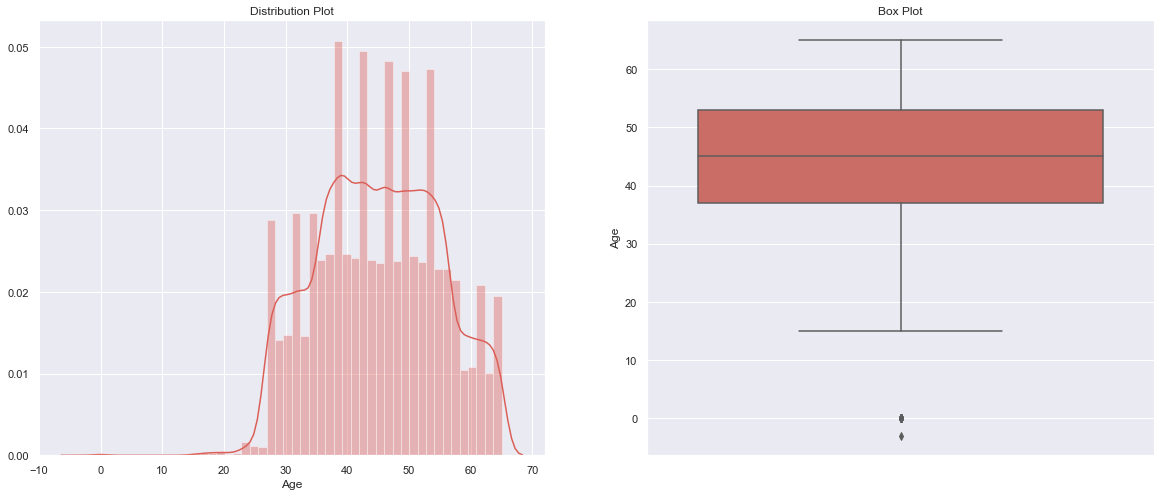

In [304]:
#Analyze the plots for the age Columns
draw_univariate_plot(Cred_demo_df,"Age")

In [305]:
# Fetching the Applicants with age less than 18 
Cred_demo_df[Cred_demo_df.Age<18]

Application ID  Age Gender Marital Status (at the time of application)  \
74          975085624   17      M                                      Single   
250          15988053   17      M                                      Single   
274         553384326   17      M                                      Single   
283         490791674   15      F                                      Single   
313         584758872   16      M                                      Single   
385         149528904   15      M                                      Single   
484         588417745   16      M                                     Married   
504         568773679   17      M                                      Single   
548         920083644   16      M                                     Married   
623         842745102   17      M                                     Married   
626         505345414   17      F                                     Married   
678         326621134   16      M                                     Married   
722         256752828   15      M                                     Married   
725         483332934   17      F                                     Married   
745         535285757   16      M                                     Married   
746         701653071   15      F                                      Single   
774         440605214   15      M                                     Married   
818         910506404   15      M                                      Single   
860         134951209   16      M                                      Single   
911         783913343   17      F                                     Married   
924         601969470   15      F                                      Single   
941         717434244   16      M                                      Single   
975         534251279   16      F                                      Single   
1008        371030845   15      M                                     Married   
1010        410153337   15      F                                      Single   
1027        431350709   17      M                                     Married   
1056        403119279   17      F                                     Married   
1062        805308826   17      M                                     Married   
1147        322139302   15      M                                     Married   
1178        130064793   16      M                                      Single   
...               ...  ...    ...                                         ...   
4028        339076142   17      M                                      Single   
4048        812365997   17      F                                     Married   
4134        773171568   17      M                                     Married   
4185        327723491   17      F                                      Single   
4311        622880517   17      M                                     Married   
4367        745462418   17      F                                      Single   
4421        381342630   17      F                                     Married   
4589         89770640   17      M                                     Married   
4633         13167456   17      M                                     Married   
4656        705529178   17      M                                     Married   
9114        964427213    0      M                                     Married   
16318       634180637   -3      M                                     Married   
20755       590303560    0      M                                     Married   
29934       492869740    0      M                                      Single   
34553       932483616    0      M                                     Married   
35611       666398799    0      F                                     Married   
44094       790296430    0      M                                      Single   
50160       463622314    0      M     

In [306]:
# Total Applicants below Age 18 are
len(Cred_demo_df[Cred_demo_df.Age<18].index)

65

In [307]:
# Cleaing Activity - Removing the outlier less than 18 age

Cred_demo_df=Cred_demo_df[Cred_demo_df.Age>17]
Cred_demo_df.shape

(71224, 29)

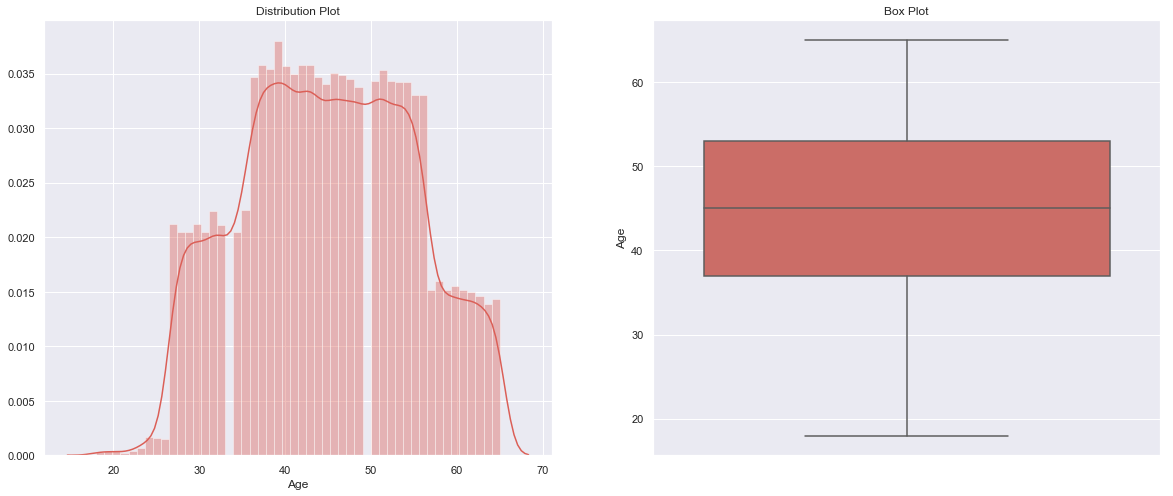

In [308]:
#Analyze the plots for the age Columns again after removing the outliers
draw_univariate_plot(Cred_demo_df,"Age")

### Univariate Analysis for  Gender

In [309]:
# Frequency of the Applicants based on the Gender
get_column_frequency(Cred_demo_df.Gender)

Gender
M     54402
F     16821
NaN       1

In [310]:
# Cleaning Acvitivity - Nulls is imputed with Male 
Cred_demo_df['Gender'].replace(np.nan,"M",inplace= True)

In [311]:
# Frequency of the Applicants based on the age
get_column_frequency(Cred_demo_df.Gender)

Gender
M   54403
F   16821

### Univariate Analysis on Marital Status (at the time of application)

In [312]:
# Frequency of the Applicants based on the Marital Status

get_column_frequency(Cred_demo_df['Marital Status (at the time of application)'])

Marital Status (at the time of application)
Married                                        60685
Single                                         10534
NaN                                                5

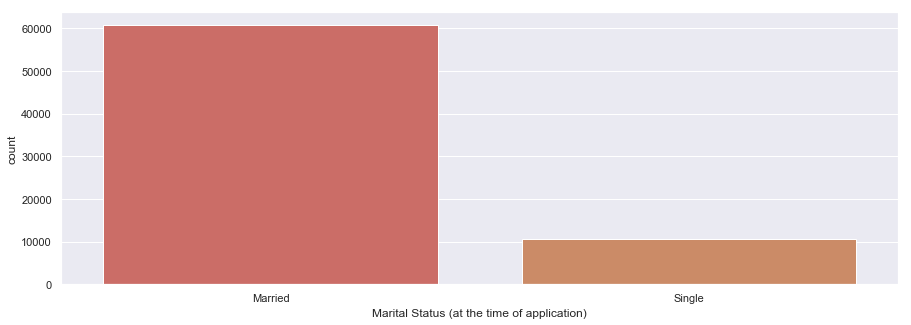

In [313]:
# Plotting count across a categorical variable 
draw_countplot(Cred_demo_df,"Marital Status (at the time of application)")

In [314]:
# Cleanup Activity - Replacing 5 Missing values in Marital Status column with Single category

Cred_demo_df['Marital Status (at the time of application)'].replace(np.nan,"Single",inplace= True)

In [315]:
# Frequency of the Applicants based on the Marital Status

get_column_frequency(Cred_demo_df['Marital Status (at the time of application)'])

Marital Status (at the time of application)
Married                                        60685
Single                                         10539

### Univariate Analysis on No of dependents feature

In [316]:
# Frequency of the Applicants based on the 'No of dependents'

get_column_frequency(Cred_demo_df['No of dependents'])

No of dependents
 3.0             16260
 1.0             15369
 2.0             15265
 4.0             12216
 5.0             12112
NaN                  2

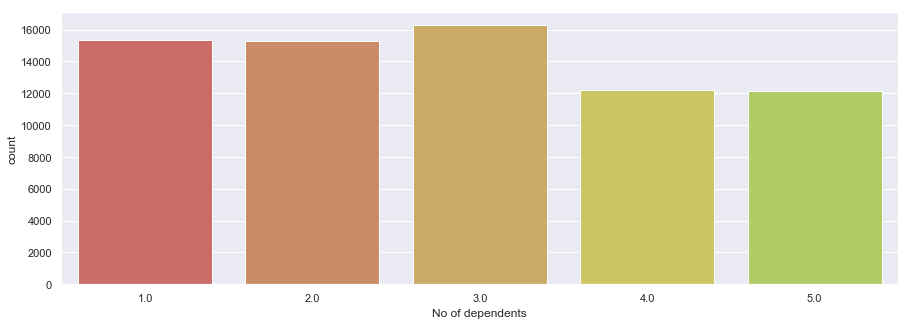

In [317]:
# Plotting count across a categorical variable 

draw_countplot(Cred_demo_df,"No of dependents")

In [318]:
# Cleaning Activity - Imputing 2 missing value with No Of Dependents feature

Cred_demo_df['No of dependents'].replace(np.nan,3,inplace= True)

In [319]:
# Frequency of the Applicants based on the 'No of dependents' after imputing

get_column_frequency(Cred_demo_df['No of dependents'])

No of dependents
3.0             16262
1.0             15369
2.0             15265
4.0             12216
5.0             12112

### Univariate Analysis on Income

In [320]:
# Frequency of the Applicants based on the 'Income' 

get_column_frequency(Cred_demo_df['Income'])

Income
 4.5     5230
 31.0    1448
 33.0    1445
 23.0    1442
 26.0    1441
 35.0    1439
 20.0    1437
 17.0    1404
 15.0    1402
 21.0    1396
 6.0     1396
 10.0    1390
 22.0    1389
 37.0    1382
 39.0    1379
 16.0    1375
 28.0    1374
 29.0    1373
 19.0    1370
 32.0    1365
 41.0    1363
 13.0    1363
 11.0    1359
 8.0     1349
 25.0    1348
 44.0    1346
 27.0    1343
 30.0    1341
 9.0     1339
 40.0    1330
...       ...
 7.0     1321
 38.0    1318
 36.0    1314
 14.0    1314
 12.0    1299
 24.0    1299
 45.0    1297
 5.0     1291
 42.0    1255
 46.0     931
 50.0     858
 49.0     857
 47.0     854
 48.0     838
 52.0     660
 55.0     655
 54.0     636
 53.0     624
 51.0     599
 56.0     534
 57.0     512
 59.0     497
 58.0     478
 60.0     449
-0.5       80
 4.0       40
 0.0       26
 3.0       23
 1.0       18
 2.0        9

[63 rows x 1 columns]

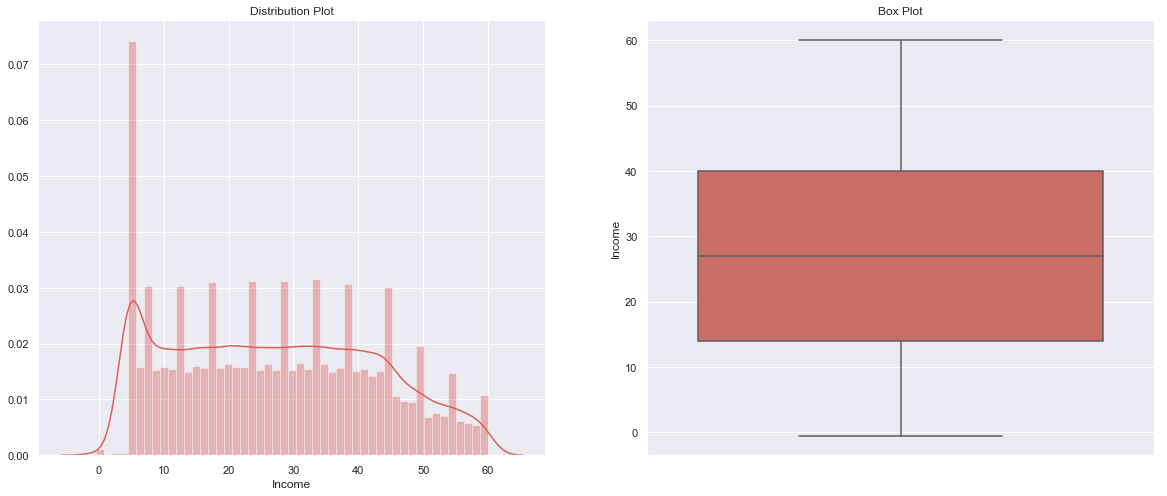

In [321]:
draw_univariate_plot(Cred_demo_df,"Income")

There are No missing value in Income feature

In [322]:
# Count of the applicants having income less than or equal 0 
len(Cred_demo_df[Cred_demo_df.Income<=0].index)

106

In [323]:
Cred_demo_df[Cred_demo_df.Income<=0]

Application ID  Age Gender Marital Status (at the time of application)  \
964         450723469   34      M                                     Married   
1058         24806681   22      M                                      Single   
1222        729552057   40      M                                     Married   
1278        805216817   32      M                                     Married   
1288        547253197   64      M                                     Married   
1343        373963488   48      M                                     Married   
1463         60246058   35      M                                     Married   
1565        861750337   52      M                                     Married   
1620        342846642   51      M                                     Married   
1731        671827529   41      M                                     Married   
1742        949700642   63      M                                      Single   
1755        445625202   46      F                                     Married   
1838        492426616   42      M                                      Single   
1864        856382859   34      M                                      Single   
1906         28529247   44      M                                     Married   
2001        376543424   35      M                                     Married   
2036        894546185   64      M                                     Married   
2043        281925114   32      M                                     Married   
2092        442521933   59      F                                     Married   
2126         72233026   65      M                                     Married   
2167        960040452   41      M                                     Married   
2223        129176358   45      M                                     Married   
2228        211825480   65      M                                     Married   
2246        730568473   41      M                                     Married   
2255        113089921   48      M                                     Married   
2381        909433618   54      M                                     Married   
2423        872069864   39      M                                     Married   
2528        220535428   42      F                                     Married   
2592        677808152   45      M                                      Single   
2599        926447901   35      M                                     Married   
...               ...  ...    ...                                         ...   
4139        998321323   43      M                                     Married   
4205        472741744   38      F                                     Married   
4213        562002069   35      M                                      Single   
4232        167737137   42      M                                     Married   
4259        621161091   33      F                                     Married   
4272        456708069   20      M                                     Married   
4279        151708319   45      F                                     Married   
4313        180723350   49      M                                     Married   
4330        563817048   26      F                                     Married   
4355        113741159   31      F                                     Married   
4395        552549350   19      F                                     Married   
4418         98920562   43      M                                     Married   
4522        335154728   39      M                                     Married   
4533        395613862   53      M                                     Married   
4624        278797628   48      M                                     Married   
4642        226478216   32      M                                     Married   
4681        315581350   40      M                                     Married   
4684        182508594   37      M     

In [324]:
# Cleaning Activity - Cant impute value in this ,hence removing the records

Cred_demo_df=Cred_demo_df[Cred_demo_df.Income>0]

In [325]:
# Analyse the shape of Dataframe fter rmoving applicant having Income <=0
Cred_demo_df.shape

(71118, 29)

### Univariate Analysis on Education

In [326]:
get_column_frequency(Cred_demo_df['Education'])

Education
Professional      24759
Masters           23922
Bachelor          17661
Phd                4537
Others              120
NaN                 119

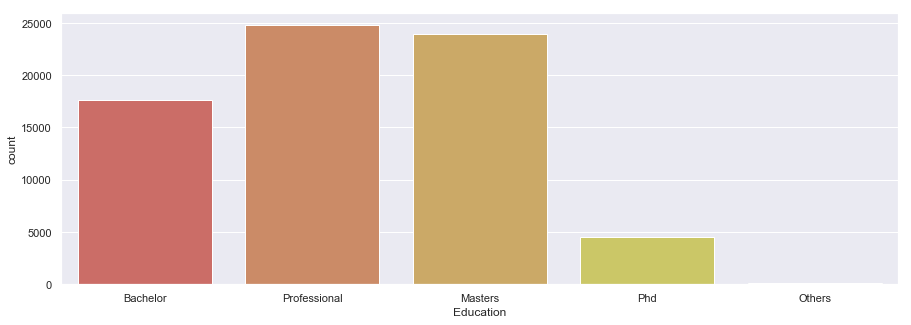

In [327]:
# Plotting count across a categorical variable 

draw_countplot(Cred_demo_df,"Education")

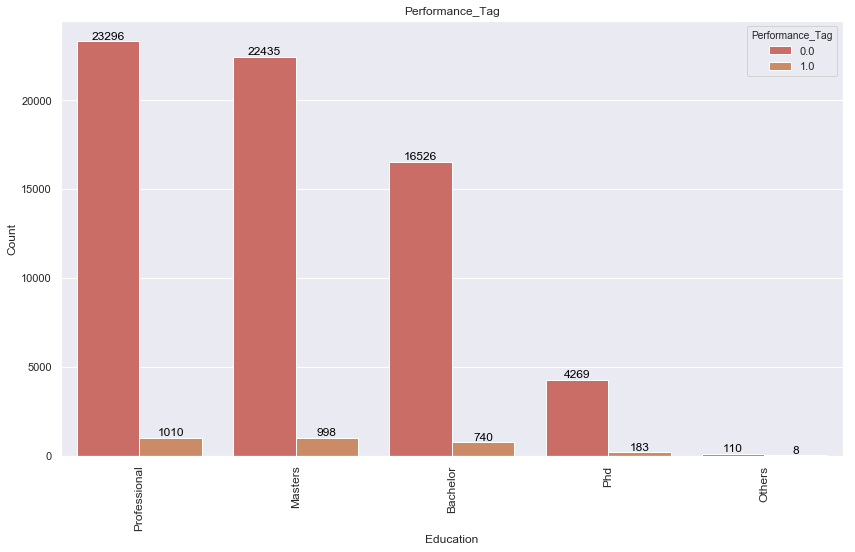

In [328]:
# Draw Graph w.r.t to the Performance Tag as this is our dependent columns

draw_plots(column_name='Education',title='Performance_Tag',df=Cred_demo_df,type_of_variable="Categorical",hue="Performance_Tag")

In [329]:
# Cleaning Activity - Imputing NaN values with 'Other' for Education
Cred_demo_df['Education'].replace(np.nan,"Others",inplace= True)

In [330]:
# Checking Missing Values count after imputation for Education Feature
get_column_frequency(Cred_demo_df['Education'])

Education
Professional      24759
Masters           23922
Bachelor          17661
Phd                4537
Others              239

### Univariate Analysis on Profession

In [331]:
# Checking Missing Values count 
get_column_frequency(Cred_demo_df['Profession'])

Profession
SAL           40338
SE_PROF       16492
SE            14276
NaN              12

INFO - 12 Missing values are present in the Profession Column

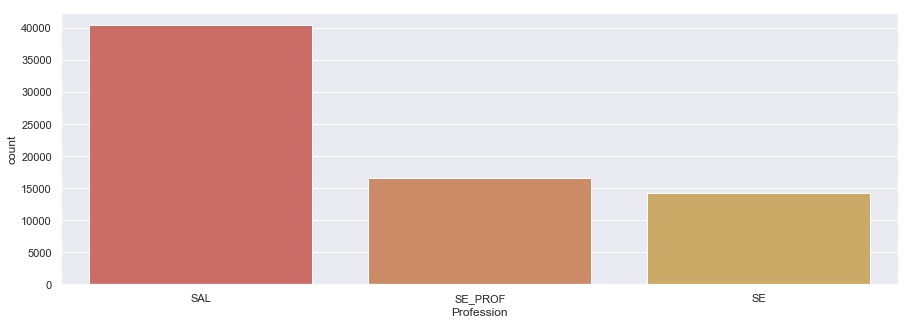

In [332]:
# Plotting count across a categorical variable 

draw_countplot(Cred_demo_df,"Profession")

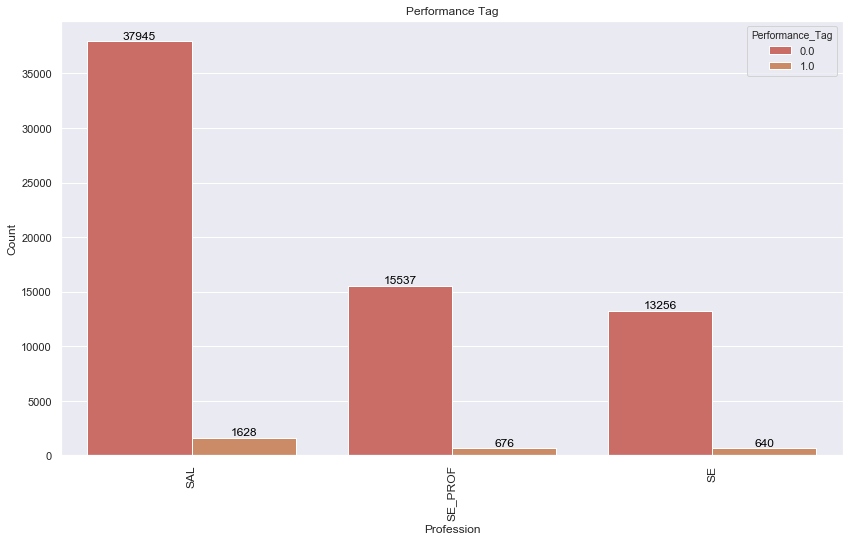

In [333]:
# Draw Graph w.r.t to the Performance Tag as this is our Profession columns

draw_plots(column_name='Profession',title='Performance Tag',df=Cred_demo_df,type_of_variable="Categorical",hue="Performance_Tag")

In [334]:
# Cleaning Activity - Replacing 12 missing values of Profession with SE
Cred_demo_df['Profession'].replace(np.nan,"SE",inplace= True)

In [335]:
# Checking Missing Values count 
get_column_frequency(Cred_demo_df['Profession'])

Profession
SAL           40338
SE_PROF       16492
SE            14288

### Univariate Analysis on Type of residence 

In [336]:
# Checking Missing Values count and frequenct 
get_column_frequency(Cred_demo_df['Type of residence'])

Type of residence
Rented                           53285
Owned                            14198
Living with Parents               1802
Company provided                  1626
Others                             199
NaN                                  8

INFO - There are 8 missing values in Type of residence  feature
     - Rented took more credit cards followed by Owned .....

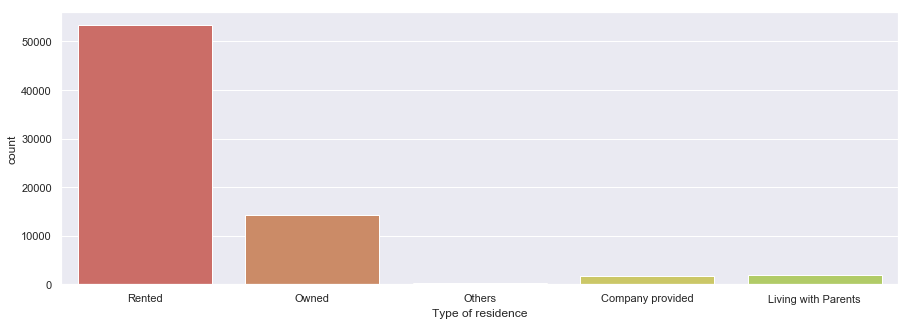

In [337]:
# Plotting count across a categorical variable 
draw_countplot(Cred_demo_df,"Type of residence")

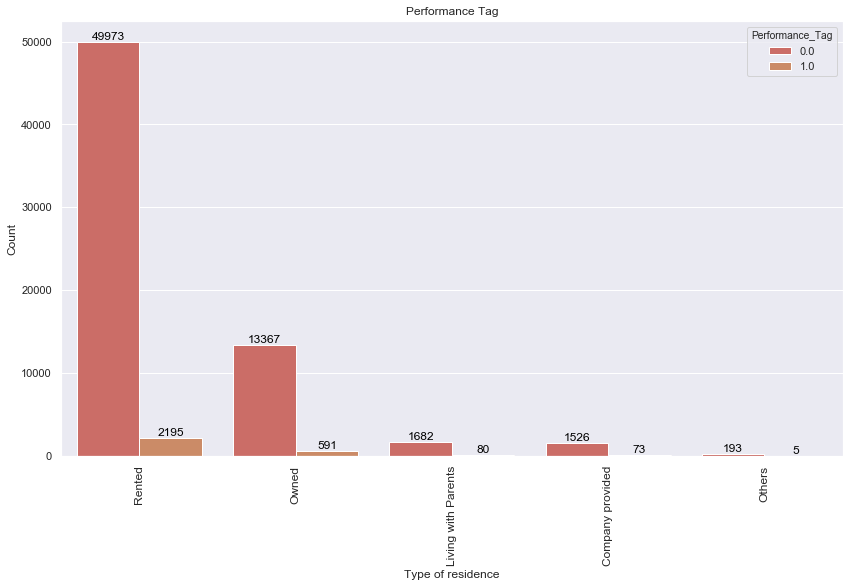

In [338]:
# Draw Graph w.r.t to the Performance Tag as this is our Type of residence columns

draw_plots(column_name='Type of residence',title='Performance Tag',df=Cred_demo_df,type_of_variable="Categorical",hue="Performance_Tag")

In [339]:
# Cleaning Activity - Imputing NaN values with Others category
Cred_demo_df['Type of residence'].replace(np.nan,"Others",inplace= True)

In [340]:
# Checking Missing Values count and frequenct 
get_column_frequency(Cred_demo_df['Type of residence'])

Type of residence
Rented                           53285
Owned                            14198
Living with Parents               1802
Company provided                  1626
Others                             207

## Univariate Analysis on Avgas CC Utilization in last 12 months

In [341]:
# Frequency of the Applicants based on the 'Income' 
get_column_frequency(Cred_demo_df['Avgas CC Utilization in last 12 months'])

Avgas CC Utilization in last 12 months
 8.0                                      3484
 9.0                                      3477
 7.0                                      3361
 10.0                                     3217
 113.0                                    3132
 6.0                                      2962
 11.0                                     2893
 12.0                                     2562
 5.0                                      2484
 13.0                                     2228
 4.0                                      1950
 14.0                                     1807
 3.0                                      1599
 15.0                                     1503
 16.0                                     1217
 17.0                                     1079
 2.0                                      1076
NaN                                       1051
 18.0                                      936
 19.0                                      798
 20.0                                      699
 21.0                                      691
 1.0                                       646
 23.0                                      601
 22.0                                      589
 24.0                                      567
 46.0                                      551
 41.0                                      544
 25.0                                      538
 48.0                                      530
...                                        ...
 82.0                                      134
 84.0                                      134
 86.0                                      128
 85.0                                      118
 87.0                                      109
 88.0                                       96
 90.0                                       92
 93.0                                       85
 89.0                                       82
 92.0                                       76
 91.0                                       75
 98.0                                       58
 95.0                                       55
 103.0                                      54
 94.0                                       52
 96.0                                       52
 104.0                                      45
 106.0                                      45
 102.0                                      44
 108.0                                      43
 100.0                                      43
 105.0                                      42
 101.0                                      42
 112.0                                      41
 107.0                                      39
 97.0                                       38
 99.0                                       36
 111.0                                      36
 109.0                                      33
 110.0                                      30

[115 rows x 1 columns]

INFO - There are 1051 missing values in Avgas CC Utilization in last 12 months.

In [342]:
Cred_demo_df['Avgas CC Utilization in last 12 months'].describe()

count    70067.000000
mean        29.738479
std         29.546903
min          0.000000
25%          8.000000
50%         15.000000
75%         46.000000
max        113.000000
Name: Avgas CC Utilization in last 12 months, dtype: float64

In [343]:
# Cleaning Activity - Dropping rows having NaN values in 'Avgas CC Utilization in last 12 months'
Cred_demo_df=Cred_demo_df[~np.isnan(Cred_demo_df['Avgas CC Utilization in last 12 months'])]

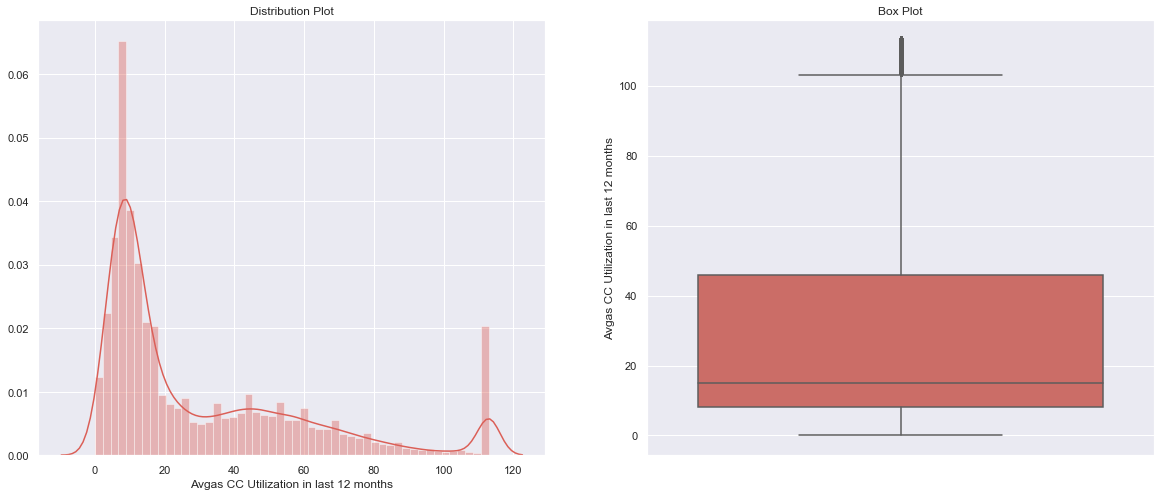

In [344]:
draw_univariate_plot(Cred_demo_df,"Avgas CC Utilization in last 12 months")

INFO - There are rows with credit card utilization more than 100%

In [345]:
# Count of rows having credit card utilization mora than 100 %
len(Cred_demo_df[Cred_demo_df['Avgas CC Utilization in last 12 months']>100].index)

3626

In [346]:
# Rows having credit card utilization as more than 100%
Cred_demo_df[Cred_demo_df['Avgas CC Utilization in last 12 months']>100]

Application ID  Age Gender Marital Status (at the time of application)  \
40003       738449145   50      M                                     Married   
40005       580811761   39      F                                     Married   
40006       468901168   37      M                                     Married   
40008        42796133   57      M                                     Married   
40010       454080217   42      M                                      Single   
40011       586774252   56      M                                     Married   
40012       346835862   37      M                                     Married   
40014       449491685   61      M                                     Married   
40016       167056899   33      M                                      Single   
40020       744081506   64      F                                     Married   
40021       756880680   56      M                                     Married   
40024       494918718   44      M                                     Married   
40029       947102186   55      M                                     Married   
40036       608051829   61      M                                     Married   
40038       854974256   39      M                                     Married   
40040       207302364   63      M                                     Married   
40043       950551215   51      F                                     Married   
40044       128192242   42      M                                      Single   
40047       355104917   43      M                                     Married   
40049       154817679   43      M                                     Married   
40050       550999245   52      M                                      Single   
40051       105749914   41      M                                      Single   
40052       883219994   63      M                                     Married   
40053       925037864   48      M                                     Married   
40055       978160031   33      M                                     Married   
40057       402345568   31      F                                     Married   
40059       156387592   48      M                                     Married   
40061       101264877   36      M                                      Single   
40063        81018255   39      F                                     Married   
40068       320960122   51      M                                     Married   
...               ...  ...    ...                                         ...   
46946       670225137   40      F                                     Married   
46947       256770643   30      M                                     Married   
46948       739684074   61      M                                     Married   
46950       493806696   28      M                                     Married   
46952       785918337   39      M                                     Married   
46955       774170826   46      F                                     Married   
46957       953507219   40      M                                     Married   
46959       795223519   52      M                                     Married   
46960       426781469   60      F                                     Married   
46961       438727102   59      F                                     Married   
46963       355775936   43      M                                     Married   
46964       863796922   31      F                                      Single   
46965       315255250   55      F                                     Married   
46966       910521163   42      F                                     Married   
46968       954268074   51      M                                     Married   
46969       694084057   38      M                                     Married   
46979       446724252   27      F                                     Married   
46980       556845680   52      M     

In [347]:
# Imputing rows with credit card utilization more than 100 % with 100
Cred_demo_df['Avgas CC Utilization in last 12 months'].values[Cred_demo_df['Avgas CC Utilization in last 12 months']>100]=100

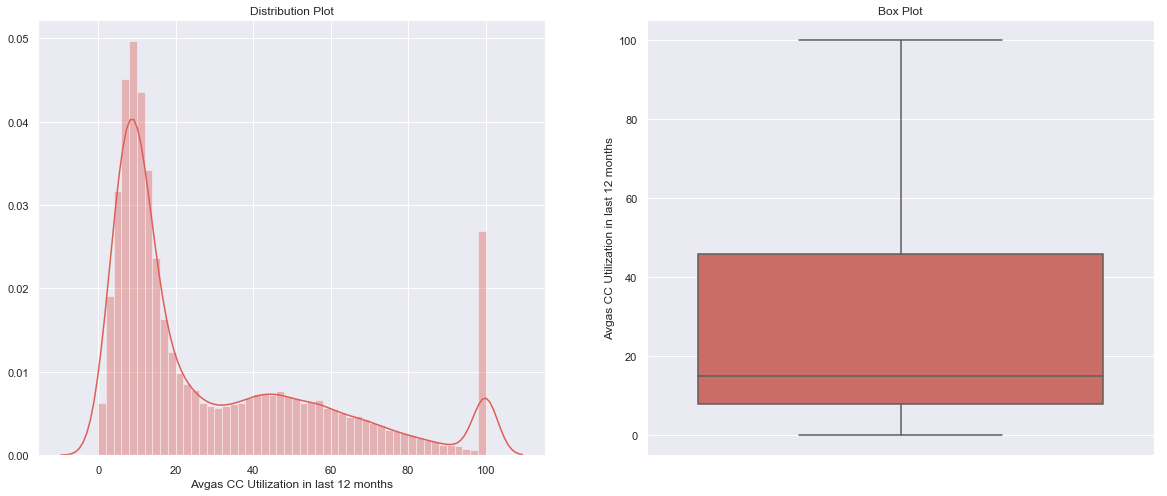

In [348]:
draw_univariate_plot(Cred_demo_df,"Avgas CC Utilization in last 12 months")

### Univariate analysis on Performance_Tag

In [349]:
# Checking Missing Values count 
get_column_frequency(Cred_demo_df['Performance_Tag'])

Performance_Tag
 0.0            65781
 1.0             2896
NaN              1390

INFO - There are 1390 rows for which Performance Tag is missing

In [350]:
# Create another dataframe with rejected Applications 
rejected_cre_demo_df = Cred_demo_df[np.isnan(Cred_demo_df['Performance_Tag'])]

In [351]:
# Cleaning Activity - Dropping Rows having NaN in Performance Tag, which means dropping applicants who has not used credit cards

Cred_demo_df=Cred_demo_df[~np.isnan(Cred_demo_df['Performance_Tag'])]



In [352]:
# Checking Missing Values count 
get_column_frequency(Cred_demo_df['Performance_Tag'])

Performance_Tag
0.0            65781
1.0             2896

### Now the EDA process is completed as we dont have any null values in Dataframe 

In [353]:
###Fetch the nulls summary of the whole dataset ordered by descending
get_nulls_report(Cred_demo_df)

##  WOE imputation on Demographic Data starts here

In [354]:
## Calling the function to find the WOE value and the IV for the dataframe
cd_final_iv, cd_IV = woe_iv_generator(Cred_demo_df,Cred_demo_df.Performance_Tag)

In [355]:
#Analyse the dataframe , and we can see the WOE value been calculated for the bins which is automaticaly created

cd_final_iv.head(10)

VAR_NAME  MIN_VALUE   MAX_VALUE  COUNT  \
0                               Application ID     100450   498048313  34339   
1                               Application ID  498049101  1000084142  34338   
2                                          Age         18          40  24142   
3                                          Age         41          50  22506   
4                                          Age         51          65  22029   
5                                       Gender          F           F  16224   
6                                       Gender          M           M  52453   
7  Marital Status (at the time of application)    Married     Married  58522   
8  Marital Status (at the time of application)     Single      Single  10155   
9                             No of dependents          1           3  45210   

    EVENT  EVENT_RATE  NONEVENT  NON_EVENT_RATE  DIST_EVENT  DIST_NON_EVENT  \
0  1449.0    0.042197   32890.0        0.957803    0.500345        0.499992   
1  1447.0    0.042140   32891.0        0.957860    0.499655        0.500008   
2  1055.0    0.043700   23087.0        0.956300    0.364296        0.350968   
3   938.0    0.041678   21568.0        0.958322    0.323895        0.327876   
4   903.0    0.040991   21126.0        0.959009    0.311809        0.321157   
5   704.0    0.043393   15520.0        0.956607    0.243094        0.235934   
6  2192.0    0.041790   50261.0        0.958210    0.756906        0.764066   
7  2459.0    0.042018   56063.0        0.957982    0.849102        0.852267   
8   437.0    0.043033    9718.0        0.956967    0.150898        0.147733   
9  1919.0    0.042446   43291.0        0.957554    0.662638        0.658108   

        WOE            IV  
0  0.000706  4.981674e-07  
1 -0.000706  4.981674e-07  
2  0.037272  8.214674e-04  
3 -0.012215  8.214674e-04  
4 -0.029537  8.214674e-04  
5  0.029894  2.814314e-04  
6 -0.009414  2.814314e-04  
7 -0.003721  7.887386e-05  
8  0.021199  7.887386e-05  
9  0.006860  9.150396e-05

In [356]:
# checking the Information Value for the Columns

cd_IV.sort_values('IV')

VAR_NAME            IV
1                                      Application ID  4.981674e-07
6         Marital Status (at the time of application)  7.887386e-05
11                                   No of dependents  9.150396e-05
4                                              Gender  2.814314e-04
3                                           Education  5.306415e-04
0                                                 Age  8.214674e-04
27                                  Type of residence  1.060551e-03
23                         Presence of open auto loan  1.582015e-03
25                                         Profession  1.927111e-03
22                                Outstanding Balance  7.256500e-03
12                    No of months in current company  1.294320e-02
24                         Presence of open home loan  1.719923e-02
19       No of times 90 DPD or worse in last 6 months  3.064723e-02
5                                              Income  3.815208e-02
13                  No of months in current residence  5.347233e-02
17       No of times 60 DPD or worse in last 6 months  9.082585e-02
8   No of Inquiries in last 6 months (excluding ho...  9.544791e-02
21               No of trades opened in last 6 months  9.684985e-02
18      No of times 90 DPD or worse in last 12 months  9.709239e-02
10            No of PL trades opened in last 6 months  1.271389e-01
16      No of times 60 DPD or worse in last 12 months  1.397377e-01
15       No of times 30 DPD or worse in last 6 months  1.472892e-01
26                                 Total No of Trades  1.496399e-01
9            No of PL trades opened in last 12 months  1.818182e-01
14      No of times 30 DPD or worse in last 12 months  1.909604e-01
7   No of Inquiries in last 12 months (excluding h...  2.424522e-01
20              No of trades opened in last 12 months  2.728560e-01
2              Avgas CC Utilization in last 12 months  2.982032e-01

## Replacing WOE values in the dataframe columns

In [357]:
Cred_demo_df.columns

Index(['Application ID', 'Age', 'Gender',
       'Marital Status (at the time of application)', 'No of dependents',
       'Income', 'Education', 'Profession', 'Type of residence',
       'No of months in current residence', 'No of months in current company',
       'No of times 90 DPD or worse in last 6 months',
       'No of times 60 DPD or worse in last 6 months',
       'No of times 30 DPD or worse in last 6 months',
       'No of times 90 DPD or worse in last 12 months',
       'No of times 60 DPD or worse in last 12 months',
       'No of times 30 DPD or worse in last 12 months',
       'Avgas CC Utilization in last 12 months',
       'No of trades opened in last 6 months',
       'No of trades opened in last 12 months',
       'No of PL trades opened in last 6 months',
       'No of PL trades opened in last 12 months',
       'No of Inquiries in last 6 months (excluding home & auto loans)',
       'No of Inquiries in last 12 months (excluding home & auto loans)',
       'Presenc

In [358]:
original_column_list = Cred_demo_df.columns.difference(['Performance_Tag'])

In [359]:
original_column_list

Index(['Age', 'Application ID', 'Avgas CC Utilization in last 12 months',
       'Education', 'Gender', 'Income',
       'Marital Status (at the time of application)',
       'No of Inquiries in last 12 months (excluding home & auto loans)',
       'No of Inquiries in last 6 months (excluding home & auto loans)',
       'No of PL trades opened in last 12 months',
       'No of PL trades opened in last 6 months', 'No of dependents',
       'No of months in current company', 'No of months in current residence',
       'No of times 30 DPD or worse in last 12 months',
       'No of times 30 DPD or worse in last 6 months',
       'No of times 60 DPD or worse in last 12 months',
       'No of times 60 DPD or worse in last 6 months',
       'No of times 90 DPD or worse in last 12 months',
       'No of times 90 DPD or worse in last 6 months',
       'No of trades opened in last 12 months',
       'No of trades opened in last 6 months', 'Outstanding Balance',
       'Presence of open auto loan

In [360]:
# tranforming the Dataframe with the WOE values from the bins of the columns 

transform_prefix = ''
for var in original_column_list:
    small_df = cd_final_iv[cd_final_iv['VAR_NAME'] == var]
    transform_dict = dict(zip(small_df.MAX_VALUE,small_df.WOE))
    replace_cmd = ''
    replace_cmd1 = ''
    for i in sorted(transform_dict.items()):
        replace_cmd = replace_cmd + str(i[1]) + str(' if x <= ') + str(i[0]) + ' else '
        replace_cmd1 = replace_cmd1 + str(i[1]) + str(' if x == "') + str(i[0]) + '" else '
    replace_cmd = replace_cmd + '0'
    replace_cmd1 = replace_cmd1 + '0'
    if replace_cmd != '0':
        try:
            Cred_demo_df[transform_prefix + var] = Cred_demo_df[var].apply(lambda x: eval(replace_cmd))
        except:
            Cred_demo_df[transform_prefix + var] = Cred_demo_df[var].apply(lambda x: eval(replace_cmd1))

In [361]:
# Checking Distinct Values in the Age Column now
get_column_frequency(Cred_demo_df['Age'])

Age
 0.037272  24142
-0.012215  22506
-0.029537  22029

In [362]:
# Checking Distinct Values in the Education Column now
get_column_frequency(Cred_demo_df['Education'])

Education
-0.013975      23962
 0.000446      23088
 0.018598      17006
-0.017735       4390
 0.303455        231

In [363]:
# Checking Distinct Values in the Age Column now
get_column_frequency(Cred_demo_df['Profession'])

Profession
-0.026036       38999
-0.013278       15972
 0.085184       13706

In [364]:
# Checking info of new dataframe i.e imputed with WOE values
Cred_demo_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68677 entries, 0 to 71300
Data columns (total 29 columns):
Application ID                                                     68677 non-null float64
Age                                                                68677 non-null float64
Gender                                                             68677 non-null float64
Marital Status (at the time of application)                        68677 non-null float64
No of dependents                                                   68677 non-null float64
Income                                                             68677 non-null float64
Education                                                          68677 non-null float64
Profession                                                         68677 non-null float64
Type of residence                                                  68677 non-null float64
No of months in current residence                                  68677 non-null

In [365]:
Cred_demo_df.head()

Application ID       Age    Gender  \
0       -0.000706 -0.012215  0.029894   
1        0.000706  0.037272 -0.009414   
2       -0.000706  0.037272 -0.009414   
3        0.000706 -0.012215 -0.009414   
4        0.000706  0.037272  0.029894   

   Marital Status (at the time of application)  No of dependents    Income  \
0                                    -0.003721          0.006860 -0.243413   
1                                    -0.003721         -0.013339 -0.266523   
2                                     0.021199          0.006860 -0.266523   
3                                    -0.003721          0.006860 -0.266523   
4                                    -0.003721         -0.013339 -0.243413   

   Education  Profession  Type of residence  \
0   0.018598   -0.026036          -0.002449   
1  -0.013975   -0.013278          -0.002449   
2   0.018598   -0.013278          -0.002449   
3   0.018598    0.085184          -0.002449   
4  -0.013975   -0.026036          -0.002449   

   No of months in current residence       ...         \
0                           0.209292       ...          
1                           0.209292       ...          
2                           0.209292       ...          
3                           0.209292       ...          
4                           0.209292       ...          

   No of trades opened in last 12 months  \
0                              -0.921961   
1                              -0.921961   
2                              -0.921961   
3                              -0.921961   
4                              -0.921961   

   No of PL trades opened in last 6 months  \
0                                -0.322038   
1                                -0.322038   
2                                -0.322038   
3                                -0.322038   
4                                -0.322038   

   No of PL trades opened in last 12 months  \
0                                 -0.467654   
1                                 -0.467654   
2                                 -0.467654   
3                                 -0.467654   
4                                 -0.467654   

   No of Inquiries in last 6 months (excluding home & auto loans)  \
0                                          -0.329645                
1                                          -0.329645                
2                                          -0.329645                
3                                          -0.329645                
4                                          -0.329645                

   No of Inquiries in last 12 months (excluding home & auto loans)  \
0                                          -0.881116                 
1                                          -0.881116                 
2                                          -0.881116                 
3                                          -0.881116                 
4                                          -0.881116                 

   Presence of open home loan  Outstanding Balance  Total No of Trades  \
0                   -0.236386             0.081951           -0.439224   
1                    0.072864            -0.088601           -0.439224   
2                   -0.236386             0.081951           -0.439224   
3                   -0.236386             0.081951           -0.439224   
4                   -0.236386             0.081951           -0.439224   

   Presence of open auto loan  Performance_Tag  
0                    0.011804              0.0  
1                    0.011804              0.0  
2                    0.011804              0.0  
3                   -0.134042              0.0  
4                    0.011804              0.0  

[5 rows x 29 columns]

INFO - With the above exercise , we have successfully imputed values of WOE in the dataframe

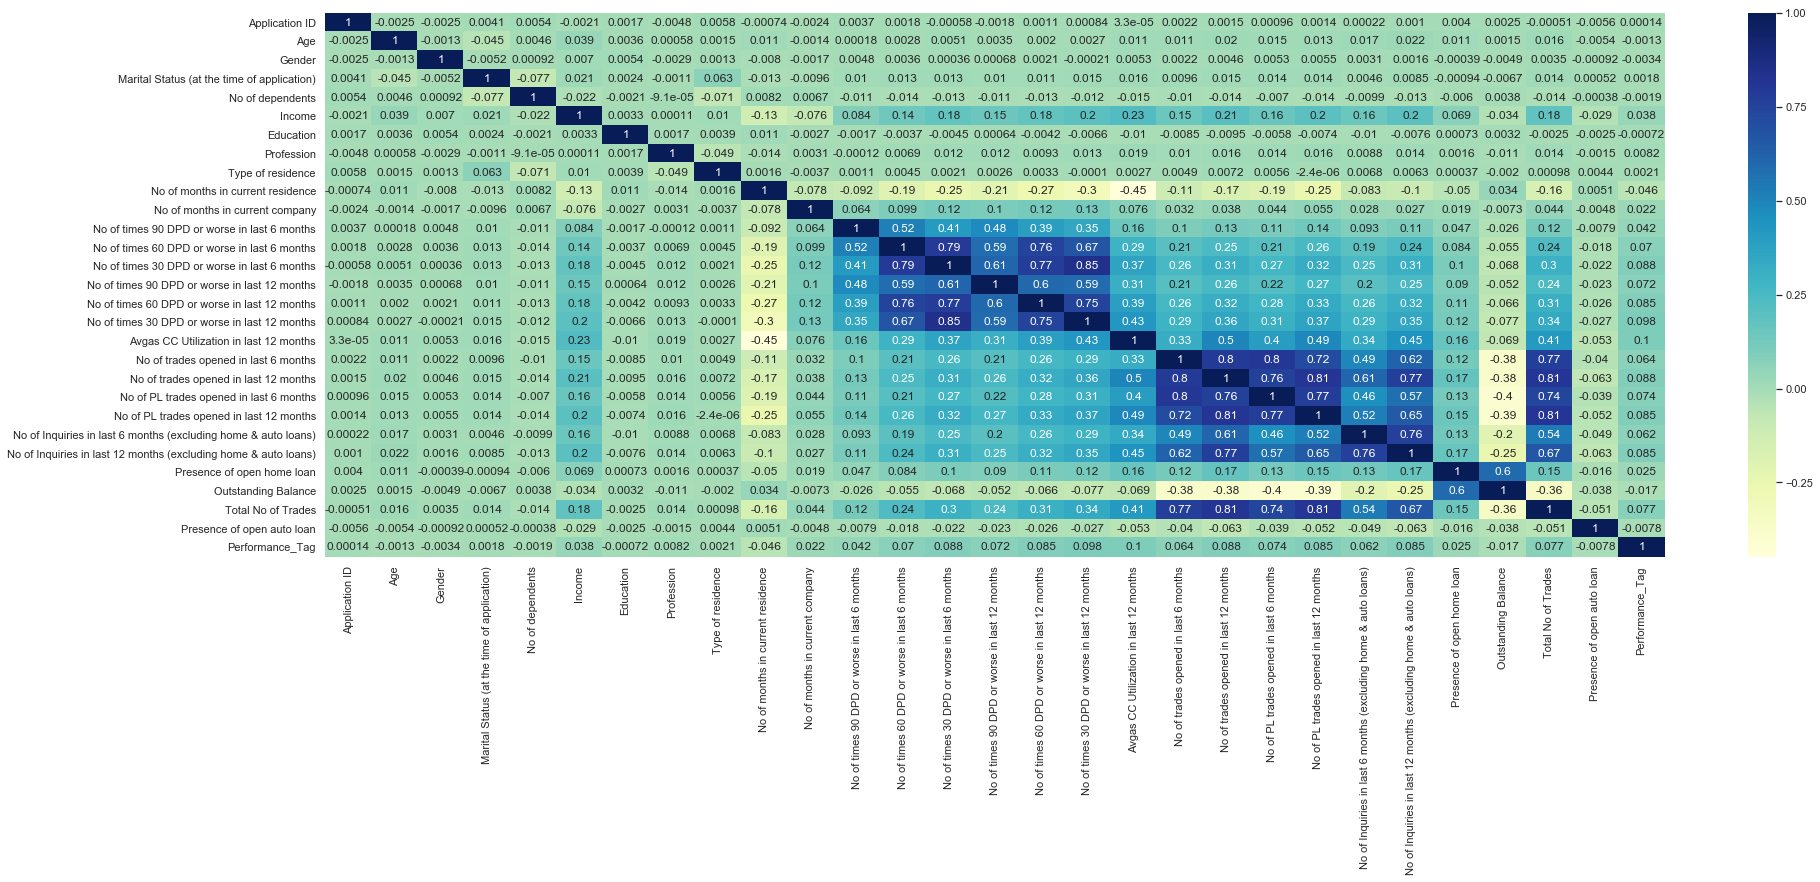

In [366]:
#Check of Correlation with the help of Heat Map

plt.figure(figsize = (30,10)) 
sns.heatmap(Cred_demo_df.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1), annot=True,cmap="YlGnBu")
plt.show()

##  WOE implementation ends here

### Selecting features with meaningfull Predictive Powers

In [367]:
##Choosing columns which are significant on basis of IV value
Cred_demo_df_IV=Cred_demo_df[['Income','No of months in current residence','No of times 90 DPD or worse in last 6 months','No of times 60 DPD or worse in last 6 months','No of times 30 DPD or worse in last 6 months','No of times 90 DPD or worse in last 12 months','No of times 60 DPD or worse in last 12 months','No of times 30 DPD or worse in last 12 months','Avgas CC Utilization in last 12 months','No of trades opened in last 6 months','No of trades opened in last 12 months','No of PL trades opened in last 6 months','No of PL trades opened in last 12 months','No of Inquiries in last 6 months (excluding home & auto loans)','No of Inquiries in last 12 months (excluding home & auto loans)','Total No of Trades','Outstanding Balance','Performance_Tag']]

In [368]:
Cred_demo_df_IV.head()

Income  No of months in current residence  \
0 -0.243413                           0.209292   
1 -0.266523                           0.209292   
2 -0.266523                           0.209292   
3 -0.266523                           0.209292   
4 -0.243413                           0.209292   

   No of times 90 DPD or worse in last 6 months  \
0                                      -0.03695   
1                                      -0.03695   
2                                      -0.03695   
3                                      -0.03695   
4                                      -0.03695   

   No of times 60 DPD or worse in last 6 months  \
0                                     -0.123139   
1                                     -0.123139   
2                                     -0.123139   
3                                     -0.123139   
4                                     -0.123139   

   No of times 30 DPD or worse in last 6 months  \
0                                     -0.201224   
1                                     -0.201224   
2                                     -0.201224   
3                                     -0.201224   
4                                     -0.201224   

   No of times 90 DPD or worse in last 12 months  \
0                                      -0.135624   
1                                      -0.135624   
2                                      -0.135624   
3                                      -0.135624   
4                                      -0.135624   

   No of times 60 DPD or worse in last 12 months  \
0                                      -0.203924   
1                                      -0.203924   
2                                      -0.203924   
3                                      -0.203924   
4                                      -0.203924   

   No of times 30 DPD or worse in last 12 months  \
0                                      -0.273638   
1                                      -0.273638   
2                                      -0.273638   
3                                      -0.273638   
4                                      -0.273638   

   Avgas CC Utilization in last 12 months  \
0                               -0.799174   
1                               -0.799174   
2                               -0.799174   
3                               -0.573287   
4                               -0.573287   

   No of trades opened in last 6 months  \
0                             -0.276622   
1                             -0.276622   
2                             -0.276622   
3                             -0.276622   
4                             -0.276622   

   No of trades opened in last 12 months  \
0                              -0.921961   
1                              -0.921961   
2                              -0.921961   
3                              -0.921961   
4                              -0.921961   

   No of PL trades opened in last 6 months  \
0                                -0.322038   
1                                -0.322038   
2                                -0.322038   
3                                -0.322038   
4                                -0.322038   

   No of PL trades opened in last 12 months  \
0                                 -0.467654   
1                                 -0.467654   
2                                 -0.467654   
3                                 -0.467654   
4                                 -0.467654   

   No of Inquiries in last 6 months (excluding home & auto loans)  \
0                                          -0.329645                
1                                          -0.329645                
2                                          -0.329645                
3                                          -0.329645                
4                                          -0.329645                

   No of Inquiries in last 12 months (excluding home & auto loans)  \
0   

In [369]:
# Describing new dataframe's mean, median, mode, max to have an idea of outliers
Cred_demo_df_IV.describe()

Income  No of months in current residence  \
count  68677.000000                       68677.000000   
mean      -0.017441                          -0.024692   
std        0.194763                           0.232962   
min       -0.266523                          -0.256634   
25%       -0.243413                          -0.256634   
50%        0.048578                          -0.256634   
75%        0.067495                           0.209292   
max        0.290883                           0.209292   

       No of times 90 DPD or worse in last 6 months  \
count                                  68677.000000   
mean                                      -0.012025   
std                                        0.145003   
min                                       -0.036950   
25%                                       -0.036950   
50%                                       -0.036950   
75%                                       -0.036950   
max                                        0.831527   

       No of times 60 DPD or worse in last 6 months  \
count                                  68677.000000   
mean                                      -0.036934   
std                                        0.259326   
min                                       -0.123139   
25%                                       -0.123139   
50%                                       -0.123139   
75%                                       -0.123139   
max                                        0.743167   

       No of times 30 DPD or worse in last 6 months  \
count                                  68677.000000   
mean                                      -0.060873   
std                                        0.335477   
min                                       -0.201224   
25%                                       -0.201224   
50%                                       -0.201224   
75%                                       -0.201224   
max                                        0.740995   

       No of times 90 DPD or worse in last 12 months  \
count                                   68677.000000   
mean                                       -0.039752   
std                                         0.270189   
min                                        -0.135624   
25%                                        -0.135624   
50%                                        -0.135624   
75%                                        -0.135624   
max                                         0.721691   

       No of times 60 DPD or worse in last 12 months  \
count                                   68677.000000   
mean                                       -0.058327   
std                                         0.330804   
min                                        -0.203924   
25%                                        -0.203924   
50%                                        -0.203924   
75%                                        -0.203924   
max                                         0.693265   

       No of times 30 DPD or worse in last 12 months  \
count                                   68677.000000   
mean                                       -0.080564   
std                                         0.390461   
min                                        -0.273638   
25%                                        -0.273638   
50%                                        -0.273638   
75%                                        -0.273638   
max                                         0.709071   

       Avgas CC Utilization in last 12 months  \
count                            68677.000000   
mean                                -0.142907   
std                                  0.568556   
min                                 -0.799174   
25%                                 -0.799174   
50%                                 -0.573287   
75%                                  0.369464   
max                                  0.499445   

       No of trades opened in last 6 months  

In [370]:
Cred_demo_df_IV.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68677 entries, 0 to 71300
Data columns (total 18 columns):
Income                                                             68677 non-null float64
No of months in current residence                                  68677 non-null float64
No of times 90 DPD or worse in last 6 months                       68677 non-null float64
No of times 60 DPD or worse in last 6 months                       68677 non-null float64
No of times 30 DPD or worse in last 6 months                       68677 non-null float64
No of times 90 DPD or worse in last 12 months                      68677 non-null float64
No of times 60 DPD or worse in last 12 months                      68677 non-null float64
No of times 30 DPD or worse in last 12 months                      68677 non-null float64
Avgas CC Utilization in last 12 months                             68677 non-null float64
No of trades opened in last 6 months                               68677 non-null

In [371]:
Cred_demo_df_IV.shape

(68677, 18)

In [372]:
# Calculating Percentage of Data we are left with after Cleaning
(len(Cred_demo_df_IV.index)/71301)*100


96.31982721139956

INFO - We have lost only 4% of total data during Cleaning

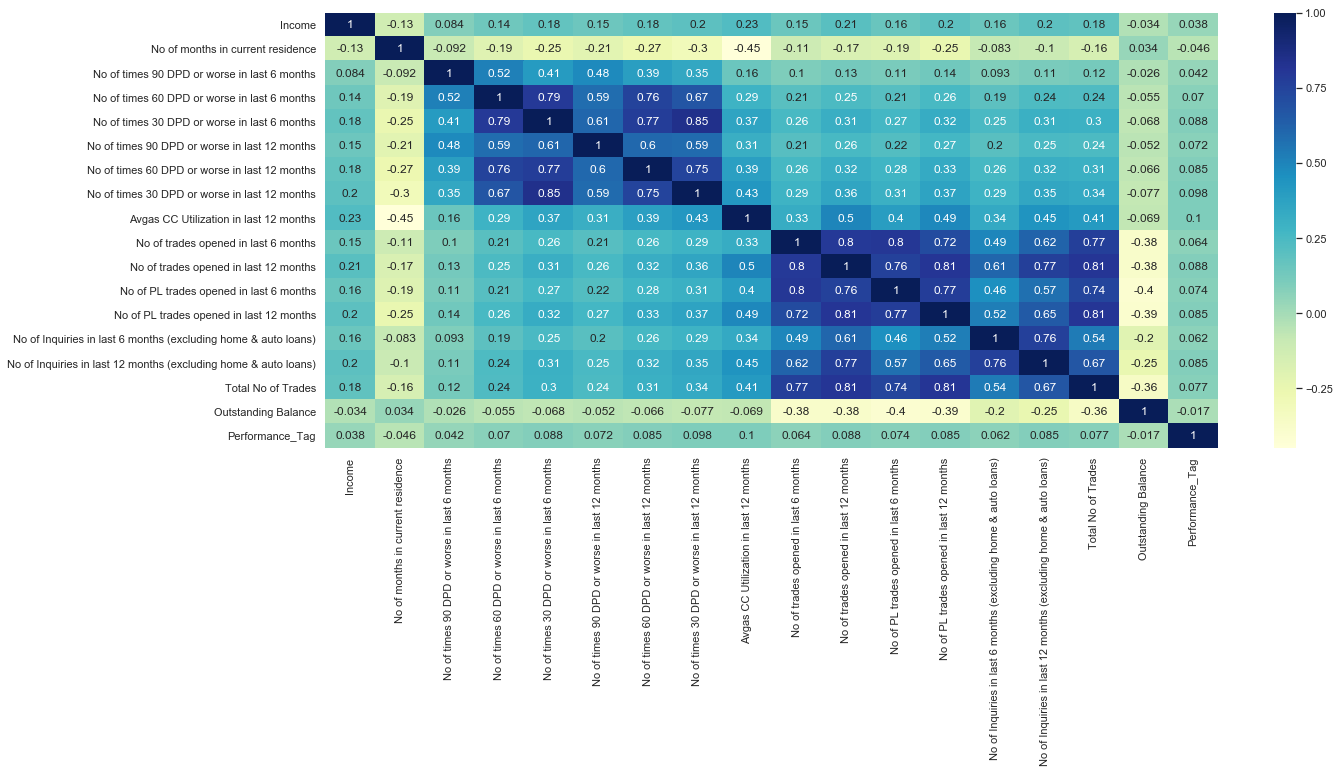

In [373]:
#Check of Correlation with the help of Heat Map

plt.figure(figsize = (20,8)) 
sns.heatmap(Cred_demo_df_IV.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1), annot=True,cmap="YlGnBu")
plt.show()

### Outlier Detection and treatment

In [374]:
# Checking outliers at 25%, 50%, 75%, 90%, 95% and 99%
Cred_demo_df_IV.describe(percentiles=[.25, .5, .75, .90, .95, .99])

Income  No of months in current residence  \
count  68677.000000                       68677.000000   
mean      -0.017441                          -0.024692   
std        0.194763                           0.232962   
min       -0.266523                          -0.256634   
25%       -0.243413                          -0.256634   
50%        0.048578                          -0.256634   
75%        0.067495                           0.209292   
90%        0.290883                           0.209292   
95%        0.290883                           0.209292   
99%        0.290883                           0.209292   
max        0.290883                           0.209292   

       No of times 90 DPD or worse in last 6 months  \
count                                  68677.000000   
mean                                      -0.012025   
std                                        0.145003   
min                                       -0.036950   
25%                                       -0.036950   
50%                                       -0.036950   
75%                                       -0.036950   
90%                                       -0.036950   
95%                                       -0.036950   
99%                                        0.831527   
max                                        0.831527   

       No of times 60 DPD or worse in last 6 months  \
count                                  68677.000000   
mean                                      -0.036934   
std                                        0.259326   
min                                       -0.123139   
25%                                       -0.123139   
50%                                       -0.123139   
75%                                       -0.123139   
90%                                       -0.123139   
95%                                        0.743167   
99%                                        0.743167   
max                                        0.743167   

       No of times 30 DPD or worse in last 6 months  \
count                                  68677.000000   
mean                                      -0.060873   
std                                        0.335477   
min                                       -0.201224   
25%                                       -0.201224   
50%                                       -0.201224   
75%                                       -0.201224   
90%                                        0.740995   
95%                                        0.740995   
99%                                        0.740995   
max                                        0.740995   

       No of times 90 DPD or worse in last 12 months  \
count                                   68677.000000   
mean                                       -0.039752   
std                                         0.270189   
min                                        -0.135624   
25%                                        -0.135624   
50%                                        -0.135624   
75%                                        -0.135624   
90%                                         0.721691   
95%                                         0.721691   
99%                                         0.721691   
max                                         0.721691   

       No of times 60 DPD or worse in last 12 months  \
count                                   68677.000000   
mean                                       -0.058327   
std                                         0.330804   
min                                        -0.203924   
25%                                        -0.203924   
50%                                        -0.203924   
75%                                        -0.203924   
90%                                         0.693265   
95%                                         0.693265   
99%                                         0.693265   
max                                         

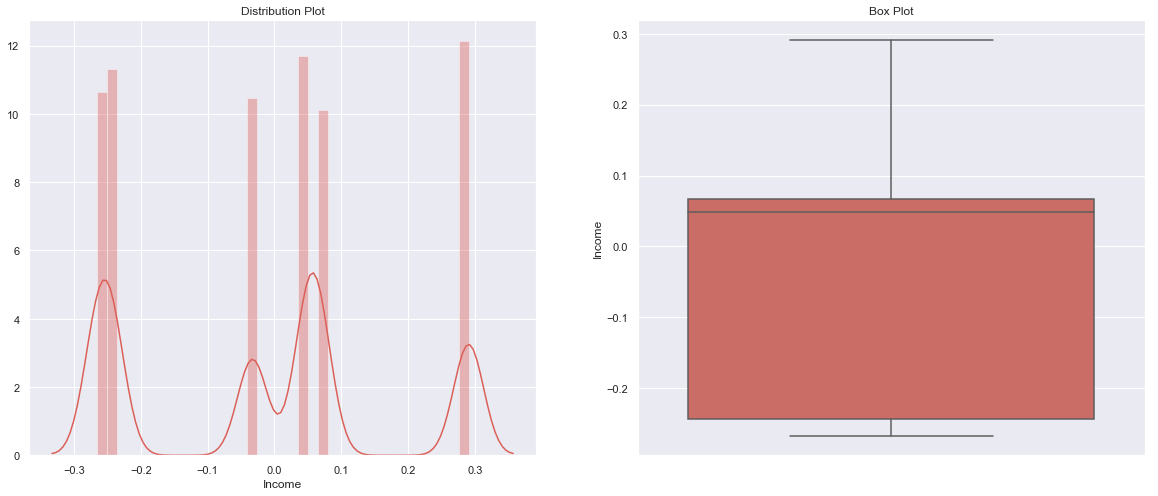

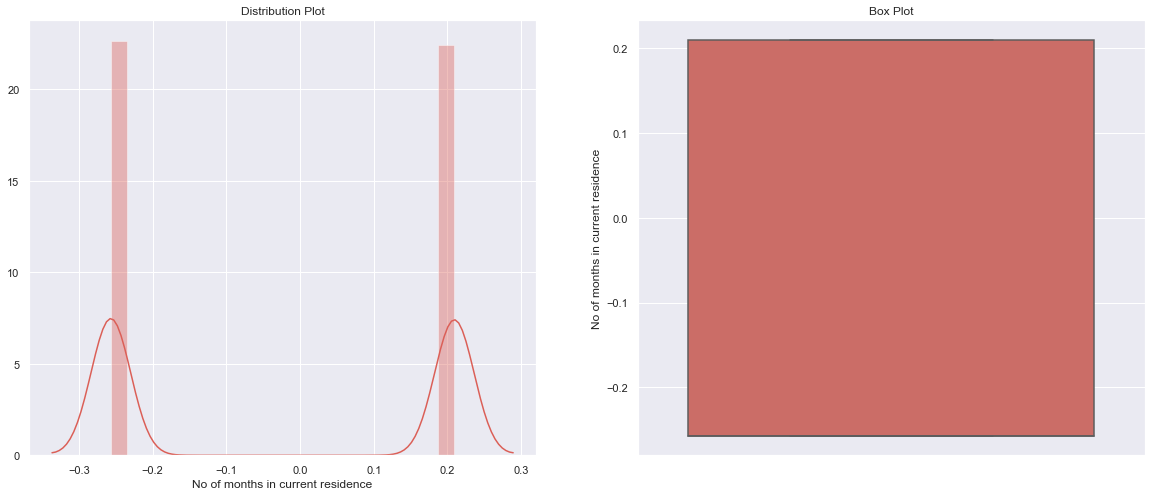

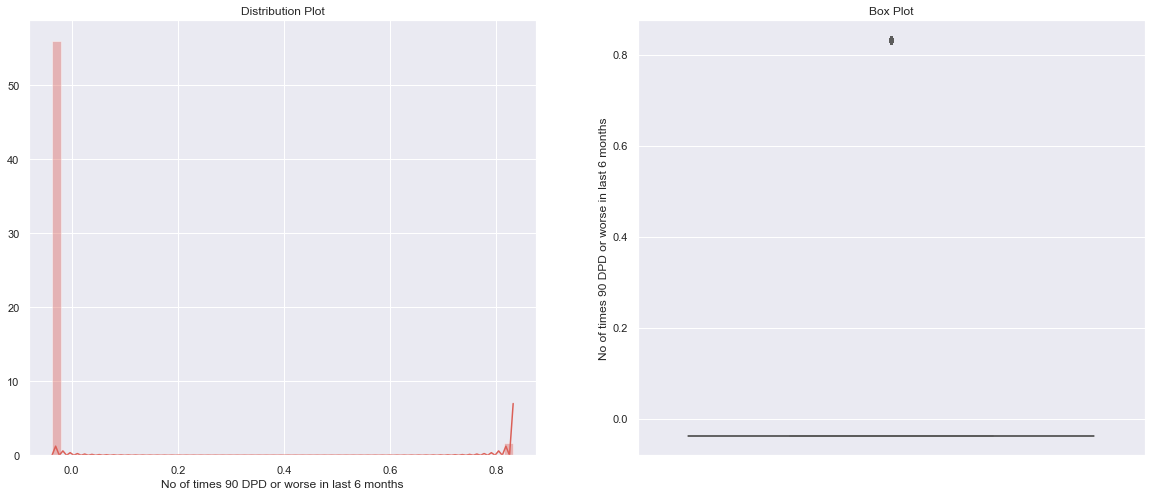

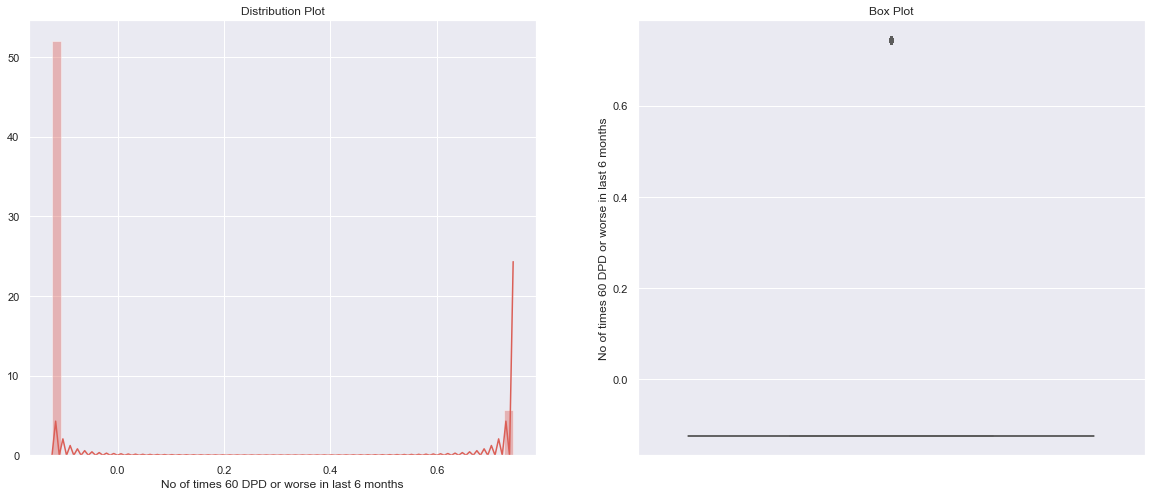

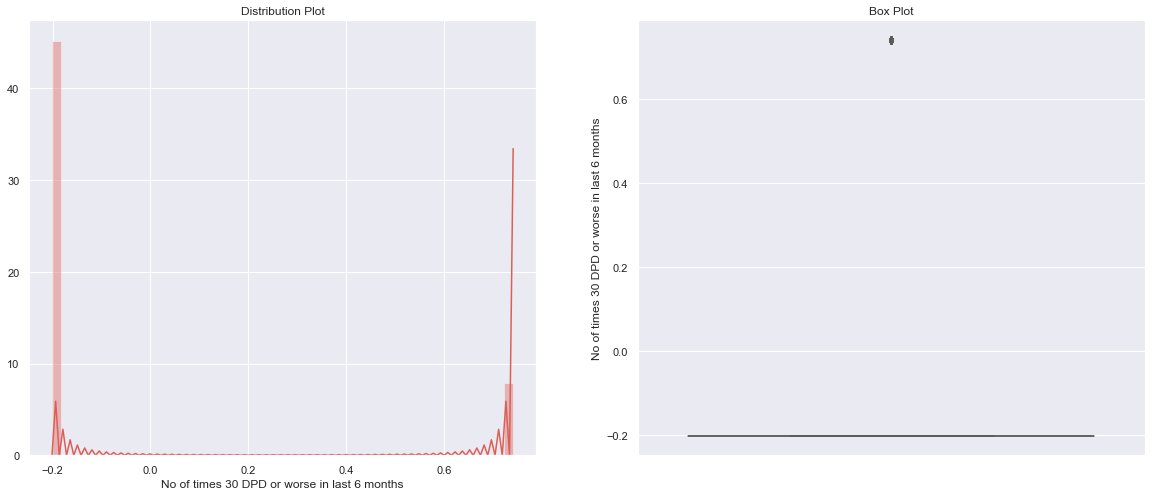

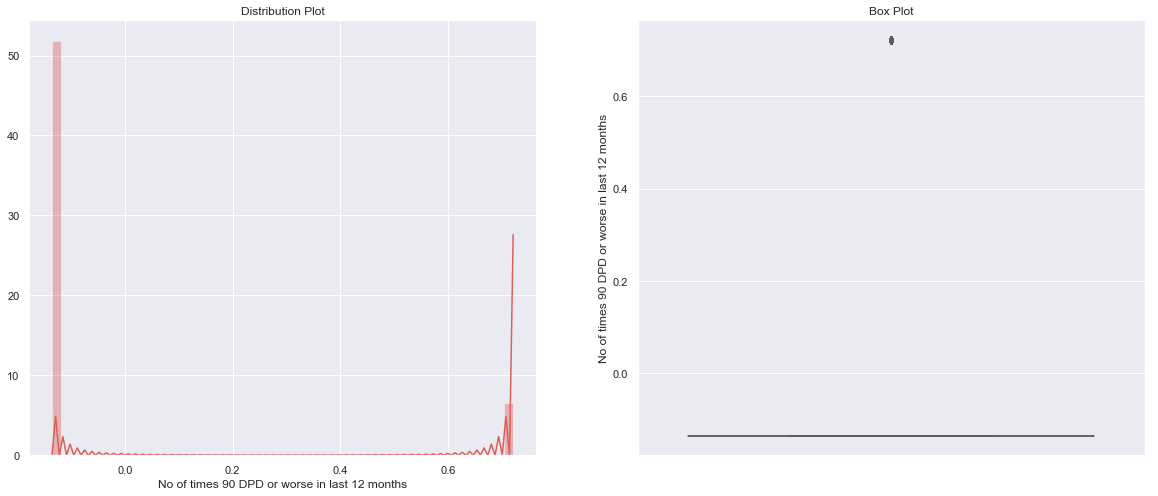

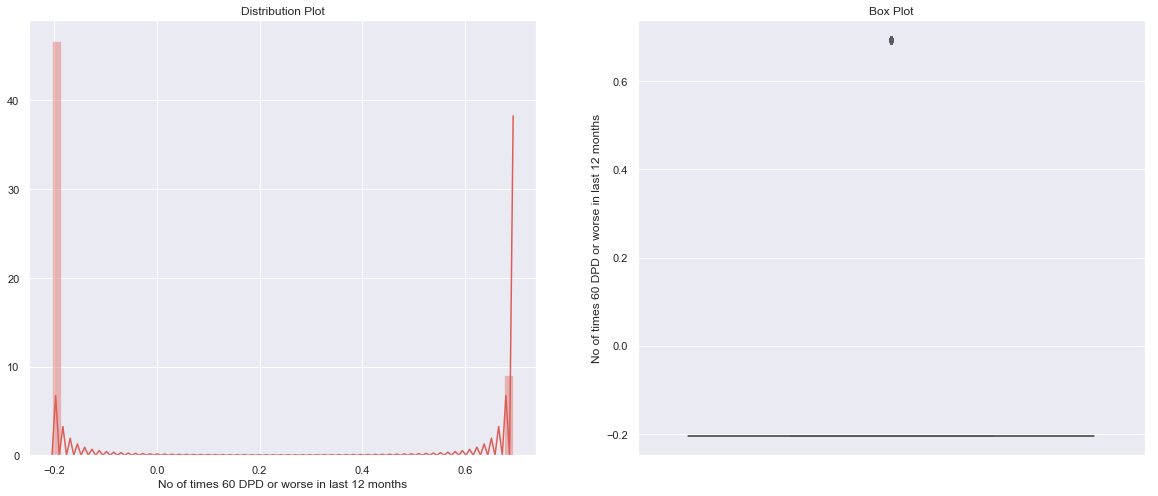

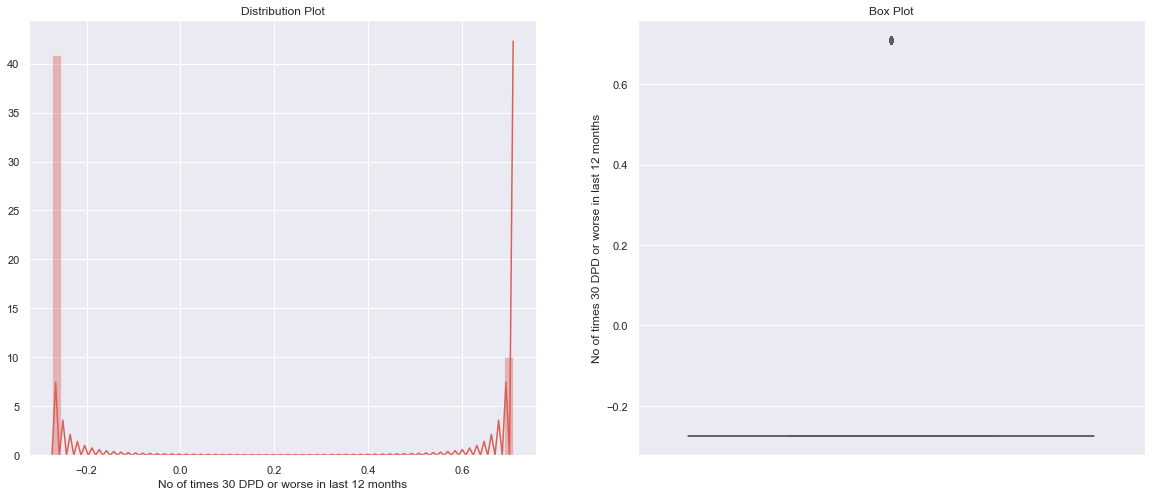

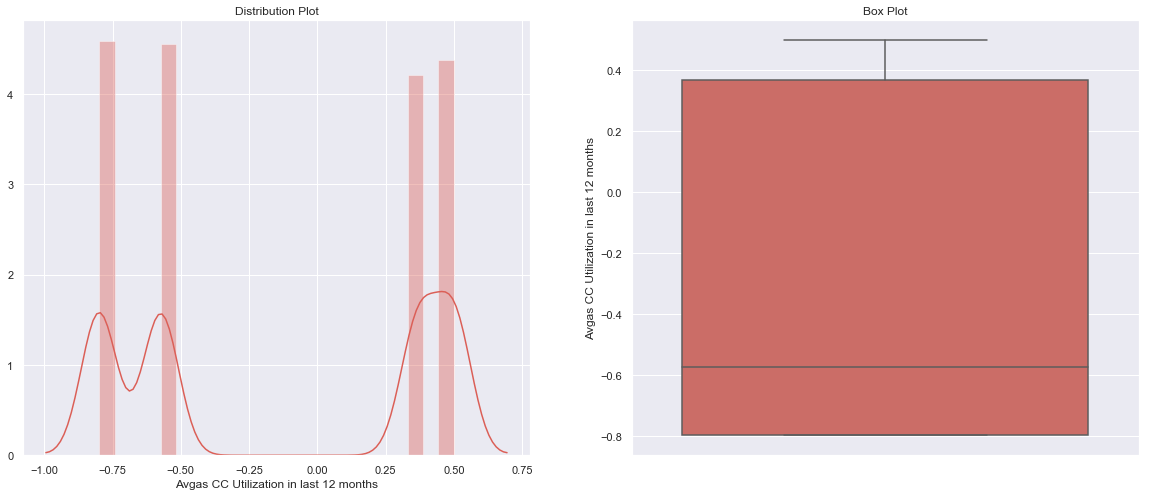

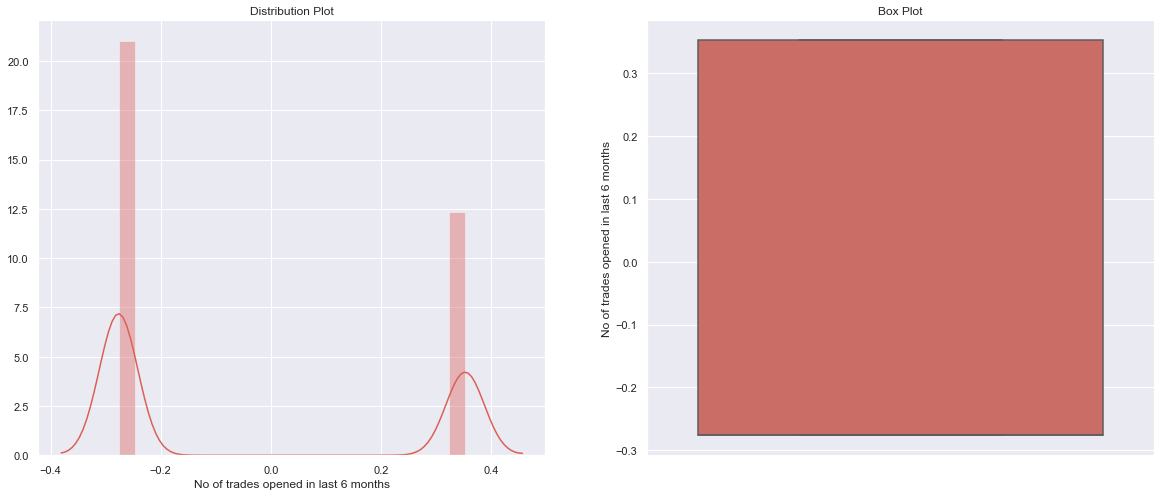

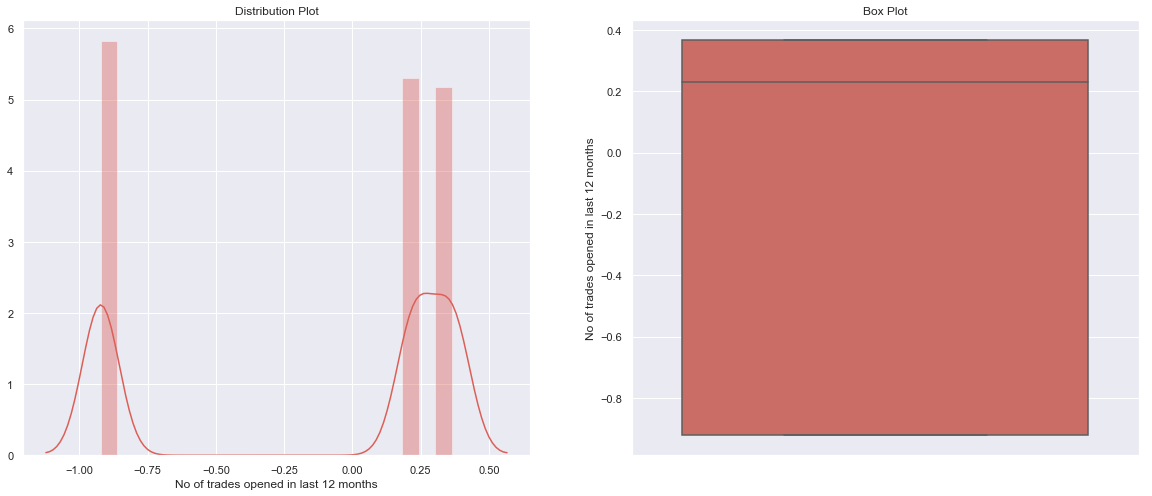

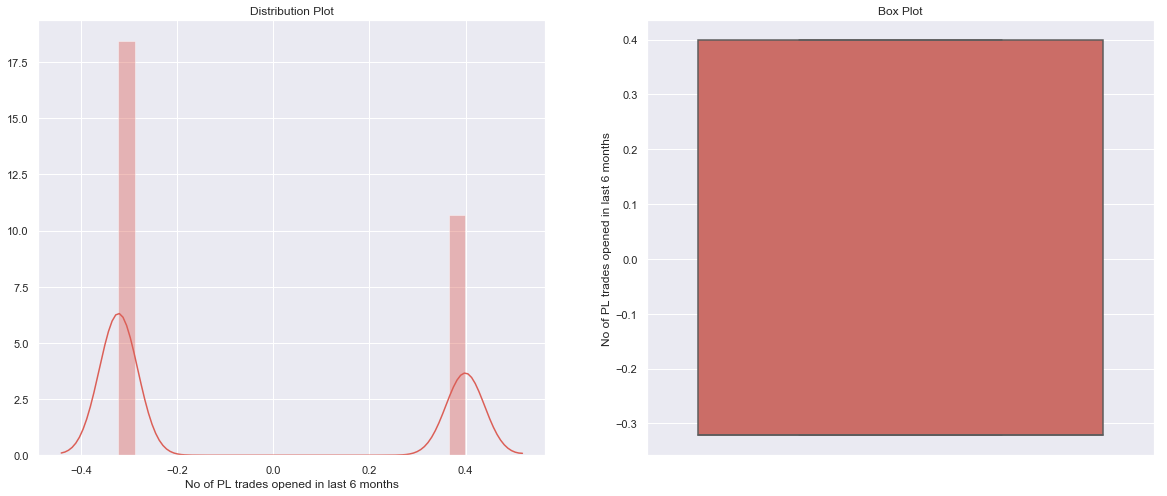

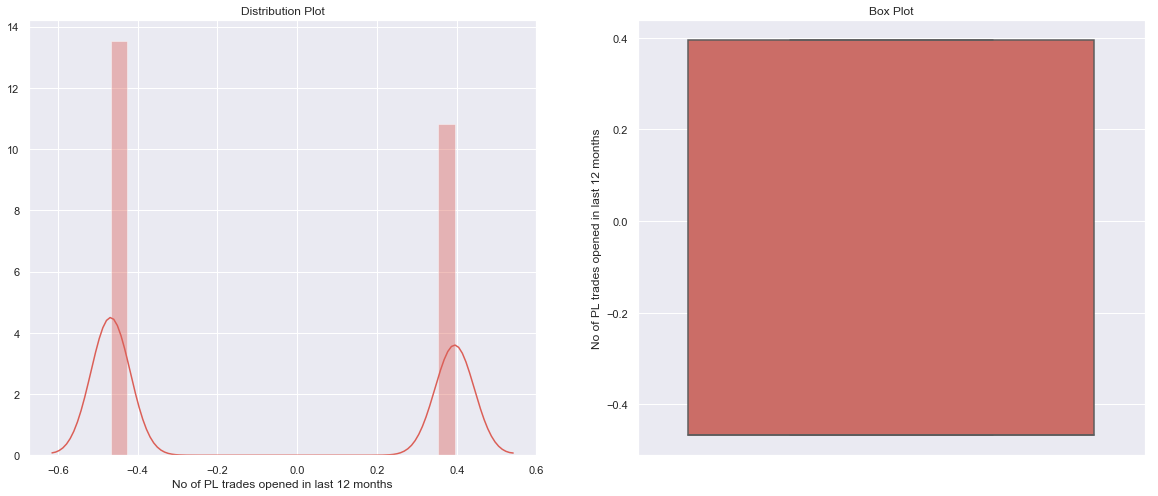

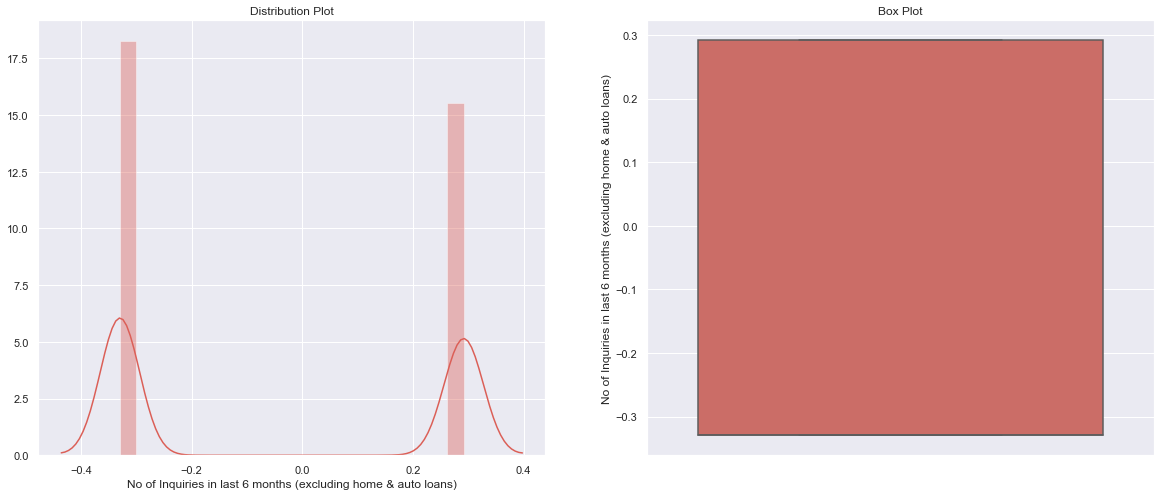

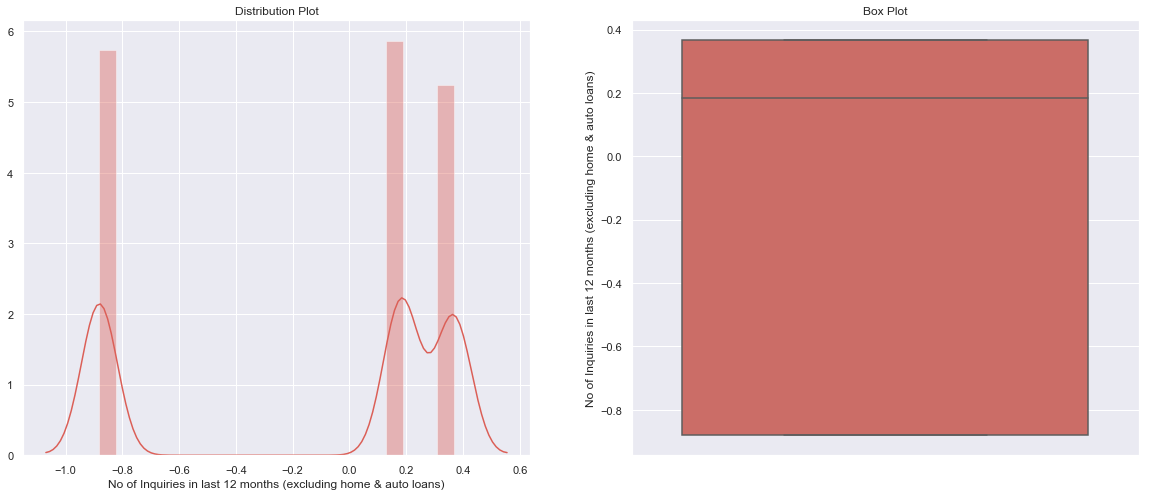

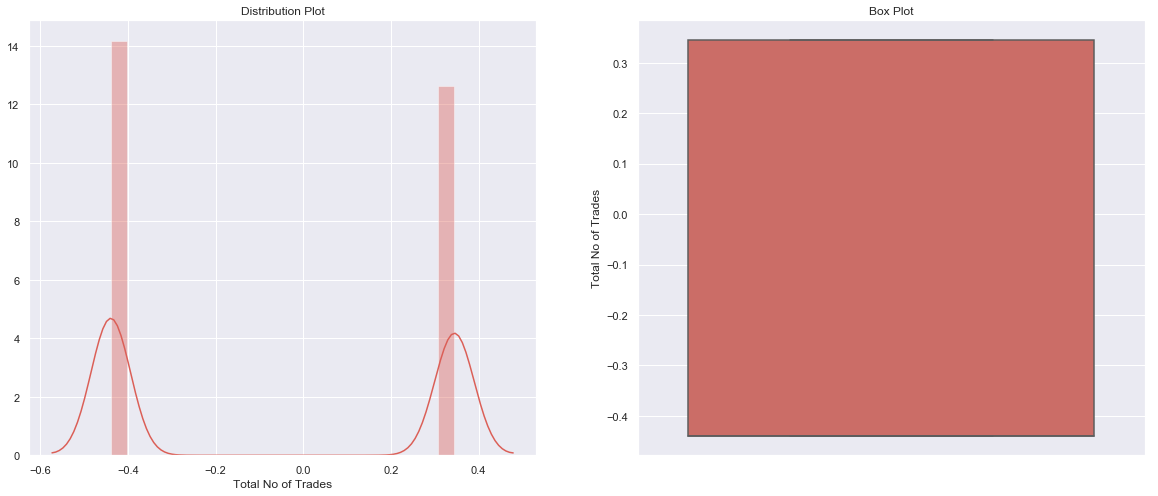

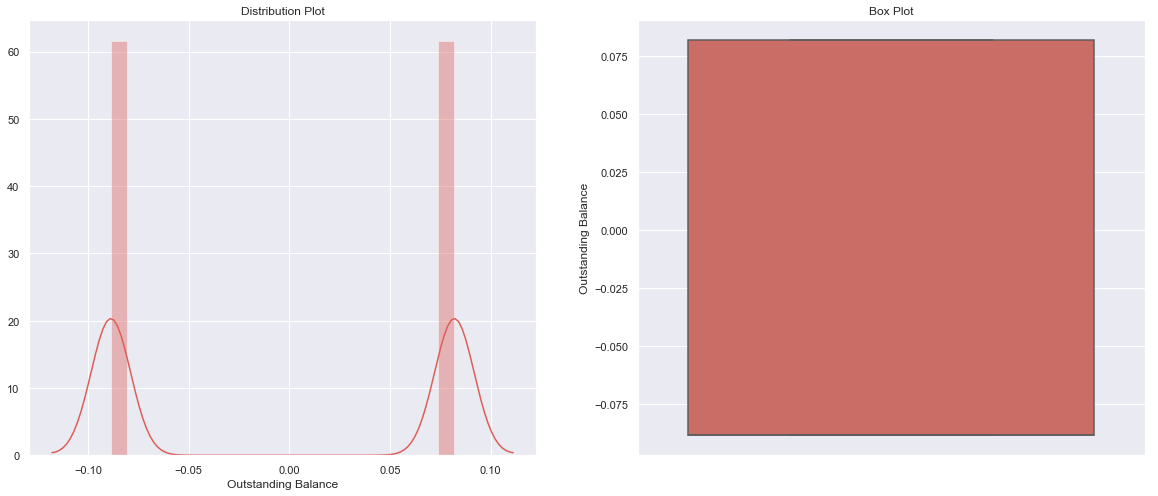

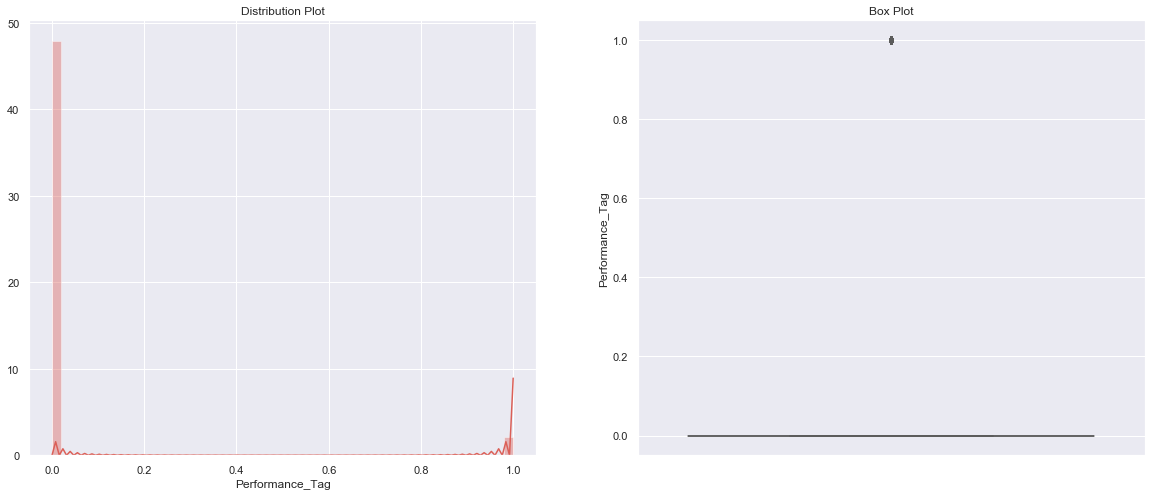

In [375]:
draw_numeric_plot(Cred_demo_df_IV)

In [376]:
# Import library to split the dataset into test and train
from sklearn.model_selection import train_test_split

In [377]:
# Putting feature variable to X
X = Cred_demo_df_IV.drop(['Performance_Tag'], axis=1)

In [378]:
# Putting response variable to y
y = Cred_demo_df_IV['Performance_Tag']

In [379]:
 #Import library to split the dataset into test and train
from sklearn.model_selection import train_test_split

In [380]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

In [381]:
### Checking the conversion Rate
Non_Defaulted = ((len(Cred_demo_df_IV['Performance_Tag'].index)-sum(Cred_demo_df_IV['Performance_Tag']))/len(Cred_demo_df_IV['Performance_Tag'].index))*100
Non_Defaulted
# INFO -  95% Non_Defaulted

95.783158845028169

In [382]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [383]:
from sklearn.feature_selection import RFE

In [384]:
rfe = RFE(logreg, 15)             
rfe = rfe.fit(X_train, y_train)

In [385]:
rfe.support_

array([ True,  True,  True, False,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [386]:
col = X_train.columns[rfe.support_]

In [387]:
import statsmodels.api as sm

In [388]:
# Create the first model
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial(),class_weigths='balanced')
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        Performance_Tag   No. Observations:                48073
Model:                            GLM   Df Residuals:                    48057
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -8044.3
Date:                Sun, 22 Dec 2019   Deviance:                       16089.
Time:                        11:52:25   Pearson chi2:                 4.76e+04
No. Iterations:                     7                                         
===================================================================================================================================
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
const                                                              -3.1207      0.024   -130.390      0.000      -3.168      -3.074
Income                                                              0.1081      0.122      0.889      0.374      -0.130       0.346
No of months in current residence                                  -0.1833      0.115     -1.590      0.112      -0.409       0.043
No of times 90 DPD or worse in last 6 months                        0.0658      0.127      0.516      0.606      -0.184       0.316
No of times 30 DPD or worse in last 6 months                        0.1380      0.102      1.354      0.176      -0.062       0.338
No of times 90 DPD or worse in last 12 months                       0.1352      0.087      1.552      0.121      -0.036       0.306
No of times 30 DPD or worse in last 12 months                       0.3204      0.093      3.441      0.001       0.138       0.503
Avgas CC Utilization in last 12 months                              0.5137      0.063      8.115      0.000       0.390       0.638
No of trades opened in last 6 months                               -0.2786      0.122     -2.292      0.022      -0.517      -0.040
No of trades opened in last 12 months                               0.3316      0.086      3.852      0.000       0.163       0.500
No of PL trades opened in last 6 months                             0.2338      0.110      2.128      0.033       0.018       0.449
No of PL trades opened in last 12 months                            0.1014      0.096      1.054      0.292      -0.087       0.290
No of Inquiries in last 6 months (excluding home & auto loans)     -0.1374      0.095     -1.444      0.149      -0.324       0.049
No of Inquiries in last 12 months (excluding home & auto loans)     0.3248      0.085      3.843      0.000       0.159       0.490
Total No of Trades                                                 -0.0402      0.109     -0.368      0.713      -0.254       0.174
Outstanding Balance                                                -0.4091      0.308     -1.327      0.185      -1.014       0.195
===================================================================================================================================
"""

In [389]:
# Drop Total No Of trades
X_train_sm1 = X_train_sm.drop(['Total No of Trades'], axis = 1)
col = X_train_sm1.columns

In [390]:
# Create Second Model
logm2 = sm.GLM(y_train,X_train_sm1, family = sm.families.Binomial(),class_weigths='balanced')
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        Performance_Tag   No. Observations:                48073
Model:                            GLM   Df Residuals:                    48058
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -8044.4
Date:                Sun, 22 Dec 2019   Deviance:                       16089.
Time:                        11:52:26   Pearson chi2:                 4.76e+04
No. Iterations:                     7                                         
===================================================================================================================================
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
const                                                              -3.1207      0.024   -130.391      0.000      -3.168      -3.074
Income                                                              0.1078      0.122      0.887      0.375      -0.131       0.346
No of months in current residence                                  -0.1815      0.115     -1.576      0.115      -0.407       0.044
No of times 90 DPD or worse in last 6 months                        0.0660      0.127      0.518      0.604      -0.184       0.316
No of times 30 DPD or worse in last 6 months                        0.1379      0.102      1.353      0.176      -0.062       0.338
No of times 90 DPD or worse in last 12 months                       0.1352      0.087      1.552      0.121      -0.036       0.306
No of times 30 DPD or worse in last 12 months                       0.3192      0.093      3.430      0.001       0.137       0.502
Avgas CC Utilization in last 12 months                              0.5151      0.063      8.153      0.000       0.391       0.639
No of trades opened in last 6 months                               -0.2912      0.116     -2.501      0.012      -0.519      -0.063
No of trades opened in last 12 months                               0.3260      0.085      3.846      0.000       0.160       0.492
No of PL trades opened in last 6 months                             0.2294      0.109      2.102      0.036       0.016       0.443
No of PL trades opened in last 12 months                            0.0869      0.088      0.990      0.322      -0.085       0.259
No of Inquiries in last 6 months (excluding home & auto loans)     -0.1384      0.095     -1.455      0.146      -0.325       0.048
No of Inquiries in last 12 months (excluding home & auto loans)     0.3236      0.084      3.832      0.000       0.158       0.489
Outstanding Balance                                                -0.4144      0.308     -1.345      0.179      -1.018       0.189
===================================================================================================================================
"""

INFO - Dropping No of times 90 DPD or worse in last 6 months because of high p values

In [391]:
# Drop column
X_train_sm2 = X_train_sm1.drop(['No of times 90 DPD or worse in last 6 months'], axis = 1)
col = X_train_sm2.columns

In [392]:
#Create Model 3
logm2 = sm.GLM(y_train,X_train_sm2, family = sm.families.Binomial(),class_weigths='balanced')
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        Performance_Tag   No. Observations:                48073
Model:                            GLM   Df Residuals:                    48059
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -8044.5
Date:                Sun, 22 Dec 2019   Deviance:                       16089.
Time:                        11:52:26   Pearson chi2:                 4.76e+04
No. Iterations:                     7                                         
===================================================================================================================================
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
const                                                              -3.1208      0.024   -130.394      0.000      -3.168      -3.074
Income                                                              0.1090      0.122      0.897      0.370      -0.129       0.347
No of months in current residence                                  -0.1835      0.115     -1.595      0.111      -0.409       0.042
No of times 30 DPD or worse in last 6 months                        0.1456      0.101      1.444      0.149      -0.052       0.343
No of times 90 DPD or worse in last 12 months                       0.1503      0.082      1.836      0.066      -0.010       0.311
No of times 30 DPD or worse in last 12 months                       0.3167      0.093      3.408      0.001       0.135       0.499
Avgas CC Utilization in last 12 months                              0.5150      0.063      8.150      0.000       0.391       0.639
No of trades opened in last 6 months                               -0.2922      0.116     -2.511      0.012      -0.520      -0.064
No of trades opened in last 12 months                               0.3262      0.085      3.849      0.000       0.160       0.492
No of PL trades opened in last 6 months                             0.2298      0.109      2.107      0.035       0.016       0.444
No of PL trades opened in last 12 months                            0.0874      0.088      0.995      0.320      -0.085       0.259
No of Inquiries in last 6 months (excluding home & auto loans)     -0.1393      0.095     -1.464      0.143      -0.326       0.047
No of Inquiries in last 12 months (excluding home & auto loans)     0.3230      0.084      3.826      0.000       0.158       0.489
Outstanding Balance                                                -0.4139      0.308     -1.344      0.179      -1.018       0.190
===================================================================================================================================
"""

INFO - Dropping Income because of high p values

In [393]:
# Drop Column
X_train_sm3 = X_train_sm2.drop(['Income'], axis = 1)
col = X_train_sm3.columns

In [394]:
#Create Model 4
logm2 = sm.GLM(y_train,X_train_sm3, family = sm.families.Binomial(),class_weigths='balanced')
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        Performance_Tag   No. Observations:                48073
Model:                            GLM   Df Residuals:                    48060
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -8044.9
Date:                Sun, 22 Dec 2019   Deviance:                       16090.
Time:                        11:52:27   Pearson chi2:                 4.76e+04
No. Iterations:                     7                                         
===================================================================================================================================
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
const                                                              -3.1207      0.024   -130.405      0.000      -3.168      -3.074
No of months in current residence                                  -0.1765      0.115     -1.537      0.124      -0.402       0.049
No of times 30 DPD or worse in last 6 months                        0.1481      0.101      1.470      0.142      -0.049       0.346
No of times 90 DPD or worse in last 12 months                       0.1528      0.082      1.867      0.062      -0.008       0.313
No of times 30 DPD or worse in last 12 months                       0.3188      0.093      3.431      0.001       0.137       0.501
Avgas CC Utilization in last 12 months                              0.5172      0.063      8.190      0.000       0.393       0.641
No of trades opened in last 6 months                               -0.2925      0.116     -2.513      0.012      -0.521      -0.064
No of trades opened in last 12 months                               0.3287      0.085      3.878      0.000       0.163       0.495
No of PL trades opened in last 6 months                             0.2303      0.109      2.111      0.035       0.016       0.444
No of PL trades opened in last 12 months                            0.0889      0.088      1.013      0.311      -0.083       0.261
No of Inquiries in last 6 months (excluding home & auto loans)     -0.1396      0.095     -1.467      0.142      -0.326       0.047
No of Inquiries in last 12 months (excluding home & auto loans)     0.3254      0.084      3.854      0.000       0.160       0.491
Outstanding Balance                                                -0.4187      0.308     -1.360      0.174      -1.022       0.185
===================================================================================================================================
"""

In [396]:
# Drop Column
X_train_sm4 = X_train_sm3.drop(['Outstanding Balance'], axis = 1)
col = X_train_sm4.columns

In [397]:
#Create Model 4
logm2 = sm.GLM(y_train,X_train_sm4, family = sm.families.Binomial(),class_weigths='balanced')
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        Performance_Tag   No. Observations:                48073
Model:                            GLM   Df Residuals:                    48061
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -8045.8
Date:                Sun, 22 Dec 2019   Deviance:                       16092.
Time:                        11:52:44   Pearson chi2:                 4.76e+04
No. Iterations:                     7                                         
===================================================================================================================================
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
const                                                              -3.1206      0.024   -130.433      0.000      -3.167      -3.074
No of months in current residence                                  -0.1699      0.115     -1.482      0.138      -0.395       0.055
No of times 30 DPD or worse in last 6 months                        0.1487      0.101      1.476      0.140      -0.049       0.346
No of times 90 DPD or worse in last 12 months                       0.1542      0.082      1.885      0.059      -0.006       0.315
No of times 30 DPD or worse in last 12 months                       0.3209      0.093      3.454      0.001       0.139       0.503
Avgas CC Utilization in last 12 months                              0.5241      0.063      8.322      0.000       0.401       0.647
No of trades opened in last 6 months                               -0.3041      0.116     -2.616      0.009      -0.532      -0.076
No of trades opened in last 12 months                               0.3303      0.085      3.895      0.000       0.164       0.496
No of PL trades opened in last 6 months                             0.2088      0.108      1.931      0.054      -0.003       0.421
No of PL trades opened in last 12 months                            0.0643      0.086      0.746      0.455      -0.104       0.233
No of Inquiries in last 6 months (excluding home & auto loans)     -0.1433      0.095     -1.507      0.132      -0.330       0.043
No of Inquiries in last 12 months (excluding home & auto loans)     0.3286      0.085      3.888      0.000       0.163       0.494
===================================================================================================================================
"""

In [398]:
INFO - Dropping Column No of PL trades opened in last 12 months because of high p values

SyntaxError: invalid syntax (<ipython-input-398-7f5dc74213c4>, line 1)

In [399]:
# Drop column
X_train_sm5 = X_train_sm4.drop(['No of PL trades opened in last 12 months'], axis = 1)
col = X_train_sm5.columns

In [400]:
#Create Model 5 
logm2 = sm.GLM(y_train,X_train_sm5, family = sm.families.Binomial(),class_weigths='balanced')
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        Performance_Tag   No. Observations:                48073
Model:                            GLM   Df Residuals:                    48062
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -8046.1
Date:                Sun, 22 Dec 2019   Deviance:                       16092.
Time:                        11:52:45   Pearson chi2:                 4.76e+04
No. Iterations:                     7                                         
===================================================================================================================================
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
const                                                              -3.1206      0.024   -130.432      0.000      -3.167      -3.074
No of months in current residence                                  -0.1658      0.115     -1.447      0.148      -0.390       0.059
No of times 30 DPD or worse in last 6 months                        0.1487      0.101      1.476      0.140      -0.049       0.346
No of times 90 DPD or worse in last 12 months                       0.1553      0.082      1.898      0.058      -0.005       0.316
No of times 30 DPD or worse in last 12 months                       0.3237      0.093      3.486      0.000       0.142       0.506
Avgas CC Utilization in last 12 months                              0.5278      0.063      8.409      0.000       0.405       0.651
No of trades opened in last 6 months                               -0.2942      0.116     -2.545      0.011      -0.521      -0.068
No of trades opened in last 12 months                               0.3453      0.082      4.202      0.000       0.184       0.506
No of PL trades opened in last 6 months                             0.2390      0.101      2.374      0.018       0.042       0.436
No of Inquiries in last 6 months (excluding home & auto loans)     -0.1375      0.095     -1.451      0.147      -0.323       0.048
No of Inquiries in last 12 months (excluding home & auto loans)     0.3289      0.084      3.894      0.000       0.163       0.494
===================================================================================================================================
"""

In [401]:
INFO - Dropping Column No of months in current residence because of high p values

SyntaxError: invalid syntax (<ipython-input-401-5f4c154a396d>, line 1)

In [402]:
# Drop Column
X_train_sm6 = X_train_sm5.drop(['No of months in current residence'], axis = 1)
col = X_train_sm6.columns

In [403]:
#Create Model 6
logm2 = sm.GLM(y_train,X_train_sm6, family = sm.families.Binomial(),class_weigths='balanced')
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        Performance_Tag   No. Observations:                48073
Model:                            GLM   Df Residuals:                    48063
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -8047.2
Date:                Sun, 22 Dec 2019   Deviance:                       16094.
Time:                        11:52:46   Pearson chi2:                 4.76e+04
No. Iterations:                     7                                         
===================================================================================================================================
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
const                                                              -3.1201      0.024   -130.462      0.000      -3.167      -3.073
No of times 30 DPD or worse in last 6 months                        0.1513      0.101      1.502      0.133      -0.046       0.349
No of times 90 DPD or worse in last 12 months                       0.1534      0.082      1.877      0.060      -0.007       0.313
No of times 30 DPD or worse in last 12 months                       0.3098      0.092      3.356      0.001       0.129       0.491
Avgas CC Utilization in last 12 months                              0.4953      0.058      8.467      0.000       0.381       0.610
No of trades opened in last 6 months                               -0.2806      0.115     -2.436      0.015      -0.506      -0.055
No of trades opened in last 12 months                               0.3431      0.082      4.165      0.000       0.182       0.505
No of PL trades opened in last 6 months                             0.2303      0.100      2.294      0.022       0.034       0.427
No of Inquiries in last 6 months (excluding home & auto loans)     -0.1341      0.095     -1.416      0.157      -0.320       0.052
No of Inquiries in last 12 months (excluding home & auto loans)     0.3395      0.084      4.025      0.000       0.174       0.505
===================================================================================================================================
"""

In [406]:
# Drop Column
X_train_sm7 = X_train_sm6.drop(['No of Inquiries in last 6 months (excluding home & auto loans)'], axis = 1)
col = X_train_sm7.columns

In [407]:
#Create Model 7
logm2 = sm.GLM(y_train,X_train_sm7, family = sm.families.Binomial(),class_weigths='balanced')
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        Performance_Tag   No. Observations:                48073
Model:                            GLM   Df Residuals:                    48064
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -8048.1
Date:                Sun, 22 Dec 2019   Deviance:                       16096.
Time:                        11:52:59   Pearson chi2:                 4.77e+04
No. Iterations:                     7                                         
===================================================================================================================================
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
const                                                              -3.1205      0.024   -130.490      0.000      -3.167      -3.074
No of times 30 DPD or worse in last 6 months                        0.1523      0.101      1.513      0.130      -0.045       0.350
No of times 90 DPD or worse in last 12 months                       0.1530      0.082      1.874      0.061      -0.007       0.313
No of times 30 DPD or worse in last 12 months                       0.3041      0.092      3.298      0.001       0.123       0.485
Avgas CC Utilization in last 12 months                              0.5000      0.058      8.553      0.000       0.385       0.615
No of trades opened in last 6 months                               -0.2934      0.115     -2.556      0.011      -0.518      -0.068
No of trades opened in last 12 months                               0.3443      0.082      4.175      0.000       0.183       0.506
No of PL trades opened in last 6 months                             0.2267      0.100      2.260      0.024       0.030       0.423
No of Inquiries in last 12 months (excluding home & auto loans)     0.2855      0.075      3.791      0.000       0.138       0.433
===================================================================================================================================
"""

INFO - Dropping Column No of times 30 DPD or worse in last 6 months because of high p values

In [408]:
#Drop COlumn
X_train_sm8 = X_train_sm7.drop(['No of times 30 DPD or worse in last 6 months'], axis = 1)
col = X_train_sm8.columns

In [409]:
#Create Model 8
logm2 = sm.GLM(y_train,X_train_sm8, family = sm.families.Binomial(),class_weigths='balanced')
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        Performance_Tag   No. Observations:                48073
Model:                            GLM   Df Residuals:                    48065
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -8049.3
Date:                Sun, 22 Dec 2019   Deviance:                       16099.
Time:                        11:53:01   Pearson chi2:                 4.77e+04
No. Iterations:                     7                                         
===================================================================================================================================
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
const                                                              -3.1203      0.024   -130.501      0.000      -3.167      -3.073
No of times 90 DPD or worse in last 12 months                       0.1849      0.079      2.343      0.019       0.030       0.339
No of times 30 DPD or worse in last 12 months                       0.4045      0.063      6.469      0.000       0.282       0.527
Avgas CC Utilization in last 12 months                              0.4990      0.058      8.536      0.000       0.384       0.614
No of trades opened in last 6 months                               -0.2907      0.115     -2.533      0.011      -0.516      -0.066
No of trades opened in last 12 months                               0.3430      0.082      4.159      0.000       0.181       0.505
No of PL trades opened in last 6 months                             0.2267      0.100      2.259      0.024       0.030       0.423
No of Inquiries in last 12 months (excluding home & auto loans)     0.2862      0.075      3.800      0.000       0.139       0.434
===================================================================================================================================
"""

In [410]:
# Check the VIF values less than 5
getVIF(X_train_sm8)

Features   VIF
5              No of trades opened in last 12 months  3.42
4               No of trades opened in last 6 months  3.17
6            No of PL trades opened in last 6 months  3.09
7  No of Inquiries in last 12 months (excluding h...  2.57
3             Avgas CC Utilization in last 12 months  1.90
2      No of times 30 DPD or worse in last 12 months  1.77
1      No of times 90 DPD or worse in last 12 months  1.56
0                                              const  1.08

INFO - All of the Features are under 5 ,hence no need to drop those.

In [411]:
# Fetch the predicate value
y_train_pred = res.predict(X_train_sm8)

In [412]:
y_train_pred[:5]

14822    0.014545
27336    0.032176
65901    0.091348
11990    0.016252
43551    0.053730
dtype: float64

In [413]:
#To start index from 1
y_train_pred = y_train_pred.values.reshape(-1)

In [414]:
y_train_pred_final = pd.DataFrame({'Defaulted':y_train.values, 'Defaulted_Prob':y_train_pred})
y_train_pred_final['ApplicationID'] = y_train.index
y_train_pred_final.head()

Defaulted  Defaulted_Prob  ApplicationID
0        0.0        0.014545          14822
1        0.0        0.032176          27336
2        0.0        0.091348          65901
3        0.0        0.016252          11990
4        0.0        0.053730          43551

In [415]:
y_train_pred_final = y_train_pred_final.reindex_axis(['ApplicationID'] + list(y_train_pred_final.columns[:-1]), axis=1)
y_train_pred_final.head()

ApplicationID  Defaulted  Defaulted_Prob
0          14822        0.0        0.014545
1          27336        0.0        0.032176
2          65901        0.0        0.091348
3          11990        0.0        0.016252
4          43551        0.0        0.053730

In [416]:
y_train_pred_final['predicted'] = y_train_pred_final.Defaulted_Prob.map(lambda x: 1 if x > 0.50 else 0)

In [417]:
# Analyse this dataframe
y_train_pred_final.head()

ApplicationID  Defaulted  Defaulted_Prob  predicted
0          14822        0.0        0.014545          0
1          27336        0.0        0.032176          0
2          65901        0.0        0.091348          0
3          11990        0.0        0.016252          0
4          43551        0.0        0.053730          0

In [418]:
confusion_final1 = metrics.confusion_matrix(y_train_pred_final.Defaulted, y_train_pred_final.predicted )
confusion_final1

array([[46037,     0],
       [ 2036,     0]])

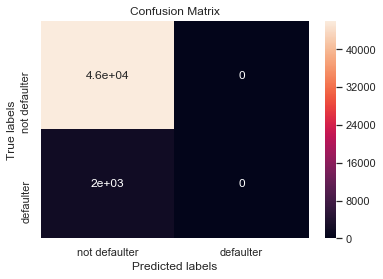

In [419]:
plot_confusion_matrix(confusion_final1)

In [420]:
# The overall accuracy 
print("The overall Accuracy is ",metrics.accuracy_score(y_train_pred_final.Defaulted, y_train_pred_final.predicted))

The overall Accuracy is  0.957647744056


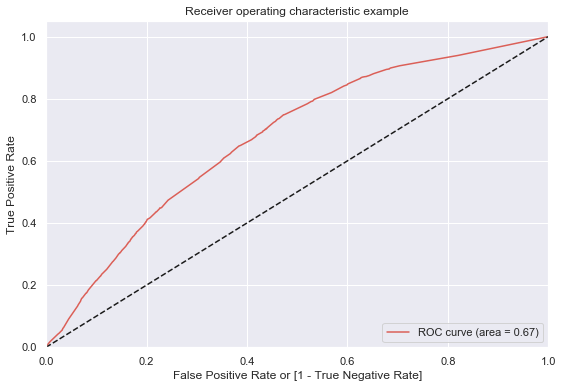

In [421]:
# Draw ROC and area under curver
draw_roc(y_train_pred_final.Defaulted, y_train_pred_final.Defaulted_Prob)

INFO - AUC = 0.67

In [422]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Defaulted, y_train_pred_final.Defaulted_Prob, drop_intermediate = False )

In [423]:
# Now we need to create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Defaulted_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

ApplicationID  Defaulted  Defaulted_Prob  predicted  0.0  0.1  0.2  0.3  \
0          14822        0.0        0.014545          0    1    0    0    0   
1          27336        0.0        0.032176          0    1    0    0    0   
2          65901        0.0        0.091348          0    1    0    0    0   
3          11990        0.0        0.016252          0    1    0    0    0   
4          43551        0.0        0.053730          0    1    0    0    0   

   0.4  0.5  0.6  0.7  0.8  0.9  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0

In [424]:
# let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Defaulted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]

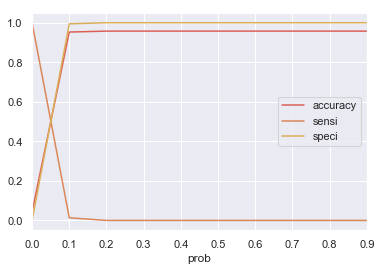

In [425]:
# Plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [426]:
y_train_pred_final['predicted_default'] = y_train_pred_final.Defaulted_Prob.map( lambda x: 1 if x > 0.1 else 0)
y_train_pred_final.head()

ApplicationID  Defaulted  Defaulted_Prob  predicted  0.0  0.1  0.2  0.3  \
0          14822        0.0        0.014545          0    1    0    0    0   
1          27336        0.0        0.032176          0    1    0    0    0   
2          65901        0.0        0.091348          0    1    0    0    0   
3          11990        0.0        0.016252          0    1    0    0    0   
4          43551        0.0        0.053730          0    1    0    0    0   

   0.4  0.5  0.6  0.7  0.8  0.9  predicted_default  
0    0    0    0    0    0    0                  0  
1    0    0    0    0    0    0                  0  
2    0    0    0    0    0    0                  0  
3    0    0    0    0    0    0                  0  
4    0    0    0    0    0    0                  0

In [427]:
confusion_final2 = metrics.confusion_matrix(y_train_pred_final.Defaulted, y_train_pred_final.predicted_default)
confusion_final2

array([[45784,   253],
       [ 2009,    27]])

In [428]:
# check the overall accuracy.
print("Overall accuracy is ",metrics.accuracy_score(y_train_pred_final.Defaulted, y_train_pred_final.predicted_default))

Overall accuracy is  0.952946560439


In [429]:
TP = confusion_final2[1,1] # true positive 
TN = confusion_final2[0,0] # true negatives
FP = confusion_final2[0,1] # false positives
FN = confusion_final2[1,0] # false negatives

In [430]:
# Let's see the sensitivity of our logistic regression model
print("Sensitivity of the Model is ",TP / float(TP+FN))

Sensitivity of the Model is  0.0132612966601


In [431]:
# Let's see the specificity of our logistic regression model
print("specificity of the Model is ",TN / float(TN+FP))

specificity of the Model is  0.994504420358


In [432]:
X_test_sm = sm.add_constant(X_test)

In [433]:
X_test_sm = X_test_sm[col]

In [434]:
y_test_pred = res.predict(X_test_sm)

In [435]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)


In [436]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

In [437]:
# Putting ApplicationID to index
y_test_df['ApplicationID'] = y_test_df.index

In [438]:
 #Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Defaulted_Prob'})
y_pred_final.head()

Performance_Tag  ApplicationID  Defaulted_Prob
0              0.0          37598        0.026600
1              0.0          42135        0.042907
2              0.0          27748        0.032176
3              0.0          55609        0.043459
4              0.0          62535        0.044389

In [439]:
y_pred_final['predicted_default'] = y_pred_final.Defaulted_Prob.map(lambda x: 1 if x > 0.1 else 0)
y_pred_final.head()

Performance_Tag  ApplicationID  Defaulted_Prob  predicted_default
0              0.0          37598        0.026600                  0
1              0.0          42135        0.042907                  0
2              0.0          27748        0.032176                  0
3              0.0          55609        0.043459                  0
4              0.0          62535        0.044389                  0

In [440]:
y_pred_final['Defaulted'] = y_pred_final['Performance_Tag'] 

In [441]:
# Let's check the overall accuracy.
print("The overall Accuracy is ",metrics.accuracy_score(y_pred_final.Defaulted, y_pred_final.predicted_default))

The overall Accuracy is  0.953261502621


In [442]:
confusion_final3 = metrics.confusion_matrix(y_pred_final.Defaulted, y_pred_final.predicted_default )
confusion_final3

array([[19637,   107],
       [  856,     4]])

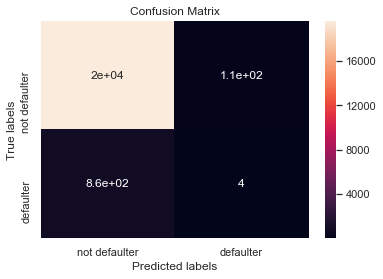

In [443]:
plot_confusion_matrix(confusion_final3)

In [444]:
TP = confusion_final3[1,1] # true positive 
TN = confusion_final3[0,0] # true negatives
FP = confusion_final3[0,1] # false positives
FN = confusion_final3[1,0] # false negatives

In [445]:
# Let's see the sensitivity of our logistic regression model
print("Sensitivity of the Model is ",TP / float(TP+FN))

Sensitivity of the Model is  0.0046511627907


In [446]:
# Let's see the specificity of our logistic regression model
print("specificity of the Model is ",TN / float(TN+FP))

specificity of the Model is  0.994580632091


### Logistic regression using PCA

In [447]:
pca = PCA()
pca.fit(X_train)
pca_churn = pca.fit_transform(X_train)

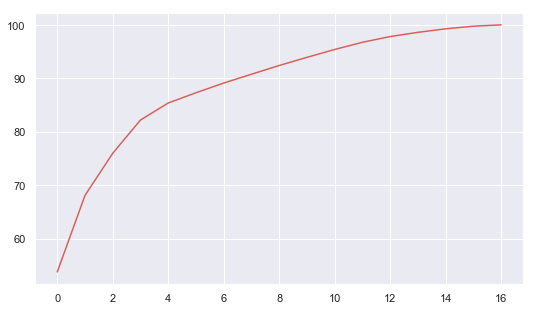

In [448]:
# plot graph for feature variance
features = range(pca.n_components_)
cumulative_variance = np.round(np.cumsum(pca.explained_variance_ratio_)*100, decimals=4)
plt.figure(figsize=(175/20,100/20)) # 100 elements on y-axis; 175 elements on x-axis; 20 is normalising factor
plt.plot(cumulative_variance)

In [449]:
# create pipeline for PCA VARS 3
PCA_VARS = 3
steps = [("pca", PCA(n_components=PCA_VARS)),
         ("logistic", LogisticRegression(class_weight='balanced'))
        ]
pipeline = Pipeline(steps)

In [450]:
# fit model
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logistic', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [451]:
# find the score 
pipeline.score(X_train, y_train)

0.56156262351007846

In [452]:
# we need to predict churn on test data
y_pred = pipeline.predict(X_test)

In [453]:
# create Confusion matrix
confusion_final3 = metrics.confusion_matrix(y_test, y_pred)
confusion_final3

array([[10956,  8788],
       [  253,   607]])

In [454]:
# check area under curve
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]

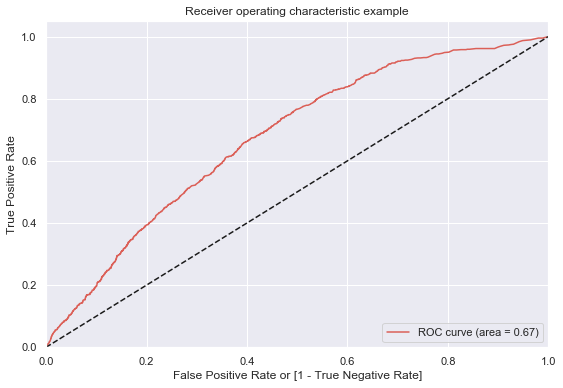

In [455]:
# Draw ROC and area under curver
draw_roc(y_test, y_pred_prob)

INFO - AUC =0.67

In [456]:
# PCA
pca = PCA()

# logistic regression - the class weight is used to handle class imbalance - it adjusts the cost function
logistic = LogisticRegression(class_weight='balanced')

# create pipeline
steps = [("pca", pca),
         ("logistic", logistic)
        ]

# compile pipeline
pca_logistic = Pipeline(steps)

# hyperparameter space
params = {'pca__n_components': [3], 'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10], 'logistic__penalty': ['l1', 'l2']}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model = GridSearchCV(estimator=pca_logistic, cv=folds, param_grid=params, scoring='roc_auc')

In [457]:
# fit model
model.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logistic', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'pca__n_components': [3], 'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10], 'logistic__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [458]:
# print best hyperparameters
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best AUC:  0.672269155591
Best hyperparameters:  {'logistic__C': 4, 'logistic__penalty': 'l1', 'pca__n_components': 3}


In [459]:
# predict churn on train data
y_train_pred = model.predict(X_train)

In [460]:
# create Confusion matrix
confusion_final4 = metrics.confusion_matrix(y_train, y_train_pred)
confusion_final4

array([[25551, 20486],
       [  592,  1444]])

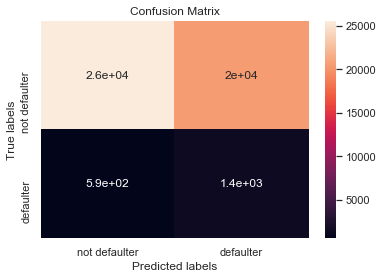

In [461]:
plot_confusion_matrix(confusion_final4)

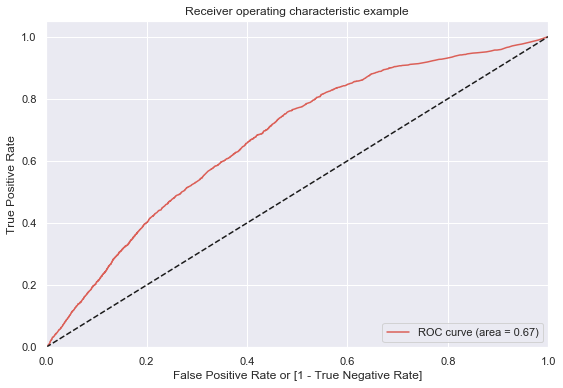

In [462]:
# Draw ROC and area under curver
y_train_pred_prob = model.predict_proba(X_train)[:, 1]
draw_roc(y_train, y_train_pred_prob)

INFO - AUC=0.67

In [463]:
TP = confusion_final4[1,1] # true positive 
TN = confusion_final4[0,0] # true negatives
FP = confusion_final4[0,1] # false positives
FN = confusion_final4[1,0] # false negatives

In [464]:
# Let's see the sensitivity of our logistic regression model
print("Sensitivity of the Model is ",TP / float(TP+FN))

Sensitivity of the Model is  0.709233791749


In [465]:
# Let's see the specificity of our logistic regression model
print("specificity of the Model is ",TN / float(TN+FP))

specificity of the Model is  0.555010100571


In [466]:
# Converting y_pred to a dataframe which is an array
y_train_pred = pd.DataFrame(y_train_pred_prob)

In [467]:
# Converting y_test to dataframe
y_train_df = pd.DataFrame(y_train)

In [468]:
# Putting ApplicationID to index
y_train_df['ApplicationID'] = y_train_df.index

In [469]:
#Removing index for both dataframes to append them side by side 
y_train_pred.reset_index(drop=True, inplace=True)
y_train_df.reset_index(drop=True, inplace=True)
# Appending y_test_df and y_pred_1
y_train_pred_final = pd.concat([y_train_df, y_train_pred],axis=1)
# Renaming the column 
y_train_pred_final= y_train_pred_final.rename(columns={ 0 : 'Defaulted_Prob'})
y_train_pred_final.head()

Performance_Tag  ApplicationID  Defaulted_Prob
0              0.0          14822        0.249241
1              0.0          27336        0.396985
2              0.0          65901        0.684785
3              0.0          11990        0.271185
4              0.0          43551        0.579811

In [470]:
y_train_pred_final['predicted_default'] = y_train_pred_final.Defaulted_Prob.map(lambda x: 1 if x > 0.7 else 0)
y_train_pred_final.head()

Performance_Tag  ApplicationID  Defaulted_Prob  predicted_default
0              0.0          14822        0.249241                  0
1              0.0          27336        0.396985                  0
2              0.0          65901        0.684785                  0
3              0.0          11990        0.271185                  0
4              0.0          43551        0.579811                  0

In [471]:
y_train_pred_final['Defaulted'] = y_train_pred_final['Performance_Tag'] 

In [472]:
y_train_pred_final.head()

Performance_Tag  ApplicationID  Defaulted_Prob  predicted_default  \
0              0.0          14822        0.249241                  0   
1              0.0          27336        0.396985                  0   
2              0.0          65901        0.684785                  0   
3              0.0          11990        0.271185                  0   
4              0.0          43551        0.579811                  0   

   Defaulted  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0

In [473]:
# Let's check the overall accuracy.
print("Overall Accuracy",metrics.accuracy_score(y_train_pred_final.Defaulted, y_train_pred_final.predicted_default))

Overall Accuracy 0.915357893204


In [474]:
# predict churn on test data
y_test_pred = model.predict(X_test)

In [475]:
# create Confusion matrix
confusion_final5 = metrics.confusion_matrix(y_test, y_test_pred)
confusion_final5

array([[10956,  8788],
       [  253,   607]])

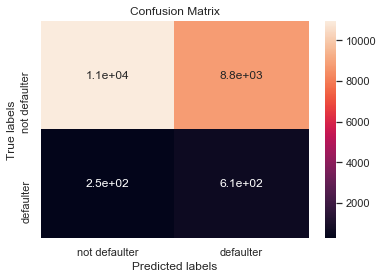

In [476]:
plot_confusion_matrix(confusion_final5)

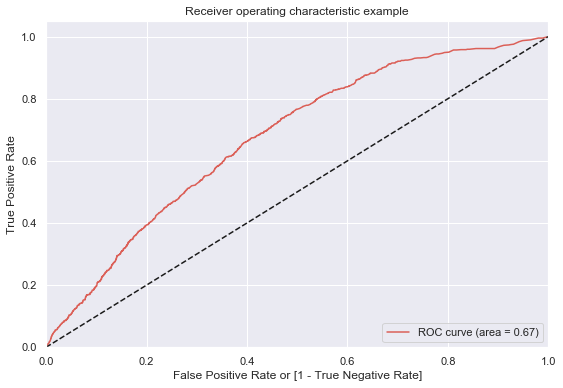

In [477]:
# check area under curve
y_test_pred_prob = model.predict_proba(X_test)[:, 1]
draw_roc(y_test, y_pred_prob)


INFO - AUC =0.67

In [478]:
# Converting y_test to dataframe
# Converting y_pred to a dataframe which is an array
y_test_pred = pd.DataFrame(y_test_pred_prob)
y_test_df = pd.DataFrame(y_test)

In [479]:
# Putting ApplicationID to index
y_test_df['ApplicationID'] = y_test_df.index

#Removing index for both dataframes to append them side by side 
y_test_pred.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)
# Appending y_test_df and y_pred_1
y_test_pred_final = pd.concat([y_test_df, y_test_pred],axis=1)
# Renaming the column 
y_test_pred_final= y_test_pred_final.rename(columns={ 0 : 'Defaulted_Prob'})
y_test_pred_final.head()

y_test_pred_final['predicted_default'] = y_test_pred_final.Defaulted_Prob.map(lambda x: 1 if x > 0.7 else 0)
y_test_pred_final.head()

y_test_pred_final['Defaulted'] = y_test_pred_final['Performance_Tag'] 

# Let's check the overall accuracy.
metrics.accuracy_score(y_test_pred_final.Defaulted, y_test_pred_final.predicted_default)

0.917394680644535

In [480]:
y_test_pred_final.head()

Performance_Tag  ApplicationID  Defaulted_Prob  predicted_default  \
0              0.0          37598        0.407621                  0   
1              0.0          42135        0.479347                  0   
2              0.0          27748        0.394187                  0   
3              0.0          55609        0.518366                  0   
4              0.0          62535        0.595102                  0   

   Defaulted  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0

In [481]:
y_test_pred_final['Non_Defaulted_Prob']=1-y_test_pred_final['Defaulted_Prob']
y_test_pred_final.head()

Performance_Tag  ApplicationID  Defaulted_Prob  predicted_default  \
0              0.0          37598        0.407621                  0   
1              0.0          42135        0.479347                  0   
2              0.0          27748        0.394187                  0   
3              0.0          55609        0.518366                  0   
4              0.0          62535        0.595102                  0   

   Defaulted  Non_Defaulted_Prob  
0        0.0            0.592379  
1        0.0            0.520653  
2        0.0            0.605813  
3        0.0            0.481634  
4        0.0            0.404898

In [482]:
#Calculating odd goods as P(non-defaulted)/P(defaulted)
y_test_pred_final['odds']=y_test_pred_final['Non_Defaulted_Prob']/y_test_pred_final['Defaulted_Prob']
y_test_pred_final.head()

Performance_Tag  ApplicationID  Defaulted_Prob  predicted_default  \
0              0.0          37598        0.407621                  0   
1              0.0          42135        0.479347                  0   
2              0.0          27748        0.394187                  0   
3              0.0          55609        0.518366                  0   
4              0.0          62535        0.595102                  0   

   Defaulted  Non_Defaulted_Prob      odds  
0        0.0            0.592379  1.453260  
1        0.0            0.520653  1.086170  
2        0.0            0.605813  1.536864  
3        0.0            0.481634  0.929139  
4        0.0            0.404898  0.680385

In [483]:
#As per problem statement
#Target Score ts=400
#Inverted target score to=10
#points to double odds pdo=20
y_test_pred_final['logit']=np.log(y_test_pred_final['odds'])
y_test_pred_final.head()

Performance_Tag  ApplicationID  Defaulted_Prob  predicted_default  \
0              0.0          37598        0.407621                  0   
1              0.0          42135        0.479347                  0   
2              0.0          27748        0.394187                  0   
3              0.0          55609        0.518366                  0   
4              0.0          62535        0.595102                  0   

   Defaulted  Non_Defaulted_Prob      odds     logit  
0        0.0            0.592379  1.453260  0.373809  
1        0.0            0.520653  1.086170  0.082658  
2        0.0            0.605813  1.536864  0.429744  
3        0.0            0.481634  0.929139 -0.073497  
4        0.0            0.404898  0.680385 -0.385097

In [484]:
pdo=20
to=10
factor=pdo/np.log(2)
points0=400
odds0=1/to
offset=points0-factor * np.log(odds0)

In [485]:
y_test_pred_final['score']=offset-(factor*y_test_pred_final['logit'])

In [486]:
y_test_pred_final.head()

Performance_Tag  ApplicationID  Defaulted_Prob  predicted_default  \
0              0.0          37598        0.407621                  0   
1              0.0          42135        0.479347                  0   
2              0.0          27748        0.394187                  0   
3              0.0          55609        0.518366                  0   
4              0.0          62535        0.595102                  0   

   Defaulted  Non_Defaulted_Prob      odds     logit       score  
0        0.0            0.592379  1.453260  0.373809  455.652710  
1        0.0            0.520653  1.086170  0.082658  464.053570  
2        0.0            0.605813  1.536864  0.429744  454.038767  
3        0.0            0.481634  0.929139 -0.073497  468.559249  
4        0.0            0.404898  0.680385 -0.385097  477.550107

In [542]:
#y_test_pred_final_binning = y_test_pred_final

In [544]:
#y_test_pred_final_binning['score']=y_test_pred_final_binning['score'].apply(int)

In [549]:
#y_test_pred_final_binning['score_group']=pd.qcut(y_test_pred_final_binning['score'], q=7)

In [550]:
#y_test_pred_final_binning.groupby(['score_group'])['predicted_default','Defaulted'].sum()

predicted_default  Defaulted
score_group                                   
(433.999, 436.0]                  0       36.0
(436.0, 441.0]                    0       34.0
(441.0, 456.0]                    0       95.0
(456.0, 470.0]                    0      115.0
(470.0, 475.0]                    0      188.0
(475.0, 483.0]                    0      165.0
(483.0, 495.0]                 1020      227.0

In [548]:
#y_test_pred_final_binning.head()

Performance_Tag  ApplicationID  Defaulted_Prob  predicted_default  \
0              0.0          37598        0.407621                  0   
1              0.0          42135        0.479347                  0   
2              0.0          27748        0.394187                  0   
3              0.0          55609        0.518366                  0   
4              0.0          62535        0.595102                  0   

   Defaulted  Non_Defaulted_Prob      odds     logit  score     score_group  
0        0.0            0.592379  1.453260  0.373809    455  (453.0, 460.0]  
1        0.0            0.520653  1.086170  0.082658    464  (460.0, 473.0]  
2        0.0            0.605813  1.536864  0.429744    454  (453.0, 460.0]  
3        0.0            0.481634  0.929139 -0.073497    468  (460.0, 473.0]  
4        0.0            0.404898  0.680385 -0.385097    477  (476.0, 485.0]

In [541]:
y_test_pred_final.head()

Performance_Tag  ApplicationID  Defaulted_Prob  predicted_default  \
0              0.0          37598        0.407621                  0   
1              0.0          42135        0.479347                  0   
2              0.0          27748        0.394187                  0   
3              0.0          55609        0.518366                  0   
4              0.0          62535        0.595102                  0   

   Defaulted  Non_Defaulted_Prob      odds     logit       score  \
0        0.0            0.592379  1.453260  0.373809  455.652710   
1        0.0            0.520653  1.086170  0.082658  464.053570   
2        0.0            0.605813  1.536864  0.429744  454.038767   
3        0.0            0.481634  0.929139 -0.073497  468.559249   
4        0.0            0.404898  0.680385 -0.385097  477.550107   

          score_group  
0  (439.532, 460.977]  
1  (460.977, 476.044]  
2  (439.532, 460.977]  
3  (460.977, 476.044]  
4  (476.044, 495.203]

In [487]:
TP = confusion_final5[1,1] # true positive 
TN = confusion_final5[0,0] # true negatives
FP = confusion_final5[0,1] # false positives
FN = confusion_final5[1,0] # false negatives

In [488]:
# Let's see the sensitivity of our logistic regression model
print("Sensitivity of the Model is ",TP / float(TP+FN))

Sensitivity of the Model is  0.705813953488


In [489]:
# Let's see the specificity of our logistic regression model
print("specificity of the Model is ",TN / float(TN+FP))

specificity of the Model is  0.554902755267


## Decision Tree Classifier

In [490]:
# Importing decision tree classifier from sklearn library
from sklearn.tree import DecisionTreeClassifier

In [491]:
# INITIALLY Fitting the decision tree with default hyperparameters,
# with an exception of max_depth which is 5 so that we can plot and read the tree.
dt_default = DecisionTreeClassifier(max_depth=5)
dt_default.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [492]:
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report, confusion_matrix

In [493]:
# Making predictions
y_train_pred_default = dt_default.predict(X_train)

In [494]:
# Fetch classification report
print(classification_report(y_train, y_train_pred_default))

             precision    recall  f1-score   support

        0.0       0.96      1.00      0.98     46037
        1.0       0.00      0.00      0.00      2036

avg / total       0.92      0.96      0.94     48073



In [495]:
# create Confusion matrix
confusion_final = metrics.confusion_matrix(y_train, y_train_pred_default)
confusion_final

array([[46037,     0],
       [ 2036,     0]])

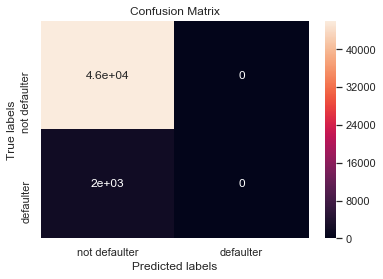

In [496]:
plot_confusion_matrix(confusion_final)

In [497]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
    'criterion': ["entropy", "gini"]
}

n_folds = 5

# Instantiate the grid search model
dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid, 
                          cv = n_folds, verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    6.0s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(5, 15, 5), 'min_samples_leaf': range(50, 150, 50), 'min_samples_split': range(50, 150, 50), 'criterion': ['entropy', 'gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [498]:
# printing the optimal accuracy score and hyperparameters
print("Best accuracy", grid_search.best_score_)

Best accuracy 0.957647744056


In [499]:
print("HyperParameters are",grid_search.best_estimator_)

HyperParameters are DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=50,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [500]:
# Create model using best hyperparameters
clf_entropy = DecisionTreeClassifier(criterion = "entropy", 
                                  random_state = 100,
                                  max_depth=5, 
                                  min_samples_leaf=50,
                                  min_samples_split=50)
clf_entropy.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=50,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [501]:
# accuracy score on train data
print("Accuracy of the model is ",clf_entropy.score(X_train,y_train))

Accuracy of the model is  0.957647744056


In [502]:
# accuracy score on test data
print("Accuracy of the model is ",clf_entropy.score(X_test,y_test))

Accuracy of the model is  0.958260531936


In [503]:
# classification metrics
from sklearn.metrics import classification_report,confusion_matrix

In [504]:
# Classification Report on the Train Dataset
y_train_pred = clf_entropy.predict(X_train)
print(classification_report(y_train, y_train_pred))

             precision    recall  f1-score   support

        0.0       0.96      1.00      0.98     46037
        1.0       0.00      0.00      0.00      2036

avg / total       0.92      0.96      0.94     48073



In [505]:
# Classification Report on the Test Dataset
from sklearn.metrics import classification_report,confusion_matrix
y_pred = clf_entropy.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

        0.0       0.96      1.00      0.98     19744
        1.0       0.00      0.00      0.00       860

avg / total       0.92      0.96      0.94     20604



In [506]:
# create Confusion matrix
confusion_final5 = metrics.confusion_matrix(y_train, y_train_pred)
confusion_final5

array([[46037,     0],
       [ 2036,     0]])

In [507]:
TP = confusion_final5[1,1] # true positive 
TN = confusion_final5[0,0] # true negatives
FP = confusion_final5[0,1] # false positives
FN = confusion_final5[1,0] # false negatives

In [508]:
# Let's see the sensitivity of our logistic regression model
print("Sensitivity of the Model is ",TP / float(TP+FN))

Sensitivity of the Model is  0.0


In [509]:
# Let's see the specificity of our logistic regression model
print("specificity of the Model is ",TN / float(TN+FP))

specificity of the Model is  1.0


In [510]:
# create Confusion matrix
confusion_final6= metrics.confusion_matrix(y_test, y_pred)
confusion_final6

array([[19744,     0],
       [  860,     0]])

In [511]:
TP = confusion_final6[1,1] # true positive 
TN = confusion_final6[0,0] # true negatives
FP = confusion_final6[0,1] # false positives
FN = confusion_final6[1,0] # false negatives

In [512]:
# Let's see the sensitivity of our logistic regression model
print("Sensitivity of the Model is ",TP / float(TP+FN))

Sensitivity of the Model is  0.0


In [513]:
# Let's see the specificity of our logistic regression model
print("specificity of the Model is ",TN / float(TN+FP))

specificity of the Model is  1.0


### Random Forest Analysis

In [514]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

In [515]:
# Running the random forest with default parameters.
rfc = RandomForestClassifier()

In [516]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

In [517]:
# fit model
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [518]:
# predict churn on train data
y_train_pred = rfc.predict(X_train)

In [519]:
# predict churn on test data
y_test_pred = rfc.predict(X_test)

In [520]:
# classification Report on the Train  default model
print(classification_report(y_train,y_train_pred))

             precision    recall  f1-score   support

        0.0       0.97      1.00      0.98     46037
        1.0       0.83      0.19      0.31      2036

avg / total       0.96      0.96      0.95     48073



In [521]:
# classification Report on the Test  default model
print(classification_report(y_test,y_test_pred))

             precision    recall  f1-score   support

        0.0       0.96      0.99      0.98     19744
        1.0       0.07      0.01      0.02       860

avg / total       0.92      0.95      0.94     20604



In [522]:
# create Confusion matrix
confusion_final7 = metrics.confusion_matrix(y_test, y_test_pred)
confusion_final7

array([[19617,   127],
       [  851,     9]])

In [523]:
print("The accuracy Score of the model is ",accuracy_score(y_test,y_test_pred))

The accuracy Score of the model is  0.952533488643


In [524]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [4,8,10],
    'min_samples_leaf': range(100, 400, 200),
    'min_samples_split': range(200, 500, 200),
    'n_estimators': [100,200, 300], 
    'max_features': [5, 10]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1)

In [525]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

In [526]:
# The optimal accuracy score and hyperparameters
print('We will get accuracy of',grid_search.best_score_,'using hyperparameters',grid_search.best_params_)

AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

In [527]:
# model with the best hyperparameters
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(bootstrap=True,
                             max_depth=2,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=5,
                             n_estimators=100)

In [528]:
# fit the random forest
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=200,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [529]:
# do the predictiction  train
train_predictions = rfc.predict(X_train)

In [530]:
# do the predictiction  test
test_predictions = rfc.predict(X_test)

In [531]:
# create Confusion matrix
confusion_final8= metrics.confusion_matrix(y_train, train_predictions)
confusion_final8

array([[46037,     0],
       [ 2036,     0]])

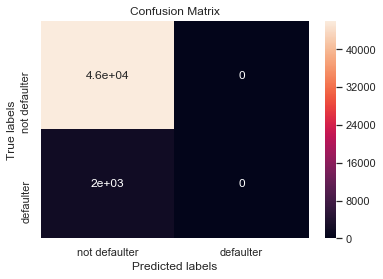

In [532]:
plot_confusion_matrix(confusion_final8)

In [533]:
TP = confusion_final8[1,1] # true positive 
TN = confusion_final8[0,0] # true negatives
FP = confusion_final8[0,1] # false positives
FN = confusion_final8[1,0] # false negatives

In [534]:
# Let's see the sensitivity of our logistic regression model
print("Sensitivity of the Model is ",TP / float(TP+FN))

Sensitivity of the Model is  0.0


In [535]:
# Let's see the specificity of our logistic regression model
print("specificity of the Model is ",TN / float(TN+FP))

specificity of the Model is  1.0
